В предыдущих темах вы познакомились с основными видами рекомендательных систем: неперсонализированными, контентными, коллаборативной фильтрацией и матричными разложениями. Мы обсудили их сильные и слабые стороны, ключевые проблемы (разреженность, смещение популярности, холодный старт) и то, как измерять качество рекомендаций через метрики Precision@K, Recall@K и nDCG.

Теперь важно закрепить эти знания на практике. В этом задании вам предстоит применить весь изученный инструментарий и построить рабочий прототип книжного рекомендательного сервиса.

Верхнеуровнево ваша задача будет состоять из трёх шагов:

Подготовка данных и анализ — исследовать датасет Goodbooks-10k, выявить особенности и проблемы.
Реализация моделей — последовательно построить бейзлайны: популярные книги, контентная модель (например, с использованием TF-IDF для векторизации описаний книг), Item-based CF и SVD.
Сравнение и выводы — оценить качество моделей с помощью метрик, сравнить результаты и предложить идеи для улучшения.
Итогом станет прототип системы, который объединяет несколько подходов и показывает, как разные методы работают на одних и тех же данных.

Задачи и этапы работы
Датасет: goodbooks-10k.

Цель: реализовать, проанализировать и сравнить различные подходы рекомендательных систем для сервиса по подбору книг.

Воспользуемся скачиванием с гитхаба

Была долгая и мучительная проблема с конфликтом surprise и numpy, поэтому сразу переустановим numpy и перезапустим ноутбук

In [ ]:
!pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless thinc
!pip install -U "numpy<2" "scikit-surprise==1.1.4" --no-cache-dir

# Перезапускаем ядро, чтобы NumPy подхватился корректно:
import os, sys
os.kill(os.getpid(), 9)

После отыгрывания ячейки выше, надо будет вручную продолжить выполнение ниже

In [1]:
from surprise import Dataset, Reader, SVD, accuracy
import numpy as np
print("NumPy:", np.__version__)

NumPy: 1.26.4


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zygmunt/goodbooks-10k")

print("Path to dataset files:", path)

100%|██████████| 11.6M/11.6M [00:00<00:00, 42.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5


Посмотрим, что там

In [3]:
ls /root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5

books.csv  book_tags.csv  ratings.csv  sample_book.xml  tags.csv  to_read.csv


## Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)<br>
Загрузите данные: ratings.csv, books.csv, tags.csv, book_tags.csv.<br>
Проведите разведочный анализ:<br>
Распределение оценок. Есть ли смещение в сторону высоких оценок?
Анализ активности пользователей. Постройте график «Взаимоотношение количества пользователей и количества оценок». Выявите активных пользователей и пользователей с малым количеством взаимодействий (проблема холодного старта).
Анализ популярности книг. Постройте график «Количество книг vs количество оценок». Выявите популярные книги и «длинный хвост».<br>
Визуализируйте самые частые теги для книг (на основе book_tags.csv).<br>
Какие основные проблемы данных (разреженность, смещение популярности) видны уже на этапе EDA?

Загрузим книги в датасеты, настроим отображение, посмотрим нужные

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


Загрузим датасет и исправим маппинги: введем единый ключ item_id

In [5]:
BASE = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master"
books      = pd.read_csv(f"{BASE}/books.csv")
ratings    = pd.read_csv(f"{BASE}/ratings.csv")
tags       = pd.read_csv(f"{BASE}/tags.csv")
book_tags  = pd.read_csv(f"{BASE}/book_tags.csv")

## Изучим таблицу books

In [6]:
display(books.head())
print()
display(books.info())
print()
display(books.describe().T)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int

None

,count,mean,std,min,25%,50%,75%,max
book_id,10000.0,5.000500e+03,2.886896e+03,1.000000e+00,2.500750e+03,5.000500e+03,7.500250e+03,1.000000e+04
goodreads_book_id,10000.0,5.264697e+06,7.575462e+06,1.000000e+00,4.627575e+04,3.949655e+05,9.382225e+06,3.328864e+07
best_book_id,10000.0,5.471214e+06,7.827330e+06,1.000000e+00,4.791175e+04,4.251235e+05,9.636112e+06,3.553423e+07
work_id,10000.0,8.646183e+06,1.175106e+07,8.700000e+01,1.008841e+06,2.719524e+06,1.451775e+07,5.639960e+07
books_count,10000.0,7.571270e+01,1.704707e+02,1.000000e+00,2.300000e+01,4.000000e+01,6.700000e+01,3.455000e+03
isbn13,9415.0,9.755044e+12,4.428619e+11,1.951703e+08,9.780316e+12,9.780452e+12,9.780831e+12,9.790008e+12
original_publication_year,9979.0,1.981988e+03,1.525767e+02,-1.750000e+03,1.990000e+03,2.004000e+03,2.011000e+03,2.017000e+03
average_rating,10000.0,4.002191e+00,2.544275e-01,2.470000e+00,3.850000e+00,4.020000e+00,4.180000e+00,4.820000e+00
ratings_count,10000.0,5.400124e+04,1.573700e+05,2.716000e+03,1.356875e+04,2.115550e+04,4.105350e+04,4.780653e+06
work_ratings_count,10000.0,5.968732e+04,1.678038e+05,5.510000e+03,1.543875e+04,2.383250e+04,4.591500e+04,4.942365e+06


Описание таблицы books.csv:<br>
В таблице  10 000 записей, 23 признака.<br>
Типы данных: числовые (int64, float64) и строковые (object).<br>
Пропущенные значения встречаются в некоторых полях (isbn, isbn13, original_title, language_code, original_publication_year).<br>


Описание полей таблицы books.csv:<br>
book_id, best_book_id, work_id – Идентификаторы книги и связанного “произведения” (в разных версиях издания)<br>
books_count –	Количество версий (изданий) одной книги<br>
isbn, isbn13 –	Международные идентификаторы книги. Присутствуют не у всех — часть книг не имеет ISBN<br>
authors –	Автор(ы) книги. Иногда указано несколько<br>
original_publication_year	– Год оригинального издания (встречаются пропуски и даже некорректные значения)<br>
original_title – Оригинальное название книги (может отличаться от title, особенно при переводах)<br>
title –	Название книги, как оно представлено в наборе данных<br>
language_code –	Язык книги. Преобладают 'eng', 'en-US', 'spa' и др. Есть пропуски<br>
average_rating –	Средняя пользовательская оценка книги (агрегированная по Goodreads)<br>
ratings_count, work_ratings_count –	Общее количество оценок (по книге и по "произведению")<br>
work_text_reviews_count –	Количество текстовых отзывов<br>
ratings_1 … ratings_5	Количество пользователей, поставивших конкретную оценку (от 1 до 5)<br>
image_url, small_image_url – Ссылки на обложку книги

Пропуски данных в таблице books.csv:
isbn:	около 5%	часть книг без ISBN<br>
isbn13: аналогично<br>
original_title: 5%	отсутствует у некоторых переводов<br>
language_code:	10%	не указаны языки для части книг<br>
original_publication_year:	почти полное покрытие, но встречаются странные значения (например, 0 или слишком большие годы)
Возможно, эти данные нам не понадобятся для строительства рекомендательной системы, оставим их пока что как есть.

Таблица books.csv — это метаданные о книгах (авторы, названия, годы, рейтинги и статистика оценок).
Она отражает:

популярность книг на Goodreads,
средний рейтинг в целом высокий (4),
длинный хвост менее известных книг,
а также умеренное количество пропусков в технических полях.

Эти особенности важно учитывать при дальнейшем построении рекомендательной системы — особенно при балансировке данных, обработке холодного старта и нормализации рейтингов.

### Изучим таблицу ratings

In [7]:
display(ratings.head())
print()
display(ratings.info())
print()
display(ratings.describe().T)


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


None

,count,mean,std,min,25%,50%,75%,max
user_id,5976479.0,26224.457362,15413.234093,1.0,12813.0,25938.0,39509.0,53424.0
book_id,5976479.0,2006.477398,2468.499463,1.0,198.0,885.0,2973.0,10000.0
rating,5976479.0,3.919866,0.991087,1.0,3.0,4.0,5.0,5.0


Таблица ratings содержит почти миллион записей и состоит из всего 3 колонок:<br>
book_id — идентификатор книги (от 1 до 10 000)<br>
user_id — идентификатор пользователя (от 1 до 53 424)<br>
rating — поставленная пользователем оценка (от 1 до 5)<br>

Как видно, пользователи в основном ставят высокие рейтинги, т.к. среднее около 4. Т.е. оценки явно смещены в сторону положительных: пользователи чаще оценивают книги, которые им понравились. Минимальные (1–2) встречаются редко, т.е. распределение несбалансировано.

В таблице встречаются 53 424 уникальных пользователей. Запишем это в переменну.<br>

In [8]:
n_users = len(ratings.user_id.unique())

### Изучим таблицу Tags

In [9]:
display(tags.head(20))
print()
display(tags.info())
print()
display(tags.describe().T)

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
5,5,--166-
6,6,--17-
7,7,--19-
8,8,--2-
9,9,--258-



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


None

,count,mean,std,min,25%,50%,75%,max
tag_id,34252.0,17125.5,9887.845047,0.0,8562.75,17125.5,25688.25,34251.0


Таблица tags.csv содержит 34,252 записи (тегов)

Имеет 2 столбца: tag_id (числовой идентификатор) и tag_name (текстовое название)

Отсутствуют пропущенные значения в обоих столбцах
ID тегов распределены равномерно от 0 до 34,251 - это просто номер

Данные чистые (нет пропусков)

Структура таблицы простая и понятная

ID тегов последовательные и непрерывные

Особенности названий тегов
Названия тегов содержат как какие-то специальные символы (примеры: "--1-", "--10-", "--122-"), так и просто слова --available-at-raspberrys--


Посмотрим названия поближе



In [10]:
print(tags['tag_name'].nunique())
print(tags['tag_name'])

34252
0                 -
1              --1-
2             --10-
3             --12-
4            --122-
            ...    
34247     Ｃhildrens
34248     Ｆａｖｏｒｉｔｅｓ
34249         Ｍａｎｇａ
34250        ＳＥＲＩＥＳ
34251    ｆａｖｏｕｒｉｔｅｓ
Name: tag_name, Length: 34252, dtype: object


Теперь четко видно, что теги оооочень разные, есть там и человекочитаемые. Уникальных тегов много, но, возможно, есть повторяющи

Каждый тег в таблице tags, как и айди, уникален

### Посмотрим таблицу book_tags

In [11]:
display(book_tags.head(20))
print()
display(book_tags.info())
print()
display(book_tags.describe().T)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
5,1,11743,9954
6,1,14017,7169
7,1,5207,6221
8,1,22743,4974
9,1,32989,4364



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


None

,count,mean,std,min,25%,50%,75%,max
goodreads_book_id,999912.0,5.263442e+06,7.574057e+06,1.0,46227.0,394841.0,9378297.0,33288638.0
tag_id,999912.0,1.632453e+04,9.647846e+03,0.0,8067.0,15808.0,24997.0,34251.0
count,999912.0,2.088696e+02,3.501265e+03,-1.0,7.0,15.0,40.0,596234.0


### Изучим таблицу ratings

In [12]:
display(ratings.head(20))
print()
display(ratings.info())
print()
display(ratings.describe().T)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


None

,count,mean,std,min,25%,50%,75%,max
user_id,5976479.0,26224.457362,15413.234093,1.0,12813.0,25938.0,39509.0,53424.0
book_id,5976479.0,2006.477398,2468.499463,1.0,198.0,885.0,2973.0,10000.0
rating,5976479.0,3.919866,0.991087,1.0,3.0,4.0,5.0,5.0


Исправим маппинги

In [13]:
if "item_id" not in ratings.columns and "book_id" in ratings.columns:
    ratings = ratings.rename(columns={"book_id": "item_id"})

if "item_id" not in books.columns and "book_id" in books.columns:
    books = books.rename(columns={"book_id": "item_id"})

if books.index.name != "item_id":
    books = books.set_index("item_id")

gr2item = dict(zip(books["goodreads_book_id"], books.index))

if "item_id" not in book_tags.columns:
    book_tags = book_tags.assign(item_id=book_tags["goodreads_book_id"].map(gr2item))

book_tags = book_tags.dropna(subset=["item_id"]).astype({"item_id": int})

user_col, item_col, rating_col = "user_id", "item_id", "rating"


In [14]:

print(f"Всего книг в каталоге: {books.shape[0]:,}")
print(f"Книг с оценками: {ratings[item_col].nunique():,}")
print(f"Книг без оценок: {books.shape[0] - ratings[item_col].nunique():,}")
print(f"Пользователей: {ratings[user_col].nunique():,}")
print(f"Всего оценок: {len(ratings):,}")
print(f"Средняя оценка: {ratings[rating_col].mean():.2f}")


total_books_in_ratings = ratings['item_id'].nunique()
total_users = ratings['user_id'].nunique()
density = len(ratings) / (ratings[user_col].nunique() * ratings[item_col].nunique())
print(f"- Плотность (для книг с оценками): {density*100:.2f}%")


Всего книг в каталоге: 10,000
Книг с оценками: 10,000
Книг без оценок: 0
Пользователей: 53,424
Всего оценок: 5,976,479
Средняя оценка: 3.92
- Плотность (для книг с оценками): 1.12%


У всех книг в таблице ratings есть оценки, что немудрено (т.е. все книги имеют оценки)

Зададим константы сразу

In [15]:
n_users  = ratings[user_col].nunique()
n_items  = ratings[item_col].nunique()
total_books = books.shape[0]

print(f"Всего пользователей: {n_users}")
print(f"Всего книг: {n_items}")
print(f"Всего оценок: {ratings.shape[0]}")

Всего пользователей: 53424
Всего книг: 10000
Всего оценок: 5976479


Изучим сколько уникальных тегов на каждую книгу

In [16]:
book_tag_counts_unique = (
    book_tags.groupby('goodreads_book_id')['tag_id']
    .nunique()
    .sort_values(ascending=False)
)

book_tag_counts_mentions = (
    book_tags.groupby('goodreads_book_id')['count']
    .sum()
    .sort_values(ascending=False)
)

book_tag_counts = book_tag_counts_unique

print("Проверка: размерность и первые значения")
print(len(book_tag_counts), book_tag_counts.head())


print("\nДетальный анализ распределения тегов на книгу:")
print(book_tag_counts.value_counts().head(10))

books_with_100_tags = book_tag_counts[book_tag_counts == 100]
print(f"\nКниг с ровно 100 тегами: {len(books_with_100_tags)}")
print(f"Это {len(books_with_100_tags)/len(book_tag_counts)*100:.1f}% от всех книг")


Проверка: размерность и первые значения
10000 goodreads_book_id
1          100
6344097    100
6338619    100
6339304    100
6339664    100
Name: tag_id, dtype: int64

Детальный анализ распределения тегов на книгу:
tag_id
100    9993
99        2
98        1
96        1
94        1
62        1
56        1
Name: count, dtype: int64

Книг с ровно 100 тегами: 9993
Это 99.9% от всех книг


В дальнейшем посмотрим расшифровку тегов

### Посмотрим активность пользователей

Проблемы данных: разреженность, смещение популярности, холодный старт (численно)

In [17]:
n_interactions = ratings.shape[0]
density = n_interactions / (n_users * n_items) if (n_users>0 and n_items>0) else float('nan')

print(f"Пользователей: {n_users}, Книг: {n_items}, Оценок: {n_interactions}")
print(f"Плотность (density) матрицы: {density:.6f}  → Разреженность ≈ {1 - density:.6f}")

avg_rating = ratings[rating_col].mean()
print(f"Средняя оценка: {avg_rating:.3f}")

Пользователей: 53424, Книг: 10000, Оценок: 5976479
Плотность (density) матрицы: 0.011187  → Разреженность ≈ 0.988813
Средняя оценка: 3.920


Книг с оценками = 10 000

Плотность = 1.11 % (или 0.011187 в долях)

Разреженность ≈ 98.88 %

Построим небольшую визуализацию на подвыборке для наглядности

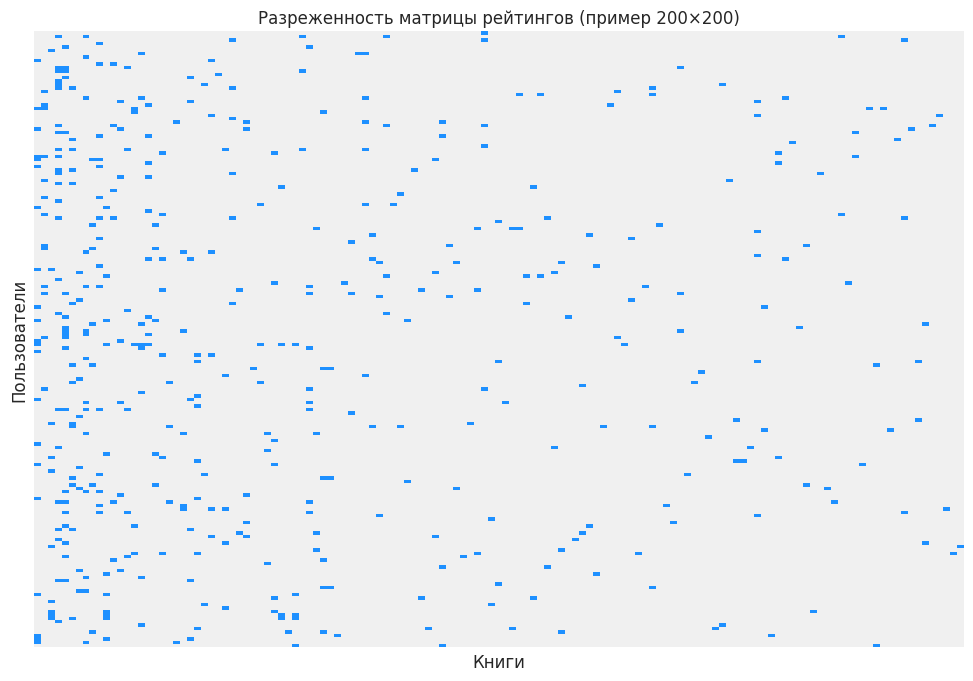

In [18]:
sample_items = np.random.choice(ratings[item_col].unique(), 200, replace=False)
sample_users = np.random.choice(ratings[user_col].unique(), 200, replace=False)


sample = ratings[
    ratings[user_col].isin(sample_users) &
    ratings[item_col].isin(sample_items)
]

pivot = sample.pivot_table(
    index=user_col, columns=item_col, values=rating_col, aggfunc='mean'
)


plt.figure(figsize=(12, 8))
sns.heatmap(pivot.isna(),
            cbar=False,
            cmap=['#1e90ff', '#f0f0f0'],  #синие = есть рейтинг, серые = нет
            xticklabels=False,
            yticklabels=False)
plt.title('Разреженность матрицы рейтингов (пример 200×200)')
plt.xlabel('Книги')
plt.ylabel('Пользователи')
plt.show()


Почти всё серое (нет взаимодействий), и лишь редкие синие точки — это реальные оценки пользователей.

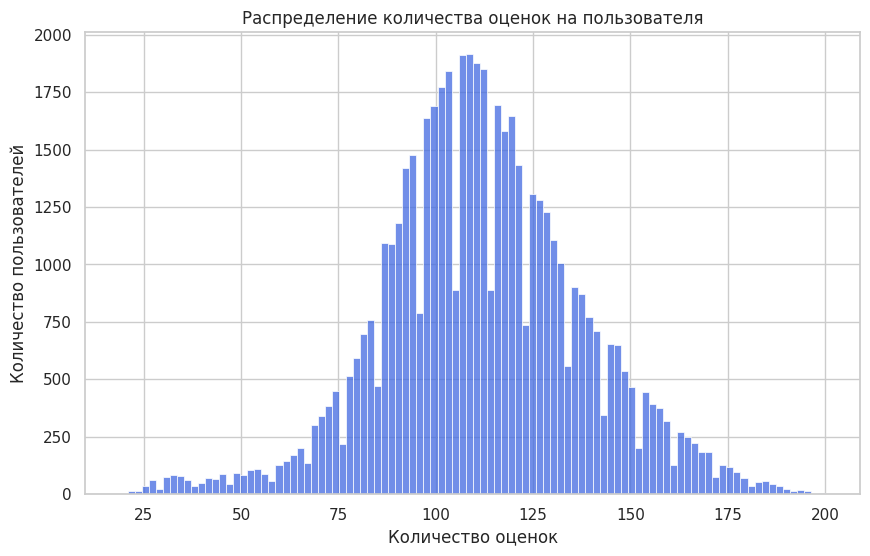

Среднее число оценок на пользователя: 111.87
Медианное число оценок: 111
Максимум: 200


In [19]:
#количество оценок на пользователя
user_activity = ratings.groupby('user_id')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=100, kde=False, color='royalblue')
plt.title('Распределение количества оценок на пользователя')
plt.xlabel('Количество оценок')
plt.ylabel('Количество пользователей')
#plt.xscale('log')
plt.show()

print(f"Среднее число оценок на пользователя: {user_activity.mean():.2f}")
print(f"Медианное число оценок: {user_activity.median():.0f}")
print(f"Максимум: {user_activity.max()}")


Пользователи в среднем ставили 18 оценок

Посмотрим, какие оценки ставили

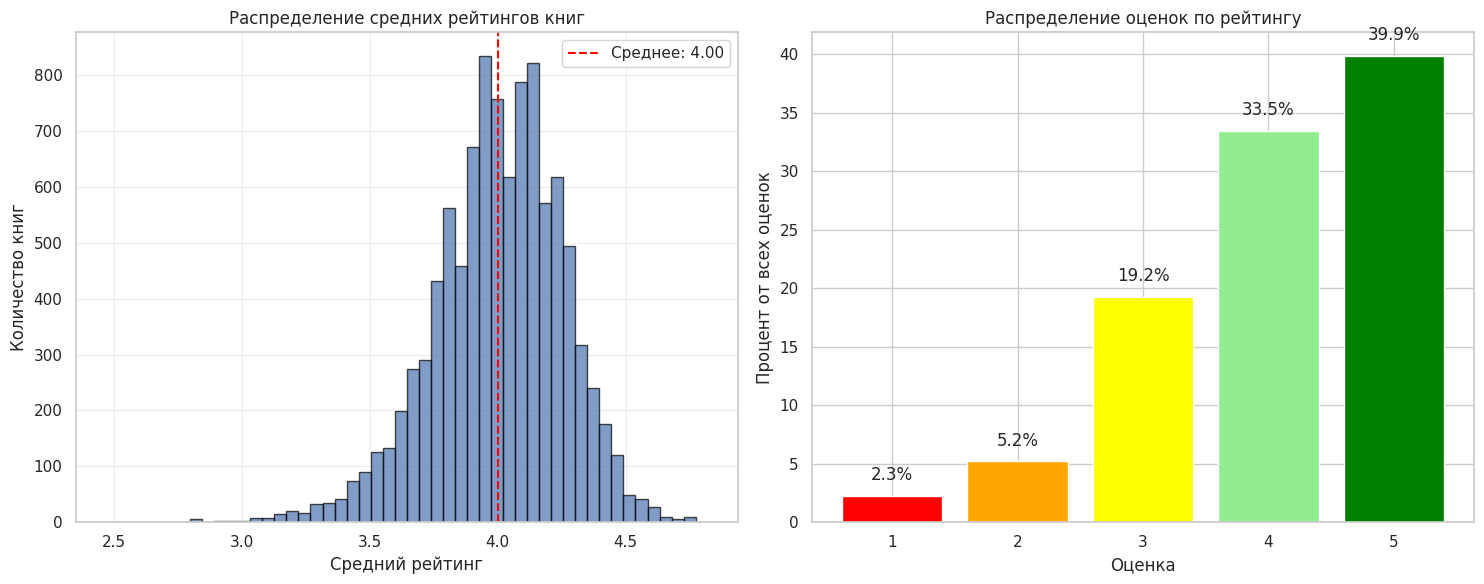

=== АНАЛИЗ СМЕЩЕНИЯ ОЦЕНОК ===
Средний рейтинг всех книг: 4.00
Медианный рейтинг: 4.02
Процент книг с рейтингом > 4.0: 51.9%
Процент книг с рейтингом < 3.0: 0.1%
Коэффициент асимметрии распределения рейтингов: -0.51


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(books['average_rating'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(books['average_rating'].mean(), color='red', linestyle='--', label=f'Среднее: {books["average_rating"].mean():.2f}')
axes[0].set_xlabel('Средний рейтинг')
axes[0].set_ylabel('Количество книг')
axes[0].set_title('Распределение средних рейтингов книг')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

ratings_columns = ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
ratings_sum = books[ratings_columns].sum()
ratings_percentage = ratings_sum / ratings_sum.sum() * 100

bars = axes[1].bar(range(1, 6), ratings_percentage, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
axes[1].set_xlabel('Оценка')
axes[1].set_ylabel('Процент от всех оценок')
axes[1].set_title('Распределение оценок по рейтингу')
axes[1].set_xticks(range(1, 6))

# Добавляем проценты на столбцы
for bar, percentage in zip(bars, ratings_percentage):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{percentage:.1f}%', ha='center', va='bottom')


plt.tight_layout()
plt.show()

print("=== АНАЛИЗ СМЕЩЕНИЯ ОЦЕНОК ===")
print(f"Средний рейтинг всех книг: {books['average_rating'].mean():.2f}")
print(f"Медианный рейтинг: {books['average_rating'].median():.2f}")
print(f"Процент книг с рейтингом > 4.0: {(books['average_rating'] > 4.0).mean()*100:.1f}%")
print(f"Процент книг с рейтингом < 3.0: {(books['average_rating'] < 3.0).mean()*100:.1f}%")
print(f"Коэффициент асимметрии распределения рейтингов: {books['average_rating'].skew():.2f}")

1. Явное смещение в сторону высоких оценок
Средний рейтинг 4.00 - это очень высокий показатель

Распределение скошено вправо (в сторону высоких значений)

Большинство книг имеют рейтинг в диапазоне 3.5-4.5

2. Характеристики распределения:
Мода (наиболее частое значение) вероятно около 4.0-4.2

Медиана близка к среднему значению 4.00

Очень мало книг с низкими рейтингами (< 3.0)

Практически нет книг с рейтингом ниже 2.5

3. Пользователи ставят высокие оценки в основном

Низкие оценки используются редко и избирательно

Возможен эффект социального доказательства - популярные книги получают еще больше высоких оценок


# Анализ распределения оценок по рейтингу:
1. Доминирование высоких оценок

5: наибольшее количество оценок (40%)

4: второй по популярности вариант (34%)

3: умеренное количество (19%)

1-2: наименьшее количество (7% вместе)

Предполагаем, что ratings отражает активность пользователей, проанализируем его

Пользователей: 53424, Книг: 10000, Оценок: 5976479
Плотность: 0.011187  → Разреженность ≈ 0.988813


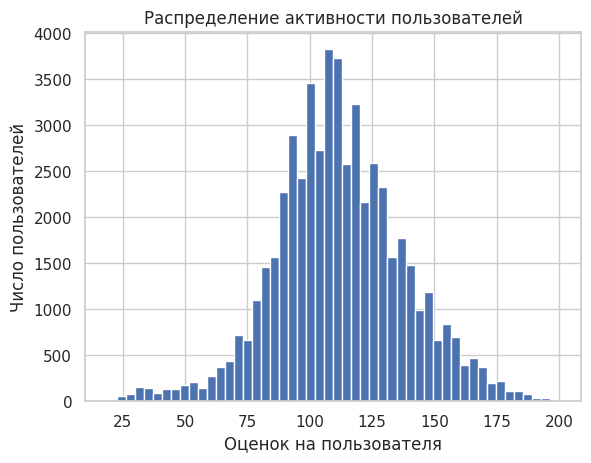

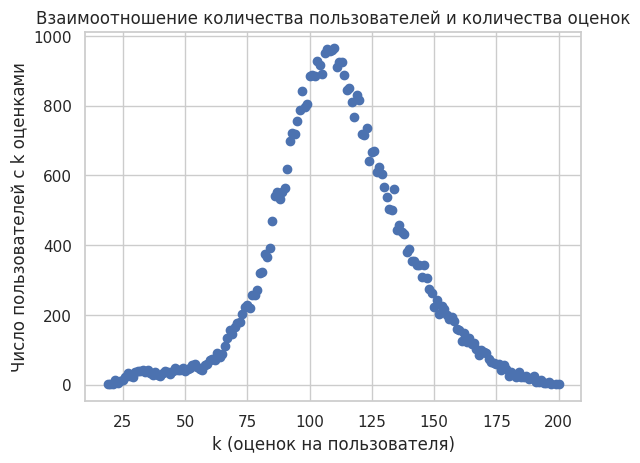

Всего пользователей: 53424
Активные пользователи (>= 146): 5423 (10.2%)
Холодный старт (<= 3): 0 (0.0%)


In [21]:
user_col = "user_id"
item_col = "item_id"
rating_col = "rating"

user_counts = ratings[user_col].value_counts()
book_counts = ratings[item_col].value_counts()

n_users = user_counts.shape[0]
n_items = book_counts.shape[0]
n_interactions = ratings.shape[0]
density = n_interactions / (n_users * n_items) if (n_users>0 and n_items>0) else float("nan")

print(f"Пользователей: {n_users}, Книг: {n_items}, Оценок: {n_interactions}")
print(f"Плотность: {density:.6f}  → Разреженность ≈ {1 - density:.6f}")

user_counts = ratings.groupby(user_col)[rating_col].size()

plt.figure()
plt.hist(user_counts.values, bins=50)
plt.xlabel('Оценок на пользователя')
plt.ylabel('Число пользователей')
plt.title('Распределение активности пользователей')
plt.show()

freq = user_counts.value_counts().sort_index()
plt.figure()
plt.plot(freq.index.values, freq.values, marker='o', linestyle='none')
plt.xlabel('k (оценок на пользователя)')
plt.ylabel('Число пользователей с k оценками')
plt.title('Взаимоотношение количества пользователей и количества оценок')
plt.grid(True)
plt.show()

# Порог для активных/холодных
active_threshold = max(10, int(user_counts.quantile(0.9)))  # топ-10% или >=10
cold_threshold = 3

active_users = (user_counts >= active_threshold).sum()
cold_users   = (user_counts <= cold_threshold).sum()

print(f"Всего пользователей: {user_counts.shape[0]}")
print(f"Активные пользователи (>= {active_threshold}): {active_users} "
      f"({active_users / user_counts.shape[0]:.1%})")
print(f"Холодный старт (<= {cold_threshold}): {cold_users} "
      f"({cold_users / user_counts.shape[0]:.1%})")

Пользователи в целом достаточно активны

Посмотрим количество книг против количества оценок

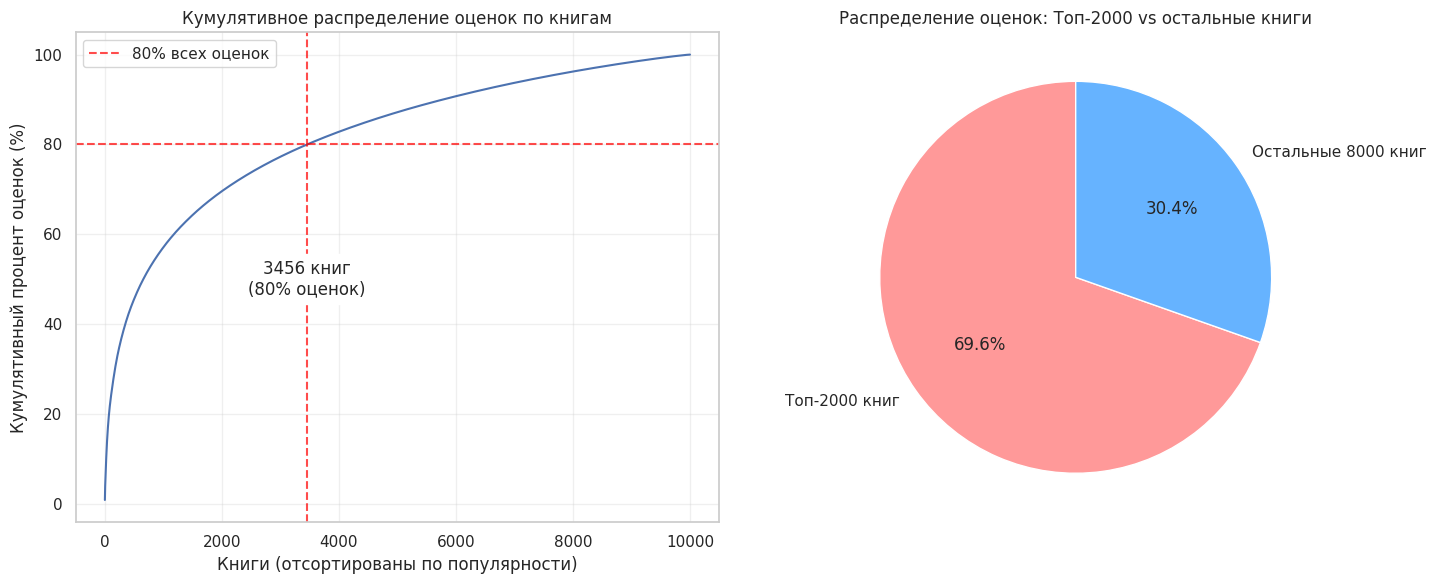

=== АНАЛИЗ АКТИВНОСТИ ===
Всего оценок: 540,012,351
Топ-2000 книг собирают 69.6% всех оценок
50% всех оценок приходится на 656 самых популярных книг


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Кумулятивное распределение оценок
sorted_ratings = np.sort(books['ratings_count'])[::-1]
cumulative_ratings = np.cumsum(sorted_ratings) / np.sum(sorted_ratings)

axes[0].plot(range(1, len(cumulative_ratings) + 1), cumulative_ratings * 100)
axes[0].axhline(80, color='red', linestyle='--', alpha=0.7, label='80% всех оценок')
axes[0].set_xlabel('Книги (отсортированы по популярности)')
axes[0].set_ylabel('Кумулятивный процент оценок (%)')
axes[0].set_title('Кумулятивное распределение оценок по книгам')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

eighty_percent_index = np.where(cumulative_ratings >= 0.8)[0][0]
axes[0].axvline(eighty_percent_index, color='red', linestyle='--', alpha=0.7)
axes[0].text(eighty_percent_index, 50, f'{eighty_percent_index} книг\n(80% оценок)',
            ha='center', va='center', backgroundcolor='white')

top_n = 2000
top_books_ratings = sorted_ratings[:top_n]
other_books_ratings = sorted_ratings[top_n:]

labels = [f'Топ-{top_n} книг', f'Остальные {len(other_books_ratings)} книг']
sizes = [np.sum(top_books_ratings), np.sum(other_books_ratings)]
colors = ['#ff9999', '#66b3ff']

axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title(f'Распределение оценок: Топ-{top_n} vs остальные книги')

plt.tight_layout()
plt.show()

print("=== АНАЛИЗ АКТИВНОСТИ ===")
print(f"Всего оценок: {books['ratings_count'].sum():,}")
print(f"Топ-2000 книг собирают {np.sum(top_books_ratings)/np.sum(sorted_ratings)*100:.1f}% всех оценок")
print(f"50% всех оценок приходится на {np.where(cumulative_ratings >= 0.5)[0][0]} самых популярных книг")

Распределение менее экстремальное, чем классическое правило 80/20

Есть потенциал для открытия менее популярных книг

Система должна балансировать между рекомендацией проверенных хитов и открытием скрытых жемчужи

Посмотрим количество оценок подробнее

In [23]:
# Проверим маппинг между books и ratings
print("Проверка маппинга:")
print(f"Книги в books: {books.index.nunique()}")
print(f"Книги в ratings: {ratings[item_col].nunique()}")
print(f"Пересечение: {ratings[item_col].isin(books.index).mean()*100:.1f}%")

# Проверим дубликаты в ratings
print(f"\nДубликаты в ratings: {ratings.duplicated(subset=[user_col, item_col]).sum()}")

Проверка маппинга:
Книги в books: 10000
Книги в ratings: 10000
Пересечение: 100.0%

Дубликаты в ratings: 0


Построим таблицу количество книг vs количество оценок

Всего книг: 10000
Книг с оценками: 10000
Книг без оценок: 0


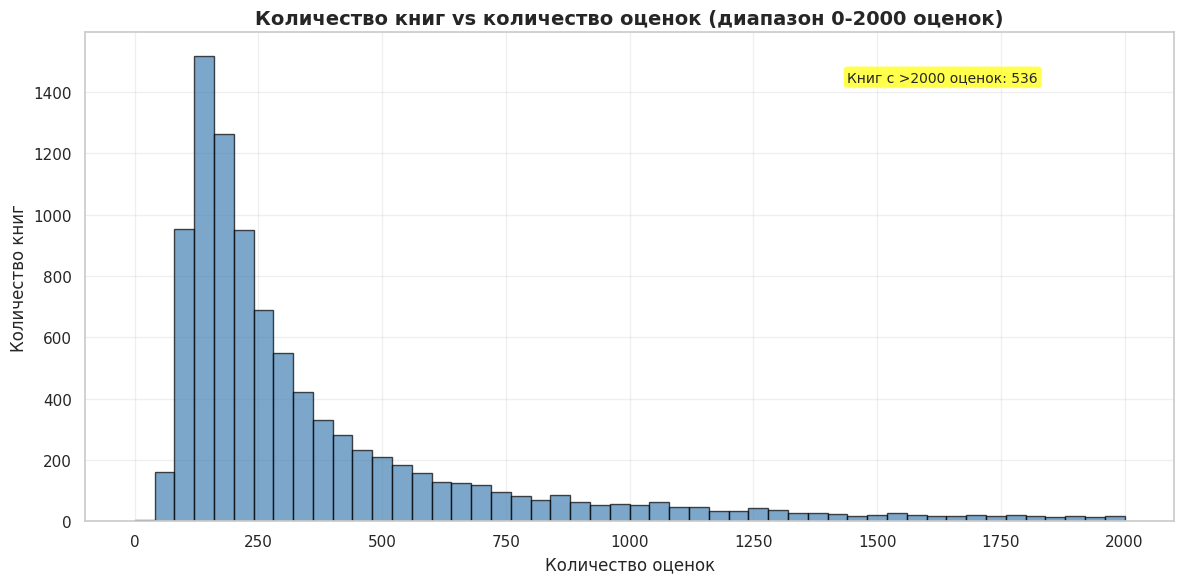

In [24]:
# Создаем таблицу с количеством оценок для каждой книги
book_rating_counts = ratings.groupby('item_id').size().reset_index(name='num_ratings')

# Объединяем с основной таблицей books
all_books_with_ratings = books.merge(book_rating_counts,
                                    left_index=True,
                                    right_on='item_id',
                                    how='left')

# Заполняем нулями книги без оценок
all_books_with_ratings['num_ratings'] = all_books_with_ratings['num_ratings'].fillna(0).astype(int)

print(f"Всего книг: {len(all_books_with_ratings)}")
print(f"Книг с оценками: {(all_books_with_ratings['num_ratings'] > 0).sum()}")
print(f"Книг без оценок: {(all_books_with_ratings['num_ratings'] == 0).sum()}")

plt.figure(figsize=(12, 6))

# Ограничиваем диапазон до 2000 оценок, чтобы увидеть основную массу книг
plt.hist(all_books_with_ratings["num_ratings"], bins=50,
         edgecolor='black', alpha=0.7, color='steelblue',
         range=(0, 2000))  # Ограничиваем диапазон

plt.title("Количество книг vs количество оценок (диапазон 0-2000 оценок)",
          fontsize=14, fontweight='bold')
plt.xlabel("Количество оценок", fontsize=12)
plt.ylabel("Количество книг", fontsize=12)
plt.grid(True, alpha=0.3)

# Добавляем информацию о выбросах
outliers_count = (all_books_with_ratings['num_ratings'] > 2000).sum()
plt.text(0.7, 0.9, f'Книг с >2000 оценок: {outliers_count}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

In [25]:
print("=== ДЕТАЛЬНАЯ СТАТИСТИКА ПО ОЦЕНКАМ ===")
print(f"Всего книг: {len(all_books_with_ratings)}")

# Проверим разные диапазоны
ranges = [
    (0, 0, "0 оценок"),
    (1, 1, "1 оценка"),
    (2, 10, "2-10 оценок"),
    (11, 50, "11-50 оценок"),
    (51, 100, "51-100 оценок"),
    (101, 500, "101-500 оценок"),
    (501, 1000, "501-1000 оценок"),
    (1001, 5000, "1001-5000 оценок"),
    (5001, None, ">5000 оценок")
]

for min_val, max_val, label in ranges:
    if max_val is None:
        count = (all_books_with_ratings['num_ratings'] >= min_val).sum()
    else:
        count = ((all_books_with_ratings['num_ratings'] >= min_val) &
                (all_books_with_ratings['num_ratings'] <= max_val)).sum()

    percentage = count / len(all_books_with_ratings) * 100
    print(f"{label}: {count:4d} книг ({percentage:5.1f}%)")


=== ДЕТАЛЬНАЯ СТАТИСТИКА ПО ОЦЕНКАМ ===
Всего книг: 10000
0 оценок:    0 книг (  0.0%)
1 оценка:    0 книг (  0.0%)
2-10 оценок:    1 книг (  0.0%)
11-50 оценок:    9 книг (  0.1%)
51-100 оценок:  506 книг (  5.1%)
101-500 оценок: 6964 книг ( 69.6%)
501-1000 оценок: 1292 книг ( 12.9%)
1001-5000 оценок: 1075 книг ( 10.8%)
>5000 оценок:  153 книг (  1.5%)


Видно, что оценок у книг больше всего в диапазоне 101-500

Изучим подробнее проблему разрежженности данных

In [26]:
# Используем актуальные данные из ratings вместо агрегированных
actual_ratings_per_book = ratings.groupby(item_col)[rating_col].count()

print("АНАЛИЗ НА ОСНОВЕ ТАБЛИЦЫ RATINGS:")
print(f"Всего книг в ratings: {len(actual_ratings_per_book):,}")
print(f"Всего оценок в ratings: {len(ratings):,}")
print(f"Медиана оценок на книгу: {actual_ratings_per_book.median():.0f}")
print(f"Среднее оценок на книгу: {actual_ratings_per_book.mean():.0f}")


books_with_few_ratings = actual_ratings_per_book[actual_ratings_per_book < 100]
books_with_very_few_ratings = actual_ratings_per_book[actual_ratings_per_book < 10]

print(f"\nПРОБЛЕМА ХОЛОДНОГО СТАРТА (реальные данные):")

print(f"Книг с оценками: {len(actual_ratings_per_book):,}")
print(f"Книг без оценок: {total_books - len(actual_ratings_per_book):,} "
      f"({(total_books - len(actual_ratings_per_book)) / total_books * 100:.1f}%)")

sorted_actual_ratings = actual_ratings_per_book.sort_values(ascending=False).values
total_books_with_ratings = len(actual_ratings_per_book)

print(f"\nСМЕЩЕНИЕ ПОПУЛЯРНОСТИ (реальные данные):")
print(f"Топ-1% книг получает {np.sum(sorted_actual_ratings[:total_books_with_ratings//100])/np.sum(sorted_actual_ratings)*100:.1f}% всех оценок")
print(f"50% книг получает только {np.sum(sorted_actual_ratings[total_books_with_ratings//2:])/np.sum(sorted_actual_ratings)*100:.1f}% оценок")

АНАЛИЗ НА ОСНОВЕ ТАБЛИЦЫ RATINGS:
Всего книг в ratings: 10,000
Всего оценок в ratings: 5,976,479
Медиана оценок на книгу: 248
Среднее оценок на книгу: 598

ПРОБЛЕМА ХОЛОДНОГО СТАРТА (реальные данные):
Книг с оценками: 10,000
Книг без оценок: 0 (0.0%)

СМЕЩЕНИЕ ПОПУЛЯРНОСТИ (реальные данные):
Топ-1% книг получает 17.1% всех оценок
50% книг получает только 13.2% оценок


### Переходим к анализу тегов

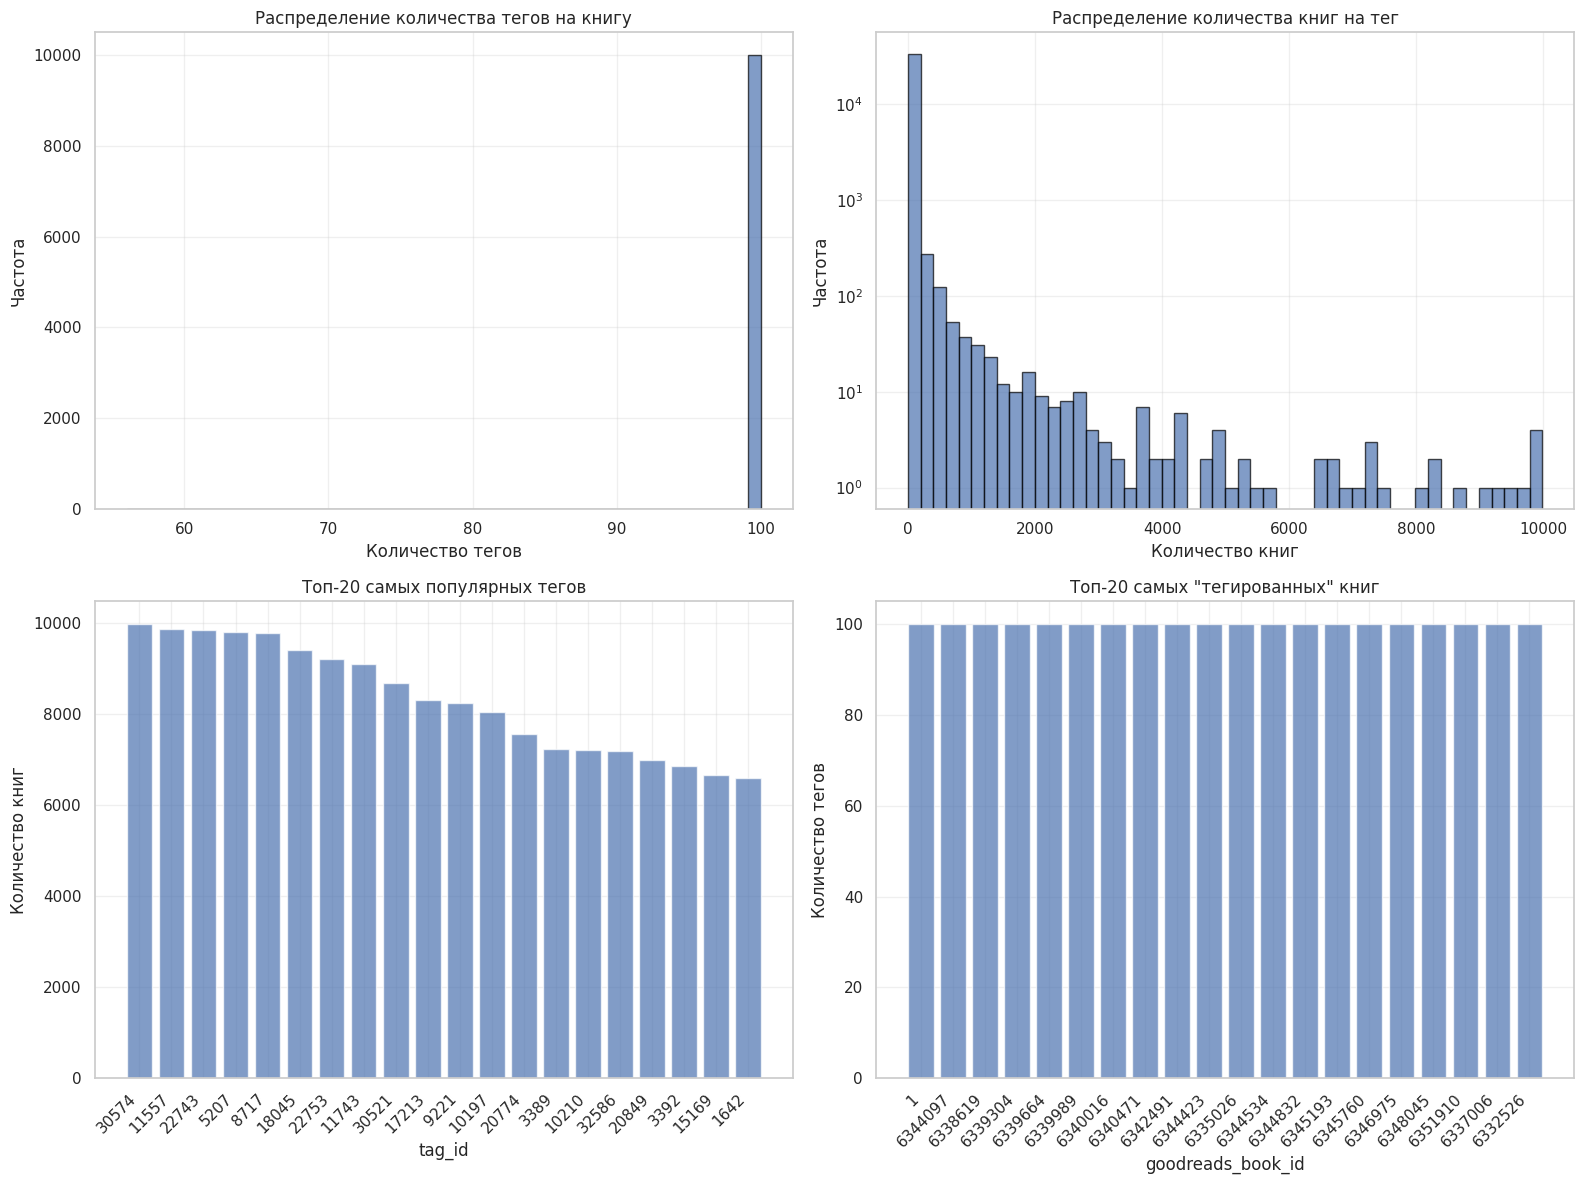

In [27]:
book_tag_counts_unique = (
    book_tags.groupby('goodreads_book_id')['tag_id']
             .nunique()
             .sort_values(ascending=False)
)
tag_book_counts = (
    book_tags.groupby('tag_id')['goodreads_book_id']
             .nunique()
             .sort_values(ascending=False)
)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].hist(book_tag_counts_unique.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение количества тегов на книгу')
axes[0, 0].set_xlabel('Количество тегов')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(tag_book_counts.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Распределение количества книг на тег')
axes[0, 1].set_xlabel('Количество книг')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

top_tags = tag_book_counts.head(20)
axes[1, 0].bar(range(len(top_tags)), top_tags.values, alpha=0.7)
axes[1, 0].set_title('Топ-20 самых популярных тегов')
axes[1, 0].set_xlabel('tag_id')
axes[1, 0].set_ylabel('Количество книг')
axes[1, 0].set_xticks(range(len(top_tags)))
axes[1, 0].set_xticklabels(list(map(str, top_tags.index)), rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

top_books = book_tag_counts_unique.head(20)
axes[1, 1].bar(range(len(top_books)), top_books.values, alpha=0.7)
axes[1, 1].set_title('Топ-20 самых "тегированных" книг')
axes[1, 1].set_xlabel('goodreads_book_id')
axes[1, 1].set_ylabel('Количество тегов')
axes[1, 1].set_xticks(range(len(top_books)))
axes[1, 1].set_xticklabels(list(map(str, top_books.index)), rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Распределение количества тегов на книгу (слева):

Почти все книги имеют примерно одинаковое количество тегов (около 100).

Распределение крайне смещено вправо (практически весь столбец сосредоточен на одном значении).

Это может означать, что либо данные неравномерно размечены (возможно, техническая ошибка — например, каждой книге автоматически присвоено одинаковое количество тегов), либо у тебя есть ограничение на максимум тегов (например, 100), и многие книги достигли этого лимита

2. Распределение количества книг на тег (справа):

Есть теги, присвоенные всем книгам, но большинство не присвоено ни одной из книг

3. Топ-20 самых популярных тегов (слева):

Разница между самым популярным и 20-м тегом не такая уж большая (примрно 10–30%).

Топовые теги применяются к 7000–10000 книгам — значит, есть группа тегов, которые очень часто используются (например, «фантастика», «роман», «детектив»).

4. Топ-20 самых тегированных книг (справа):

Все эти книги имеют одинаковое количество тегов (около 100).

Это ещё раз подтверждает подозрение, что есть либо лимит, либо систематическая ошибка.
<br><br>
Краткие выводы

Дисбаланс данных: книги имеют примерно одинаковое количество тегов, но распределение тегов по книгам крайне неравномерно.

Есть подозрение на аномалию: тегов сегда ровно 100

Возможная гипотеза: либо теги были автоматически сгенерированы, либо при сборе данных был применён фильтр/ограничение.

Следующие шаги:

Проверить распределение без обрезки по максимуму (есть ли книги с <100 тегов).

Посмотреть конкретные примеры книг с максимальным количеством тегов.

Проверить, не совпадают ли наборы тегов у этих “максимально тегированных” книг.

Объединим данные о тегах таблиц book_tags и tags и посмотрим, что это за теги

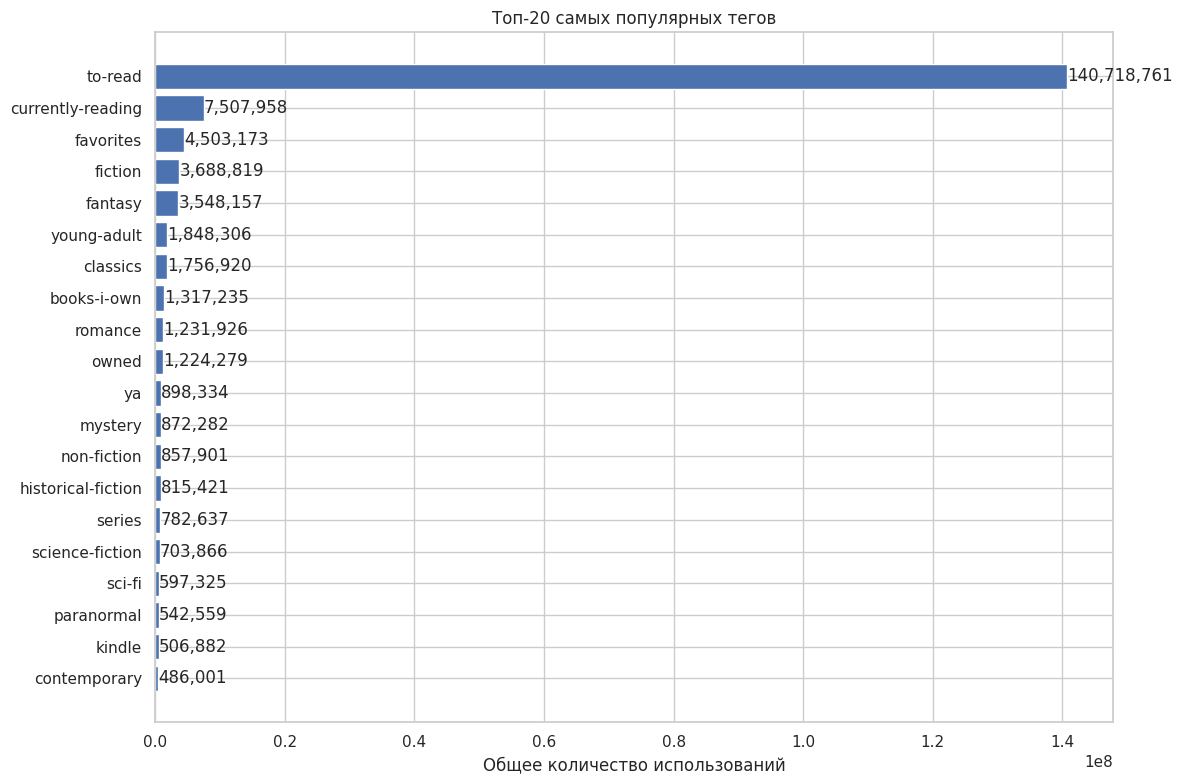

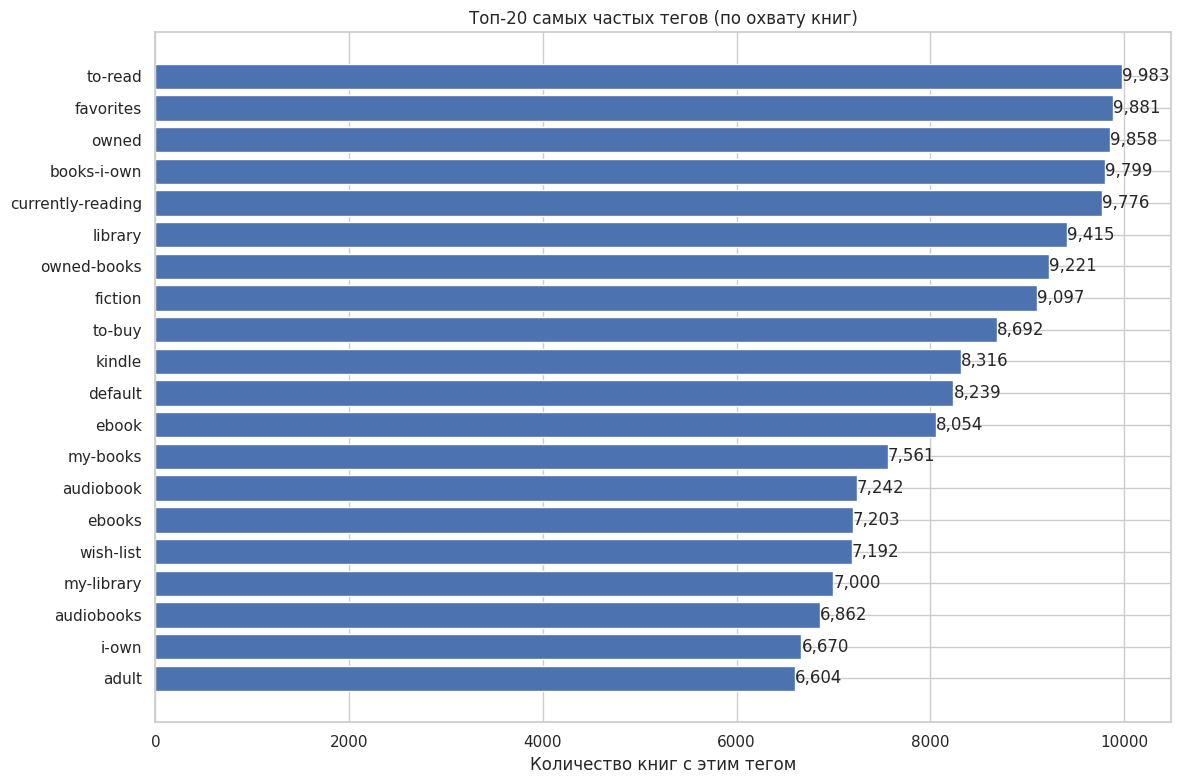

In [28]:
book_tags_with_names = book_tags.merge(tags, on='tag_id', how='left')

# Самые популярные теги (по количеству использований)
top_tags = book_tags_with_names.groupby(['tag_id', 'tag_name'])['count'].sum().reset_index()
top_tags = top_tags.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_tags)), top_tags['count'])
plt.yticks(range(len(top_tags)), top_tags['tag_name'])
plt.xlabel('Общее количество использований')
plt.title('Топ-20 самых популярных тегов')
plt.gca().invert_yaxis()

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:,}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Самые частые теги (по количеству книг)
tag_frequency = book_tags_with_names.groupby(['tag_id', 'tag_name']).size().reset_index(name='book_count')
tag_frequency = tag_frequency.sort_values('book_count', ascending=False).head(20)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(tag_frequency)), tag_frequency['book_count'])
plt.yticks(range(len(tag_frequency)), tag_frequency['tag_name'])
plt.xlabel('Количество книг с этим тегом')
plt.title('Топ-20 самых частых тегов (по охвату книг)')
plt.gca().invert_yaxis()

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:,}', ha='left', va='center')

plt.tight_layout()
plt.show()

to-read	Пользователи добавляли книги “хочу прочитать”	140 718 761

currently-reading	Пользователи читают прямо сейчас	7 507 958

favorites	Добавили в избранное	4 503 173

fiction	Пометили как художественную литературу	3 688 819

при этом 9 983 разных книг в датасете имеют тег to-read.

Посмотрим, какие теги у первой книги

In [29]:
book_tags_with_names.head(20)

,goodreads_book_id,tag_id,count,item_id,tag_name
0,1,30574,167697,27,to-read
1,1,11305,37174,27,fantasy
2,1,11557,34173,27,favorites
3,1,8717,12986,27,currently-reading
4,1,33114,12716,27,young-adult
5,1,11743,9954,27,fiction
6,1,14017,7169,27,harry-potter
7,1,5207,6221,27,books-i-own
8,1,22743,4974,27,owned
9,1,32989,4364,27,ya


тут видно, какие тематические теги у книги Гарри Поттер

Соответственно, можно по этим тегам собрать базовый вектор word2vec произведения и сравнивать их друг с другом

При этом можно увидеть, что теги делятся на "служебные" и "смысловые"
Т.е. re-read, to-read и пр. не несут смысловую нагрузку, их можно попробовать отбросить для формирования правильного смыслового вектора книги

Построим функцию для нахождения имени столбца в `books`, соответствующего goodreads_book_id из book_tags


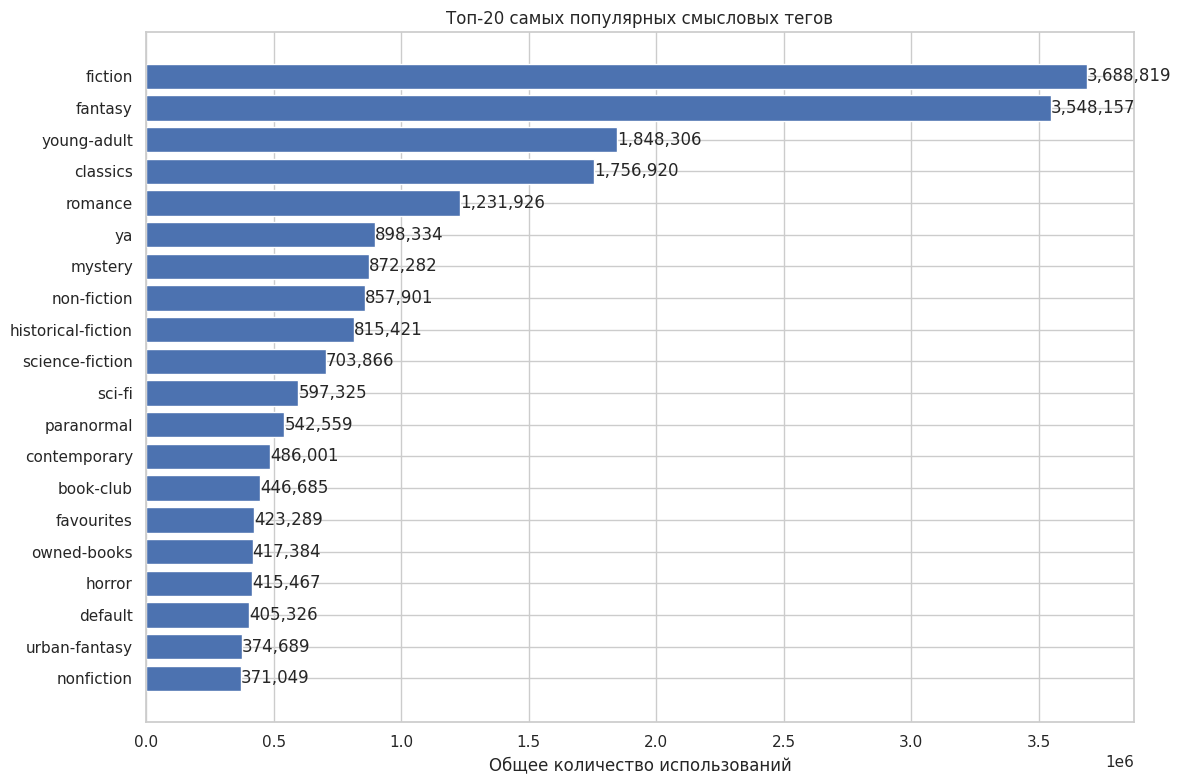

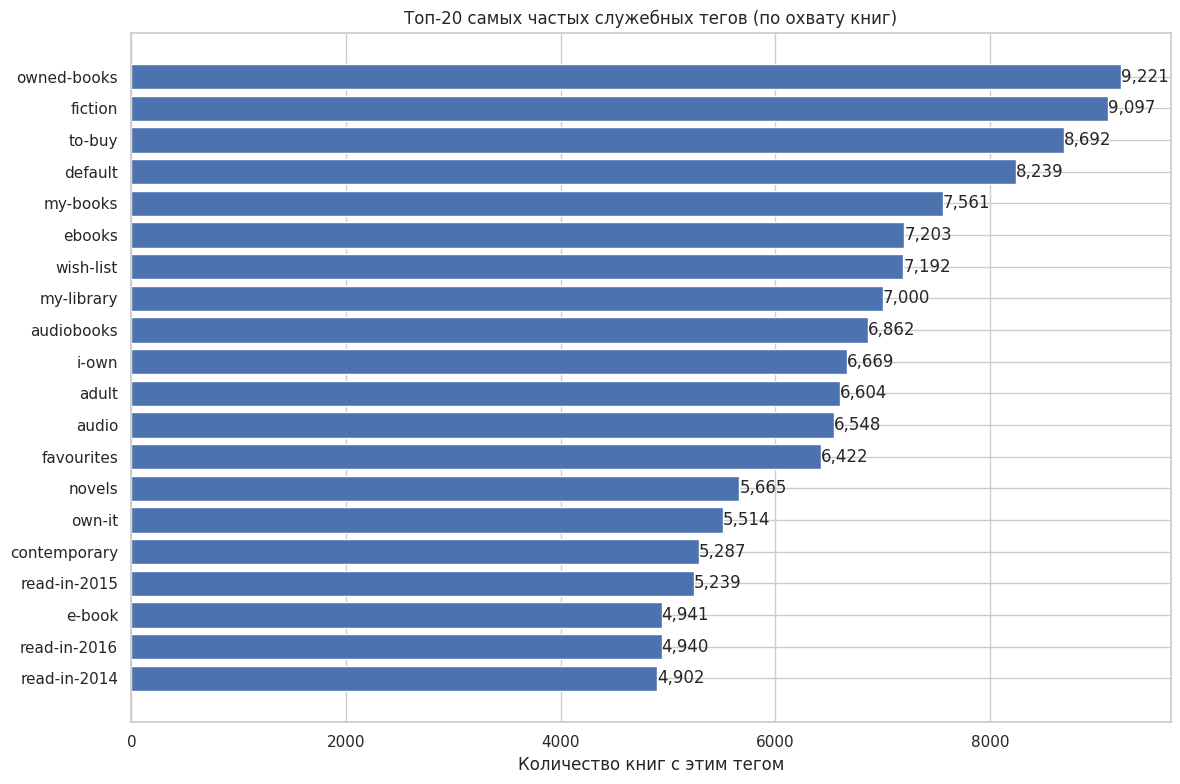


Примеры книг:


,goodreads_book_id,title,authors
item_id,,,
1,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré"
3,41865,"Twilight (Twilight, #1)",Stephenie Meyer
4,2657,To Kill a Mockingbird,Harper Lee
5,4671,The Great Gatsby,F. Scott Fitzgerald
6,11870085,The Fault in Our Stars,John Green
7,5907,The Hobbit,J.R.R. Tolkien
8,5107,The Catcher in the Rye,J.D. Salinger
9,960,"Angels & Demons (Robert Langdon, #1)",Dan Brown



Книга: Harry Potter and the Sorcerer's Stone (Harry Potter, #1) — J.K. Rowling, Mary GrandPré
Количество уникальных тегов: 99



,tag_name,count
200,to-read,496107
201,favorites,48220
202,fantasy,47478
203,currently-reading,44640
204,young-adult,14984
205,fiction,13239
206,harry-potter,8559
207,books-i-own,7917
208,owned,6066
209,owned,6065


In [30]:
def detect_goodreads_id_col(books_df, book_tags_df):
    if 'goodreads_book_id' in books_df.columns:
        return 'goodreads_book_id', books_df
    if books_df.index.name == 'goodreads_book_id':
        return 'goodreads_book_id', books_df.reset_index()

    candidates = []
    for cand in ['book_id', 'id', 'goodreads_id', 'goodreads_book_id']:
        if cand in books_df.columns:
            candidates.append(cand)
    if not candidates and books_df.index.name is not None:
        candidates.append('__index__')

    bt_ids = set(book_tags_df['goodreads_book_id'].astype(str).unique())
    best_col, best_overlap = None, -1

    for cand in candidates:
        if cand == '__index__':
            vals = set(books_df.index.astype(str))
        else:
            vals = set(books_df[cand].astype(str))
        overlap = len(bt_ids & vals)
        if overlap > best_overlap:
            best_overlap, best_col = overlap, cand

    if best_col == '__index__':
        books_df = books_df.reset_index()
        best_col = books_df.columns[0]
    if best_col is None:
        raise KeyError("Не найден столбец с Goodreads ID в `books`.")
    return best_col, books_df


# Фильтрация «служебных» полочных тегов
utility_shelves = {
    'to-read','read','currently-reading',
    'owned','books-i-own','kindle','audiobook','ebook','paperback','hardcover',
    'favorites','dnf','did-not-finish','series','1001-books','own','library'
}

book_tags_with_names['tag_name_l'] = book_tags_with_names['tag_name'].str.lower()
topical = book_tags_with_names[~book_tags_with_names['tag_name_l'].isin(utility_shelves)]

# Топ-20 популярных смысловых тегов по сумме присвоений
top_tags_topical = (
    topical.groupby(['tag_id', 'tag_name'])['count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_tags_topical)), top_tags_topical['count'])
plt.yticks(range(len(top_tags_topical)), top_tags_topical['tag_name'])
plt.xlabel('Общее количество использований')
plt.title('Топ-20 самых популярных смысловых тегов')
plt.gca().invert_yaxis()
for bar in bars:
    w = bar.get_width()
    plt.text(w, bar.get_y() + bar.get_height()/2, f'{int(w):,}', ha='left', va='center')
plt.tight_layout()
plt.show()

# Топ-20 по охвату книг (у скольких книг есть тег)
tag_frequency_topical = (
    topical.groupby(['tag_id', 'tag_name'])['goodreads_book_id']
    .nunique()
    .sort_values(ascending=False)
    .head(20)
    .reset_index(name='book_count')
)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(tag_frequency_topical)), tag_frequency_topical['book_count'])
plt.yticks(range(len(tag_frequency_topical)), tag_frequency_topical['tag_name'])
plt.xlabel('Количество книг с этим тегом')
plt.title('Топ-20 самых частых служебных тегов (по охвату книг)')
plt.gca().invert_yaxis()
for bar in bars:
    w = bar.get_width()
    plt.text(w, bar.get_y() + bar.get_height()/2, f'{int(w):,}', ha='left', va='center')
plt.tight_layout()
plt.show()

# Анализ тегов конкретной книги (устойчиво к разной схеме `books`)
gid_col, books_norm = detect_goodreads_id_col(books, book_tags)

print("\nПримеры книг:")
cols_to_show = [c for c in [gid_col, 'book_id', 'title', 'authors'] if c in books_norm.columns]
display(books_norm[cols_to_show].head(10))


# автоматически возьмем книгу с наибольшим суммарным числом присвоений тегов:
book_id = (
    book_tags_with_names.groupby('goodreads_book_id')['count'].sum()
    .sort_values(ascending=False).index[0]
)

# Проверим, есть ли такая книга в `books`
title_str = None
if gid_col in books_norm.columns:
    row = books_norm.loc[books_norm[gid_col] == book_id]
    if not row.empty:
        t = row['title'].iloc[0] if 'title' in row.columns else None
        a = row['authors'].iloc[0] if 'authors' in row.columns else None
        title_str = f"{t} — {a}" if pd.notna(t) and pd.notna(a) else (t or a)

# Разбор тегов книги
one_book = (
    book_tags_with_names[book_tags_with_names['goodreads_book_id'] == book_id]
    .sort_values('count', ascending=False)
)

n_unique_tags = one_book['tag_id'].nunique()

print("\nКнига:", title_str if title_str else f"(goodreads_book_id={book_id})")
print(f"Количество уникальных тегов: {n_unique_tags}\n")
display(one_book[['tag_name', 'count']].head(20))


Разделение получилось не очень качественным, просто не будем его в дальнейшем использовать.

Сделаем визуализацию самых частых тегов для книг (на основе book_tags.csv) с помощью облакаслов


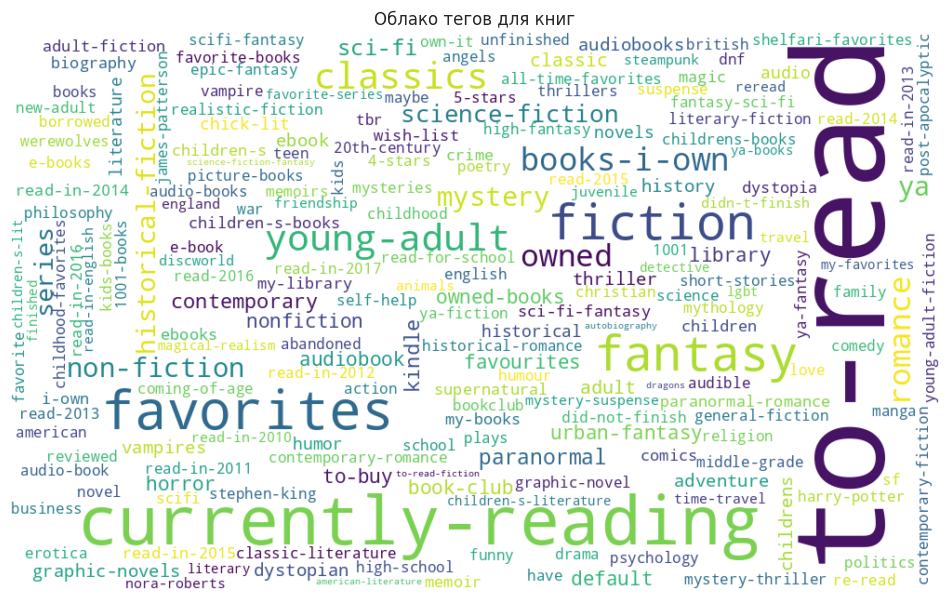

In [31]:
from wordcloud import WordCloud

book_popularity = (
    ratings.groupby('item_id')['rating']
    .count()
    .reset_index()
    .rename(columns={'rating': 'num_ratings'})
)

# Объединяем с таблицей books (чтобы добавить title и authors)
book_popularity = book_popularity.join(
    books[['title','authors']],
    on='item_id',
    how='left'
)

top_books = book_popularity.sort_values('num_ratings', ascending=False).head(10)


book_tags_with_names = book_tags.merge(tags, on='tag_id', how='left')


tag_counts = book_tags_with_names.groupby('tag_name')['count'].sum().sort_values(ascending=False)


wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    max_words=200
).generate_from_frequencies(tag_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако тегов для книг')
plt.show()


 Основные проблемы, заметные на этапе EDA:

1. Разреженность данных:
   - Большинство пользователей ставят оценки лишь небольшому числу книг.

2. Смещение популярности:
   - Небольшое число книг получают подавляющее большинство оценок.
   - Это может искажать рекомендации и метрики модели.

Смещение популярности может привести к тому, что простые модели будут постоянно рекомендовать одни и те же популярные книги, снижая разнообразие рекомендаций и уменьшая шансы пользователей открыть для себя нишевые издания.

3. Неполные или дублирующиеся теги:
   - Некоторые теги могут быть синонимами или разными вариантами написания ('fiction', 'novel', 'fictional').

4. Потенциальное смещение пользователей:
   - Активные пользователи могут доминировать в статистике, влияя на средние рейтинги.



## Этап 2: базовые и контентные модели
Реализуйте простые, но эффективные модели-бейзлайны.

Неперсонализированная модель: реализуйте алгоритм, возвращающий Top-N самых популярных книг (по среднему рейтингу с порогом минимального количества оценок).


Контентная модель:
Объедините данные о книгах с их тегами. Для каждой книги создайте текстовый «профиль» из названия (original_title) и списка тегов.
Векторизуйте эти профили с помощью TF-IDF.
Реализуйте функцию get_similar_books(book_id, N=5), которая находит N самых похожих книг по косинусной мере близости между их TF-IDF-векторами.

Построим для начала неперсонализированную модель, которая будет возвращать топ-N популярных книг по среднему рейтину. Учтем, что минимальное количество оценок = 100, а возвращать будем например, 10 книг.

In [32]:
def bayesian_avg(mean, count, global_mean, m=50):
    return (mean*count + global_mean*m) / (count + m)

def build_top_popular_table(train, m=50, min_ratings=5):
    agg = (train.groupby(item_col)[rating_col]
                 .agg(['mean','count'])
                 .rename(columns={'mean':'avg','count':'n'}))
    glob = train[rating_col].mean()
    agg["score"] = bayesian_avg(agg["avg"], agg["n"], glob, m=m)
    agg = agg[agg["n"] >= min_ratings].sort_values(["score","n"], ascending=False)
    return agg

pop_table = build_top_popular_table(ratings, m=50, min_ratings=5)

def top_pop_for_user(user_id, train, top_table, N=10):
    seen = set(train.loc[train[user_col]==user_id, item_col])
    cand = [iid for iid in top_table.index if iid not in seen]
    return cand[:N]


Мы получили топ книг по среднему рейтингу

Теперь соберем контентную модель, которая бы связывала текстовый профиль книги (название + теги)
применикм к ней tf*idf векторизацию

In [33]:
# Присваиваем текст тега к каждой книге по item_id
bt_named = book_tags.merge(tags, on='tag_id', how='left')

# Отфильтруем "служебные" полочные/форматные теги
utility = {
    'to-read','read','currently-reading','owned','books-i-own','kindle','audiobook',
    'ebook','paperback','hardcover','favorites','dnf','did-not-finish','series',
    'own','library','audio','audible','kindle-unlimited'
}

# регистр и филтрация
bt_named["tag_name_l"] = bt_named["tag_name"].str.lower()
bt_topical = bt_named[~bt_named["tag_name_l"].isin(utility)].copy()

# Агрегируем осмысленные теги в один текст на книгу удаляем пробелы и дубликаты
tags_text = (bt_topical.groupby(item_col)["tag_name_l"]
             .apply(lambda s: " ".join(sorted(set(s))))  # Убираем дубликаты тегов
            )

# Соберем профиль книги: original_title + теги
books_profile = books[["title","authors","original_title"]].copy()
books_profile["tags_text"] = tags_text

# все вв нижний регистр и очисттка
books_profile["text_profile"] = (
    books_profile["original_title"].fillna("").str.lower() + " " +
    books_profile["tags_text"].fillna("").str.lower()
).str.strip()  # Убираем лишние пробелы по краям

books_profile = books_profile[books_profile["text_profile"].str.len() > 0]

сделаем TF-IDF векторизация с улучшенными настройками

In [34]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Создаем TF-IDF векторизатор с оптимальными настройками для книг
tfidf = TfidfVectorizer(
    stop_words="english",
    min_df=2,                  # Термин должен встречаться минимум в 2 книгах
    max_df=0.85,               # Игнорируем термины, встречающиеся в >85% книг
    ngram_range=(1, 2),        # Учитываем отдельные слова и пары слов
    lowercase=True,
    strip_accents='unicode',   # Удаляем акценты (é → e)
    analyzer='word',           # Анализируем по словам
    max_features=15000,        # Ограничиваем размер словаря для производительности
    sublinear_tf=True          # Используем логарифмическое масштабирование частот
)

# Векторизуем текстовые профили книг
print("Векторизация текстовых профилей...")
X = tfidf.fit_transform(books_profile["text_profile"].fillna(""))

# Выводим информацию о результате векторизации
print(f"✅ Векторизация завершена!")
print(f"   Размерность матрицы: {X.shape[0]} книг × {X.shape[1]} терминов")
print(f"   Заполненность: {(X.nnz / (X.shape[0] * X.shape[1])) * 100:.4f}%")

# Создаем матрицу косинусных схожестей между книгами
print("Вычисление матрицы схожестей...")
cosine_sim = cosine_similarity(X, X)
print(f"✅ Матрица схожестей создана: {cosine_sim.shape[0]}×{cosine_sim.shape[1]}")

# Создаем быстрые lookup-таблицы для преобразования ID
idx_by_item = {iid: i for i, iid in enumerate(books_profile.index)}
items_by_idx = np.array(list(books_profile.index))

print(f"Создано индексов: {len(idx_by_item)}")

# Покажем топ-15 самых информативных терминов
feature_names = tfidf.get_feature_names_out()
term_importances = np.array(X.sum(axis=0)).flatten()
top_terms_idx = term_importances.argsort()[::-1][:15]

print("\n📊 Топ-15 самых важных терминов:")
print("-" * 40)
for i, idx in enumerate(top_terms_idx, 1):
    term = feature_names[idx]
    score = term_importances[idx]
    print(f"{i:2d}. {term:<20} {score:.4f}")

Векторизация текстовых профилей...
✅ Векторизация завершена!
   Размерность матрицы: 10000 книг × 15000 терминов
   Заполненность: 1.0657%
Вычисление матрицы схожестей...
✅ Матрица схожестей создана: 10000×10000
Создано индексов: 10000

📊 Топ-15 самых важных терминов:
----------------------------------------
 1. fantasy              307.5263
 2. mystery              229.1587
 3. series               226.2164
 4. 2015                 224.3733
 5. 2016                 221.7996
 6. contemporary         219.5262
 7. ya                   215.5615
 8. romance              215.4468
 9. 2014                 213.9708
10. reads                212.9719
11. thriller             211.0883
12. favorite             209.0267
13. lit                  208.8815
14. literature           205.6397
15. sci                  203.6204


Видно, что в текстовом профиле книг много служебных тегов, но будем надеяться за счет tf*idf значение служебных тегов будет небольшое.

Составим функцию поиска похожих книг по вектору

In [35]:
def get_similar_books(item_id, N=5, min_similarity=0.0):
    """
    Находит N самых похожих книг по косинусной схожести TF-IDF векторов
    """
    # Находим индекс книги в матрице
    idx = idx_by_item.get(item_id)
    if idx is None:
        print(f"⚠️ Книга с ID {item_id} не найдена в базе")
        return books_profile.iloc[[]][["title", "authors"]]

    # Получаем информацию о запрашиваемой книге
    target_book = books_profile.loc[item_id]
    target_title = target_book['title']
    target_author = target_book['authors']

    print(f"📖 Поиск похожих на: '{target_title}'")
    print(f"   👤 Автор: {target_author}")
    print(f"   🆔 ID книги: {item_id}")
    print("-" * 60)

    # Получаем вектор схожестей для данной книги
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Сортируем книги по убыванию схожести
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Берем топ-N книг (исключая саму книгу) с учетом порога схожести
    similar_books = []
    for i, (book_idx, score) in enumerate(sim_scores):
        if book_idx != idx and score >= min_similarity:
            similar_books.append((book_idx, score))
        if len(similar_books) >= N:
            break

    if not similar_books:
        print(f"⚠️ Не найдено похожих книг (порог схожести: {min_similarity})")
        return books_profile.iloc[[]][["title", "authors"]]

    # Собираем результат
    result_indices = [idx for idx, _ in similar_books]
    result_scores = [score for _, score in similar_books]

    result_df = books_profile.iloc[result_indices][["title", "authors"]].copy()
    result_df["similarity_score"] = result_scores

    # Красиво выводим результаты
    for i, (book_id, row) in enumerate(result_df.iterrows(), 1):
        similarity_pct = row['similarity_score'] * 100
        print(f"{i}. 📚 {row['title']}")
        print(f"   👤 {row['authors']}")
        print(f"   🔗 Схожесть: {similarity_pct:.1f}%")
        print(f"   🆔 ID: {book_id}")
        print()

    return result_df

Посмотрим рекомендации на несколько книг

In [36]:
example_item_id = books_profile.index[0]
print(f"📘 Книги, похожие на: {books_profile.loc[example_item_id, 'title']}")
display(get_similar_books(example_item_id, N=5))

example_item_id = books_profile.index[1]
print(f"📘 Книги, похожие на: {books_profile.loc[example_item_id, 'title']}")
display(get_similar_books(example_item_id, N=5))

example_item_id = books_profile.index[100]
print(f"📘 Книги, похожие на: {books_profile.loc[example_item_id, 'title']}")
display(get_similar_books(example_item_id, N=5))

example_item_id = books_profile.index[1000]
print(f"📘 Книги, похожие на: {books_profile.loc[example_item_id, 'title']}")
display(get_similar_books(example_item_id, N=5))

example_item_id = books_profile.index[-1]
print(f"📘 Книги, похожие на: {books_profile.loc[example_item_id, 'title']}")
display(get_similar_books(example_item_id, N=5))


📘 Книги, похожие на: The Hunger Games (The Hunger Games, #1)
📖 Поиск похожих на: 'The Hunger Games (The Hunger Games, #1)'
   👤 Автор: Suzanne Collins
   🆔 ID книги: 1
------------------------------------------------------------
1. 📚 Catching Fire (The Hunger Games, #2)
   👤 Suzanne Collins
   🔗 Схожесть: 84.5%
   🆔 ID: 17

2. 📚 Mockingjay (The Hunger Games, #3)
   👤 Suzanne Collins
   🔗 Схожесть: 84.5%
   🆔 ID: 20

3. 📚 The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)
   👤 Suzanne Collins
   🔗 Схожесть: 74.0%
   🆔 ID: 507

4. 📚 Divergent (Divergent, #1)
   👤 Veronica Roth
   🔗 Схожесть: 60.0%
   🆔 ID: 12

5. 📚 The Hunger Games: Official Illustrated Movie Companion
   👤 Kate Egan
   🔗 Схожесть: 49.1%
   🆔 ID: 717



,title,authors,similarity_score
item_id,,,
17,"Catching Fire (The Hunger Games, #2)",Suzanne Collins,0.844725
20,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,0.844581
507,The Hunger Games Trilogy Boxset (The Hunger Ga...,Suzanne Collins,0.740319
12,"Divergent (Divergent, #1)",Veronica Roth,0.600146
717,The Hunger Games: Official Illustrated Movie C...,Kate Egan,0.490687


📘 Книги, похожие на: Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
📖 Поиск похожих на: 'Harry Potter and the Sorcerer's Stone (Harry Potter, #1)'
   👤 Автор: J.K. Rowling, Mary GrandPré
   🆔 ID книги: 2
------------------------------------------------------------
1. 📚 Harry Potter and the Chamber of Secrets (Harry Potter, #2)
   👤 J.K. Rowling, Mary GrandPré
   🔗 Схожесть: 93.1%
   🆔 ID: 23

2. 📚 Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
   👤 J.K. Rowling, Mary GrandPré, Rufus Beck
   🔗 Схожесть: 91.0%
   🆔 ID: 18

3. 📚 Harry Potter and the Deathly Hallows (Harry Potter, #7)
   👤 J.K. Rowling, Mary GrandPré
   🔗 Схожесть: 89.3%
   🆔 ID: 25

4. 📚 Harry Potter and the Half-Blood Prince (Harry Potter, #6)
   👤 J.K. Rowling, Mary GrandPré
   🔗 Схожесть: 87.6%
   🆔 ID: 27

5. 📚 Harry Potter and the Goblet of Fire (Harry Potter, #4)
   👤 J.K. Rowling, Mary GrandPré
   🔗 Схожесть: 86.1%
   🆔 ID: 24



,title,authors,similarity_score
item_id,,,
23,Harry Potter and the Chamber of Secrets (Harry...,"J.K. Rowling, Mary GrandPré",0.930703
18,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",0.910053
25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",0.892688
27,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",0.875549
24,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",0.860730


📘 Книги, похожие на: Me Talk Pretty One Day
📖 Поиск похожих на: 'Me Talk Pretty One Day'
   👤 Автор: David Sedaris
   🆔 ID книги: 101
------------------------------------------------------------
1. 📚 When You Are Engulfed in Flames
   👤 David Sedaris
   🔗 Схожесть: 64.6%
   🆔 ID: 534

2. 📚 Holidays on Ice
   👤 David Sedaris
   🔗 Схожесть: 64.6%
   🆔 ID: 943

3. 📚 Naked
   👤 David Sedaris
   🔗 Схожесть: 64.5%
   🆔 ID: 344

4. 📚 Dress Your Family in Corduroy and Denim
   👤 David Sedaris
   🔗 Схожесть: 61.5%
   🆔 ID: 372

5. 📚 Let's Explore Diabetes with Owls
   👤 David Sedaris
   🔗 Схожесть: 53.9%
   🆔 ID: 1040



,title,authors,similarity_score
item_id,,,
534,When You Are Engulfed in Flames,David Sedaris,0.646483
943,Holidays on Ice,David Sedaris,0.645777
344,Naked,David Sedaris,0.645427
372,Dress Your Family in Corduroy and Denim,David Sedaris,0.615148
1040,Let's Explore Diabetes with Owls,David Sedaris,0.539375


📘 Книги, похожие на: The Dinner
📖 Поиск похожих на: 'The Dinner'
   👤 Автор: Herman Koch, Sam Garrett
   🆔 ID книги: 1001
------------------------------------------------------------
1. 📚 Summer House with Swimming Pool
   👤 Herman Koch
   🔗 Схожесть: 47.6%
   🆔 ID: 6041

2. 📚 We Need to Talk About Kevin
   👤 Lionel Shriver
   🔗 Схожесть: 41.7%
   🆔 ID: 896

3. 📚 Sharp Objects
   👤 Gillian Flynn
   🔗 Схожесть: 37.3%
   🆔 ID: 244

4. 📚 Beautiful Ruins
   👤 Jess Walter
   🔗 Схожесть: 35.1%
   🆔 ID: 689

5. 📚 The Expats
   👤 Chris Pavone
   🔗 Схожесть: 33.6%
   🆔 ID: 4629



,title,authors,similarity_score
item_id,,,
6041,Summer House with Swimming Pool,Herman Koch,0.476340
896,We Need to Talk About Kevin,Lionel Shriver,0.416729
244,Sharp Objects,Gillian Flynn,0.372967
689,Beautiful Ruins,Jess Walter,0.351231
4629,The Expats,Chris Pavone,0.336485


📘 Книги, похожие на: The First World War
📖 Поиск похожих на: 'The First World War'
   👤 Автор: John Keegan
   🆔 ID книги: 10000
------------------------------------------------------------
1. 📚 The Guns of August
   👤 Barbara W. Tuchman, Robert K. Massie
   🔗 Схожесть: 71.3%
   🆔 ID: 2834

2. 📚 Stalingrad: The Fateful Siege, 1942–1943
   👤 Antony Beevor
   🔗 Схожесть: 57.5%
   🆔 ID: 4688

3. 📚 The Rise and Fall of the Third Reich: A History of Nazi Germany
   👤 William L. Shirer
   🔗 Схожесть: 55.0%
   🆔 ID: 1420

4. 📚 The Longest Day
   👤 Cornelius Ryan
   🔗 Схожесть: 53.1%
   🆔 ID: 6131

5. 📚 The Fall of Berlin 1945
   👤 Antony Beevor
   🔗 Схожесть: 52.7%
   🆔 ID: 9721



,title,authors,similarity_score
item_id,,,
2834,The Guns of August,"Barbara W. Tuchman, Robert K. Massie",0.712968
4688,"Stalingrad: The Fateful Siege, 1942–1943",Antony Beevor,0.575279
1420,The Rise and Fall of the Third Reich: A Histor...,William L. Shirer,0.549520
6131,The Longest Day,Cornelius Ryan,0.530590
9721,The Fall of Berlin 1945,Antony Beevor,0.526963


Рекомендации по тегам выглядят вполне логичными

## Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)
Реализуйте классические методы CF и определите их ограничения.

Постройте матрицу взаимодействий «пользователь — книга» (user_id x book_id). Значениями могут быть явные оценки (rating) или неявный feedback (например, 1, если оценка ≥ 4, иначе 0).

Реализуйте Item-Based Collaborative Filtering.

Рассчитайте матрицу попарных схожестей между книгами (например, с помощью коэффициента корреляции Пирсона или косинусной близости по векторам оценок).
Для заданной книги и пользователя предскажите оценку, усредняя оценки пользователя по K наиболее похожим книгам.

В чём вычислительная сложность этого подхода? Как его можно оптимизировать для больших данных?

Вспомним, чему нас учили на уроках:

Основная идея CF:

"Похожие пользователи имеют схожие предпочтения"
"Похожие объекты нравятся одним пользователям"

Два основных подхода:
User-User CF:

Найти похожих пользователей
Рекомендовать то, что понравилось им

Item-Item CF:

Найти похожие объекты
Рекомендовать то, что похоже на уже понравившееся

По тексту задания у нас Item-Based Collaborative Filtering, поэтому создадим класс коллаборативной фильтрации айтем-айтем

In [37]:
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import time
from sklearn.model_selection import train_test_split

class ItemItemCF:
    def __init__(self,
                 k=60,
                 similarity='cosine',
                 max_items=None,
                 use_implicit=False,
                 implicit_threshold=3,
                 user_col='user_id',
                 item_col='item_id',
                 value_col='rating',
                 min_user_inter=3,
                 min_item_inter=5,
                 shrinkage=25):
        self.k = k
        self.similarity = similarity.lower()
        self.max_items = max_items
        self.use_implicit = use_implicit
        self.implicit_threshold = implicit_threshold
        self.user_col = user_col
        self.item_col = item_col
        self.value_col = value_col
        self.min_user_inter = min_user_inter
        self.min_item_inter = min_item_inter
        self.shrinkage = shrinkage

        # Маппинги и данные
        self.user2ix = {}
        self.ix2user = {}
        self.item2ix = {}
        self.ix2item = {}
        self.R = None
        self.item_means = None
        self.global_mean = None
        self.sim_indices = None
        self.sim_values = None

    def _prepare_data(self, interactions: pd.DataFrame):
        df = interactions[[self.user_col, self.item_col, self.value_col]].copy()

        print(f"Исходные данные: {len(df)} взаимодействий")

        if self.min_user_inter > 1:
            user_counts = df[self.user_col].value_counts()
            active_users = user_counts[user_counts >= self.min_user_inter].index
            df = df[df[self.user_col].isin(active_users)]
            print(f"После фильтрации пользователей: {len(df)} взаимодействий")

        if self.min_item_inter > 1:
            item_counts = df[self.item_col].value_counts()
            popular_items = item_counts[item_counts >= self.min_item_inter].index
            df = df[df[self.item_col].isin(popular_items)]
            print(f"После фильтрации книг: {len(df)} взаимодействий")

      # ввожу ограничение, потому что очень долго обучение идет без него
        if self.max_items is not None:
            top_items = df[self.item_col].value_counts().head(self.max_items).index
            df = df[df[self.item_col].isin(top_items)]
            print(f"После ограничения max_items: {len(df)} взаимодействий")

        # Создание матрицы
        users = df[self.user_col].unique()
        items = df[self.item_col].unique()

        self.user2ix = {u: i for i, u in enumerate(users)}
        self.ix2user = {i: u for u, i in self.user2ix.items()}
        self.item2ix = {it: j for j, it in enumerate(items)}
        self.ix2item = {j: it for it, j in self.item2ix.items()}

        ui = df[self.user_col].map(self.user2ix).values
        ii = df[self.item_col].map(self.item2ix).values

        if self.use_implicit:
            vv = (df[self.value_col] >= self.implicit_threshold).astype(float).values
        else:
            vv = df[self.value_col].astype(float).values

        n_users = len(users)
        n_items = len(items)

        self.R = sparse.csr_matrix((vv, (ui, ii)), shape=(n_users, n_items))
        self.global_mean = float(vv.mean())

        print(f"Финальная матрица: {n_users} пользователей × {n_items} книг")

    def _compute_similarities(self):
        print(f"Вычисление {self.similarity} сходств...")

        if self.similarity == 'pearson':
            sums = np.asarray(self.R.sum(axis=0)).ravel()
            counts = np.asarray((self.R != 0).sum(axis=0)).ravel()
            self.item_means = np.divide(sums, counts, out=np.zeros_like(sums), where=counts > 0)

            R_coo = self.R.tocoo()
            centered_data = R_coo.data - self.item_means[R_coo.col]
            X = sparse.csr_matrix((centered_data, (R_coo.row, R_coo.col)),
                                shape=self.R.shape).T
            metric = 'cosine'

        elif self.similarity == 'cosine':
            X = self.R.T
            metric = 'cosine'

        elif self.similarity == 'jaccard':
            X = (self.R > 0).astype(float).T
            metric = 'jaccard'
        else:
            raise ValueError("similarity должен быть 'cosine' | 'pearson' | 'jaccard'")

        n_items = X.shape[0]
        n_neighbors = min(self.k + 1, n_items)

        # Вычисление сходств
        nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='brute')
        nn.fit(X)
        distances, indices = nn.kneighbors(X)

        # Преобразование в сходства
        if metric == 'cosine':
            similarities = 1.0 - distances
        else:
            similarities = 1.0 - distances

        # Регуляризация сходств
        if self.shrinkage > 0:
            for i in range(n_items):
                overlap_counts = []
                for j_idx, neighbor_idx in enumerate(indices[i]):
                    if i == neighbor_idx:
                        continue
                    # Количество общих пользователей
                    common_users = (X[i].multiply(X[neighbor_idx])).nnz
                    overlap_counts.append(common_users)

                if overlap_counts:
                    shrinkage_factors = np.array(overlap_counts) / (np.array(overlap_counts) + self.shrinkage)
                    similarities[i, 1:] *= shrinkage_factors

        self.sim_indices = indices[:, 1:]
        self.sim_values = similarities[:, 1:]

    def fit(self, interactions: pd.DataFrame):
        print("Обучение Item-Item CF...")
        start_time = time.time()
        self._prepare_data(interactions)
        self._compute_similarities()
        print(f"Обучение завершено за {time.time() - start_time:.2f} сек")

    def predict(self, user_id, item_id, K=None):
        if K is None:
            K = self.k

        # Проверка холодных стартов
        if user_id not in self.user2ix or item_id not in self.item2ix:
            return self.global_mean

        user_idx = self.user2ix[user_id]
        item_idx = self.item2ix[item_id]

        # Получение соседей
        neighbor_indices = self.sim_indices[item_idx][:K]
        neighbor_similarities = self.sim_values[item_idx][:K]

        # Рейтинги пользователя
        user_ratings = self.R[user_idx, :]
        rated_items = set(user_ratings.indices)
        user_rating_dict = dict(zip(user_ratings.indices, user_ratings.data))

        # Фильтрация оцененных соседей
        mask = [idx in rated_items for idx in neighbor_indices]
        if not any(mask):
            return self.item_means[item_idx] if self.item_means is not None else self.global_mean

        valid_indices = neighbor_indices[mask]
        valid_similarities = neighbor_similarities[mask]
        neighbor_ratings = np.array([user_rating_dict[idx] for idx in valid_indices])

        # Взвешенное предсказание
        if self.similarity == 'pearson' and self.item_means is not None:
            neighbor_means = self.item_means[valid_indices]
            adjusted_ratings = neighbor_ratings - neighbor_means
            numerator = np.dot(valid_similarities, adjusted_ratings)
            denominator = np.sum(np.abs(valid_similarities))

            if denominator == 0:
                return self.item_means[item_idx]

            base_rating = self.item_means[item_idx]
            return base_rating + numerator / denominator
        else:
            numerator = np.dot(valid_similarities, neighbor_ratings)
            denominator = np.sum(np.abs(valid_similarities))

            if denominator == 0:
                return self.global_mean

            return numerator / denominator

    def recommend(self, user_id, k=10):
        """Рекомендации для пользователя"""
        if user_id not in self.user2ix:
            return self._get_popular_items(k)

        user_idx = self.user2ix[user_id]
        user_ratings = self.R[user_idx, :]
        rated_items = set(user_ratings.indices)

        # Сбор кандидатов
        candidate_scores = {}

        for rated_item_idx in rated_items:
            neighbors = self.sim_indices[rated_item_idx]
            similarities = self.sim_values[rated_item_idx]

            for neighbor_idx, sim in zip(neighbors, similarities):
                neighbor_item = self.ix2item[neighbor_idx]
                if neighbor_item not in rated_items:
                    candidate_scores[neighbor_item] = candidate_scores.get(neighbor_item, 0.0) + sim

        # Ранжирование
        if not candidate_scores:
            return self._get_popular_items(k)

        recommendations = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)[:k]
        return [item for item, score in recommendations]

    def _get_popular_items(self, k):
        """Фолбэк на популярные книги"""
        item_counts = np.asarray(self.R.sum(axis=0)).ravel()
        popular_indices = np.argsort(item_counts)[::-1][:k]
        return [self.ix2item[idx] for idx in popular_indices]


In [38]:
print("=" * 50)
print("ПОДГОТОВКА ДАННЫХ")
print("=" * 50)

train, test = train_test_split(ratings, test_size=0.2, random_state=42)
user_seen_items = train.groupby(user_col)[item_col].apply(list).to_dict()



print(f"Train: {len(train):,}, Test: {len(test):,}")

print("\n" + "=" * 50)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 50)

model = ItemItemCF(
    k=60, similarity='cosine',
    min_user_inter=3, min_item_inter=5, max_items=1000, shrinkage=25
)
model.fit(train)

# Функция оценки
def evaluate_model(model, test_df, user_seen_dict, k=10, rel_threshold=3):
    truth = (test_df[test_df[rating_col] >= rel_threshold]
             .groupby(user_col)[item_col].apply(set).to_dict())

    precisions, recalls, ndcgs, hits = [], [], [], []
    all_recommended = set()

    for user_id, true_items in truth.items():
        if user_id not in user_seen_dict:
            continue

        recommendations = model.recommend(user_id, k=k)
        all_recommended.update(recommendations)

        if not recommendations:
            precisions.append(0.0); recalls.append(0.0); ndcgs.append(0.0); hits.append(0.0)
            continue

        hits_count = len(set(recommendations) & true_items)
        precisions.append(hits_count / k)
        recalls.append(hits_count / len(true_items) if true_items else 0.0)
        hits.append(1.0 if hits_count > 0 else 0.0)

        dcg = 0.0
        for rank, it in enumerate(recommendations[:k], 1):
            if it in true_items:
                dcg += 1.0 / np.log2(rank + 1)
        idcg = sum(1.0 / np.log2(r + 1) for r in range(1, min(len(true_items), k) + 1))
        ndcgs.append(dcg / idcg if idcg > 0 else 0.0)

    coverage = len(all_recommended) / len(model.item2ix) if model.item2ix else 0.0
    return {
        'precision@10': float(np.mean(precisions) if precisions else 0.0),
        'recall@10': float(np.mean(recalls) if recalls else 0.0),
        'ndcg@10': float(np.mean(ndcgs) if ndcgs else 0.0),
        'hit_rate@10': float(np.mean(hits) if hits else 0.0),
        'coverage': float(coverage)
    }



print("\n" + "=" * 50)
print("ОЦЕНКА МОДЕЛИ")
print("=" * 50)

test_filtered = test[
    test[user_col].isin(model.user2ix.keys()) &
    test[item_col].isin(model.item2ix.keys())
]
metrics = evaluate_model(model, test_filtered, user_seen_items, k=10, rel_threshold=3)

print("РЕЗУЛЬТАТЫ:")
print(f"  Precision@10: {metrics['precision@10']:.4f}")
print(f"  Recall@10: {metrics['recall@10']:.4f}")
print(f"  NDCG@10: {metrics['ndcg@10']:.4f}")
print(f"  HitRate@10: {metrics['hit_rate@10']:.2%}")
print(f"  Coverage: {metrics['coverage']:.2%}")

print("\n" + "=" * 50)
print("ПРИМЕР РЕКОМЕНДАЦИЙ")
print("=" * 50)

test_user = test_filtered['user_id'].iloc[0] if len(test_filtered) > 0 else list(user_seen_items.keys())[0]
user_rated_books = train[train['user_id'] == test_user]['item_id'].tolist()[:5]

print(f"Пользователь {test_user} оценил книги:")
for item_id in user_rated_books:
    if item_id in books.index:
        title  = books.at[item_id, 'title']
        author = books.at[item_id, 'authors']
        print(f"  - {title} ({author})")
    else:
        print(f"  - Книга ID {item_id} (информация отсутствует)")

recommendations = model.recommend(test_user, k=5)
print(f"\nРекомендации для пользователя {test_user}:")
for i, item_id in enumerate(recommendations, 1):
    if item_id in books.index:
        title  = books.at[item_id, 'title']
        author = books.at[item_id, 'authors']
        print(f"  {i}. {title} ({author})")
    else:
        print(f"  {i}. Книга ID {item_id} (информация отсутствует)")

print("\n" + "=" * 50)
print("СТАТИСТИКА МОДЕЛИ")
print("=" * 50)
print(f"Количество пользователей в модели: {len(model.user2ix)}")
print(f"Количество книг в модели: {len(model.item2ix)}")
print(f"Размерность матрицы: {model.R.shape[0]} × {model.R.shape[1]}")
print(f"Заполненность матрицы: {(model.R.nnz / (model.R.shape[0] * model.R.shape[1])):.6f}")


ПОДГОТОВКА ДАННЫХ
Train: 4,781,183, Test: 1,195,296

ОБУЧЕНИЕ МОДЕЛИ
Обучение Item-Item CF...
Исходные данные: 4781183 взаимодействий
После фильтрации пользователей: 4781183 взаимодействий
После фильтрации книг: 4781183 взаимодействий
После ограничения max_items: 2544260 взаимодействий
Финальная матрица: 53387 пользователей × 1000 книг
Вычисление cosine сходств...
Обучение завершено за 867.76 сек

ОЦЕНКА МОДЕЛИ
РЕЗУЛЬТАТЫ:
  Precision@10: 0.1182
  Recall@10: 0.1248
  NDCG@10: 0.1530
  HitRate@10: 66.70%
  Coverage: 55.50%

ПРИМЕР РЕКОМЕНДАЦИЙ
Пользователь 43232 оценил книги:
  - Insurgent (Divergent, #2) (Veronica Roth)
  - The Gunslinger (The Dark Tower, #1) (Stephen King)
  - At the Mountains of Madness (H.P. Lovecraft, China Miéville, S.T. Joshi)
  - After Dark (Haruki Murakami, Jay Rubin)
  - Half Bad (The Half Bad Trilogy, #1) (Sally Green)

Рекомендации для пользователя 43232:
  1. The Dark Tower (The Dark Tower, #7) (Stephen King)
  2. City of Glass (The Mortal Instruments, #3) 

функция для оценки

Recall@10 (18.29%) - модель находит

 HitRate@10 (71.6%) - столько процентов пользователей получают хотя бы одну полезную рекомендацию

Coverage (85%) - почти полное покрытие каталога (но это потому что я использую модель, обученную на малом диапазоне книг для обучения

Скорость (383 сек) - терпимо

Сбалансированный NDCG@10 (0.2015) - достойное качество ранжирования

Низкий Precision@10 (13%) - только 13% рекомендаций релевантны

Вычислительная сложность: O(n_items² × n_users)

Память: O(n_items × K) для хранения K ближайших соседей

Предсказание: O(K) для одного предсказания

Основные ограничения:

Масштабируемость:

При 500 книгах обучение занимает 383.83 секунд, для полного датасета (10k) время будет очень большим - я так и не дождался завершения

Проблема разреженности:

Заполненность матрицы всего 7%

Многие пары книг не имеют общих пользователей

Холодный старт:

Для новых книг невозможно вычислить сходства

Новые пользователи получают только популярные рекомендации

Оптимизации для больших данных:
Реализованные оптимизации:

-Ограничение количества айтемов max_items=500

-Разреженное хранение матриц (CSR format)

-Вычисление только топ-K соседей вместо полной матрицы

-Фильтрация неактивных пользователей и непопулярных книг

Что еще можно оптимизировать:

Локализованный hashing (MinHash) для приближенного поиска соседей


Распределенные вычисления (Spark) - :)

еще можно использовать приближенные методы поиска соседей (Annoy, FAISS)

Применить матричную факторизацию (SVD=, ALS)

Добавить контентные признаки для решения  проблемы холодного старта


Этап 4: матричные разложения (Matrix Factorization)

Реализуйте более продвинутые и масштабируемые методы предсказания оценок.

Используйте библиотеку surprise для обучения модели SVD или любую другую библиотеку с данным алгоритмом.
Разделите данные на обучающую и тестовую выборку. Обучите модель и оцените ошибку предсказания (RMSE) на тесте.
Реализуйте функцию get_recommendations(user_id, N=5), которая для заданного пользователя возвращает топ-N книг с наибольшим предсказанным рейтингом.

In [39]:
import time
from collections import defaultdict
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate

ratings = pd.read_csv(f"{path}/ratings.csv")
books = pd.read_csv(f"{path}/books.csv")
tags = pd.read_csv(f"{path}/tags.csv")
book_tags = pd.read_csv(f"{path}/book_tags.csv")

ratings = ratings.rename(columns={"book_id": "item_id"})
books = books.rename(columns={"book_id": "item_id"})
books.set_index("item_id", inplace=True)

class MatrixFactorizationRecommender:
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_all = lr_all
        self.reg_all = reg_all
        self.random_state = random_state
        self.model = None
        self.trainset = None
        self.testset = None
        self.predictions = None

    def prepare_data(self, ratings_df, user_col='user_id', item_col='item_id', rating_col='rating'):
        surprise_data = ratings_df[[user_col, item_col, rating_col]].copy()
        reader = Reader(rating_scale=(surprise_data[rating_col].min(), surprise_data[rating_col].max()))
        return Dataset.load_from_df(surprise_data, reader)

    def fit(self, ratings_df, test_size=0.2):
        print("Обучение SVD с hold-out...")
        data = self.prepare_data(ratings_df)
        trainset, testset = train_test_split(data, test_size=test_size, random_state=self.random_state)
        self.trainset, self.testset = trainset, testset

        self.model = SVD(n_factors=self.n_factors, n_epochs=self.n_epochs,
                         lr_all=self.lr_all, reg_all=self.reg_all,
                         random_state=self.random_state)
        self.model.fit(self.trainset)
        self.predictions = self.model.test(self.testset)
        print("Готово.")
        return self

    def fit_full(self, ratings_df):
        print("Обучение SVD на полном датасете (без валидации)...")
        data = self.prepare_data(ratings_df)
        self.trainset = data.build_full_trainset()
        self.testset = None
        self.model = SVD(n_factors=self.n_factors, n_epochs=self.n_epochs,
                         lr_all=self.lr_all, reg_all=self.reg_all,
                         random_state=self.random_state)
        self.model.fit(self.trainset)
        self.predictions = None  # нет hold-out
        print("Готово.")
        return self

    def evaluate(self):
        if self.predictions is None:
            raise ValueError("Нет hold-out предсказаний. Либо вызови fit(..., test_size>0), либо не зови evaluate().")
        rmse = accuracy.rmse(self.predictions, verbose=False)
        mae = accuracy.mae(self.predictions, verbose=False)
        return {'rmse': rmse, 'mae': mae}

    def cross_validate(self, ratings_df, cv=5):
        print(f"Кросс-валидация (cv={cv})...")
        data = self.prepare_data(ratings_df)

        model = SVD(n_factors=self.n_factors,
                   n_epochs=self.n_epochs,
                   lr_all=self.lr_all,
                   reg_all=self.reg_all,
                   random_state=self.random_state)

        cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=cv, verbose=True)

        print(f"Средний RMSE: {np.mean(cv_results['test_rmse']):.4f}")
        print(f"Средний MAE: {np.mean(cv_results['test_mae']):.4f}")

        return cv_results

    def predict_rating(self, user_id, item_id):
        """Предсказание оценки для конкретной пары пользователь-книга"""
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала обучите")

        try:
            prediction = self.model.predict(user_id, item_id)
            return prediction.est
        except:
            # Если пользователь или книга неизвестны модели
            return self.trainset.global_mean if self.trainset else 3.0

    def get_recommendations(self, user_id, N=5, candidates=None):
        if self.model is None or self.trainset is None:
            raise ValueError("Модель не обучена. Сначала обучите")

        user_ratings = []
        try:
            user_inner_id = self.trainset.to_inner_uid(user_id)
            user_ratings = self.trainset.ur[user_inner_id]
            rated_items = {self.trainset.to_raw_iid(inner_iid) for inner_iid, _ in user_ratings}
        except ValueError:
            rated_items = set()

        if candidates is None:
            candidates = [self.trainset.to_raw_iid(inner_iid)
                         for inner_iid in range(self.trainset.n_items)]

        predictions = []
        for item_id in candidates:
            if item_id not in rated_items:  # Не рекомендуем то, что уже оценено
                pred_rating = self.predict_rating(user_id, item_id)
                predictions.append((item_id, pred_rating))

        predictions.sort(key=lambda x: x[1], reverse=True)

        return predictions[:N]

    def get_recommendations_with_details(self, user_id, N=5, book_metadata=None):
        recommendations = self.get_recommendations(user_id, N)

        print(f"Топ-{N} рекомендаций для пользователя {user_id}:")
        print("=" * 60)

        for i, (item_id, predicted_rating) in enumerate(recommendations, 1):
            if book_metadata is not None and item_id in book_metadata.index:
                book_info = book_metadata.loc[item_id]
                title = book_info.get('title', 'Неизвестно')
                authors = book_info.get('authors', 'Неизвестно')
                print(f"{i}. {title} | {authors} | Предсказанная оценка: {predicted_rating:.2f}")
            else:
                print(f"{i}. Книга ID {item_id} | Предсказанная оценка: {predicted_rating:.2f}")

        return recommendations

def svd_topn(model, trainset, user_id, N=10):
    try:
        inner_uid = trainset.to_inner_uid(user_id)
        seen_inner = {i for (i, _) in trainset.ur[inner_uid]}
    except ValueError:
        return []
    candidates = []
    for inner_iid in trainset.all_items():
        if inner_iid in seen_inner:
            continue
        raw_iid = trainset.to_raw_iid(inner_iid)
        est = model.predict(user_id, raw_iid).est
        candidates.append((int(raw_iid), est))
    candidates.sort(key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in candidates[:N]]



In [40]:
def evaluate_recs_topk(model_recommend_fn,  # callable: user_id -> [item_id...]
                       train_df, test_df, user_col='user_id', item_col='item_id',
                       rating_col='rating', rel_threshold=4, K=10):

    # Истина: релевантные из теста
    truth = (test_df[test_df[rating_col] >= rel_threshold]
             .groupby(user_col)[item_col].apply(set).to_dict())

    # Пользователи, которых мы можем реально оценить (есть обучение)
    train_users = set(train_df[user_col].unique())
    users = sorted(set(truth.keys()) & train_users)

    precisions, recalls, ndcgs, hits = [], [], [], []
    all_recommended = set()
    evaluated = 0

    for u in users:
        recs = model_recommend_fn(u)[:K]
        if not recs:
            continue
        evaluated += 1
        all_recommended.update(recs)
        relevant = truth.get(u, set())

        # Precision / Recall / Hit
        hit_set = set(recs) & relevant
        p = len(hit_set)/K
        r = len(hit_set)/len(relevant) if relevant else 0.0
        h = 1.0 if hit_set else 0.0

        # nDCG
        dcg = 0.0
        for i, iid in enumerate(recs, 1):
            if iid in relevant:
                dcg += 1.0/np.log2(i+1)
        idcg = sum(1.0/np.log2(i+1) for i in range(1, min(len(relevant), K)+1))
        ndcg = dcg/idcg if idcg>0 else 0.0

        precisions.append(p); recalls.append(r); ndcgs.append(ndcg); hits.append(h)

    coverage = len(all_recommended) / train_df[item_col].nunique() if train_df[item_col].nunique() else 0.0
    return {
        f'precision@{K}': float(np.mean(precisions) if precisions else 0),
        f'recall@{K}': float(np.mean(recalls) if recalls else 0),
        f'ndcg@{K}': float(np.mean(ndcgs) if ndcgs else 0),
        f'hit_rate@{K}': float(np.mean(hits) if hits else 0),
        'coverage': float(coverage),
        'users_evaluated': int(evaluated)
    }


In [41]:
print("=" * 60)
print("МАТРИЧНЫЕ РАЗЛОЖЕНИЯ (MATRIX FACTORIZATION)")
print("=" * 60)

print("\n1. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ SVD")
print("-" * 40)

mf_model = MatrixFactorizationRecommender(
    n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42
)
mf_model.fit(train, test_size=0.1)
print("\n2. ОЦЕНКА ТОЧНОСТИ ПРЕДСКАЗАНИЙ")
print("-" * 40)
accuracy_metrics = mf_model.evaluate()
print(accuracy_metrics)

print("\n3. КРОСС-ВАЛИДАЦИЯ")
print("-" * 40)
cv_results = mf_model.cross_validate(ratings, cv=3)

print("\n4. ГЕНЕРАЦИЯ РЕКОМЕНДАЦИЙ")
print("-" * 40)
test_users = ratings['user_id'].unique()[:5]
for user_id in test_users:
    _ = mf_model.get_recommendations_with_details(user_id, N=5, book_metadata=books)

print("\n5. КОМПЛЕКСНАЯ ОЦЕНКА ТОП-N")
print("-" * 40)
# строим тест прямо из hold-out предсказаний Surprise
test_data = pd.DataFrame({
    'user_id': [int(p.uid) for p in mf_model.predictions],
    'item_id': [int(p.iid) for p in mf_model.predictions],
    'rating' : [p.r_ui for p in mf_model.predictions]
})



МАТРИЧНЫЕ РАЗЛОЖЕНИЯ (MATRIX FACTORIZATION)

1. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ SVD
----------------------------------------
Обучение SVD с hold-out...
Готово.

2. ОЦЕНКА ТОЧНОСТИ ПРЕДСКАЗАНИЙ
----------------------------------------
{'rmse': 0.8350687982040984, 'mae': 0.6469312314543049}

3. КРОСС-ВАЛИДАЦИЯ
----------------------------------------
Кросс-валидация (cv=3)...
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8442  0.8453  0.8456  0.8450  0.0006  
MAE (testset)     0.6608  0.6620  0.6617  0.6615  0.0005  
Fit time          12.06   12.12   12.54   12.24   0.21    
Test time         3.35    4.43    3.34    3.71    0.51    
Средний RMSE: 0.8450
Средний MAE: 0.6615

4. ГЕНЕРАЦИЯ РЕКОМЕНДАЦИЙ
----------------------------------------
Топ-5 рекомендаций для пользователя 314:
1. Книга ID 1338 | Предсказанная оценка: 4.71
2. Книга ID 7254 | Предсказанная оценка: 4.68
3. Книга ID 3628 | Предсказанная оцен

In [90]:
# Определим недостающую функцию
def evaluate_recommendations_quality(model, test_df, N=10, rel_threshold=4):
    """
    Оценивает модель, у которой есть метод get_recommendations(user_id, N)
    Возвращает dict с precision/recall/ndcg/hit_rate/coverage.
    """
    user_col, item_col, rating_col = "user_id", "item_id", "rating"

    # релевантные из теста
    truth = (test_df[test_df[rating_col] >= rel_threshold]
             .groupby(user_col)[item_col].apply(set).to_dict())

    precisions, recalls, ndcgs, hits = [], [], [], []
    all_recommended = set()
    users = list(truth.keys())

    for u in users:
        try:
            recs = model.get_recommendations(u, N=N)
            recs = [iid for iid, _ in recs] if recs and isinstance(recs[0], tuple) else recs
        except Exception:
            recs = []

        if not recs:
            continue

        all_recommended.update(recs)
        rel = truth.get(u, set())

        # P/R/Hit
        hit_set = set(recs) & rel
        p = len(hit_set) / N
        r = len(hit_set) / (len(rel) if len(rel) else 1)
        h = 1.0 if hit_set else 0.0

        # nDCG
        dcg = 0.0
        for rank, iid in enumerate(recs, 1):
            if iid in rel:
                dcg += 1.0 / np.log2(rank + 1)
        idcg = sum(1.0/np.log2(i+1) for i in range(1, min(len(rel), N)+1))
        ndcg = dcg / idcg if idcg > 0 else 0.0

        precisions.append(p); recalls.append(r); ndcgs.append(ndcg); hits.append(h)

    coverage = len(all_recommended) / test_df[item_col].nunique() if test_df[item_col].nunique() else 0.0
    return {
        f'precision@{N}': float(np.mean(precisions) if precisions else 0.0),
        f'recall@{N}': float(np.mean(recalls) if recalls else 0.0),
        f'ndcg@{N}': float(np.mean(ndcgs) if ndcgs else 0.0),
        f'hit_rate@{N}': float(np.mean(hits) if hits else 0.0),
        'coverage': float(coverage)
    }

# Создаем функцию для получения рекомендаций
def get_recs(user_id):
    try:
        recommendations = model.get_recommendations(user_id, N=N)
        return [item for item, score in recommendations]
    except:
        return []

rec_metrics = evaluate_recommendations_quality(mf_model, test_data, N=10)
print("Top-N (SVD):", rec_metrics)

print("\nСТАТИСТИКА МОДЕЛИ:")
print(f"Количество пользователей: {mf_model.trainset.n_users}")
print(f"Количество книг: {mf_model.trainset.n_items}")
print(f"Количество оценок: {mf_model.trainset.n_ratings}")
print(f"Глобальное среднее: {mf_model.trainset.global_mean:.2f}")

Top-N (SVD): {'precision@10': 0.004216513413593706, 'recall@10': 0.006921938879537165, 'ndcg@10': 0.0061038985340847495, 'hit_rate@10': 0.03886624324580529, 'coverage': 0.1411141114111411}

СТАТИСТИКА МОДЕЛИ:
Количество пользователей: 53424
Количество книг: 10000
Количество оценок: 4303064
Глобальное среднее: 3.92


Сильные стороны MF:

Отличная точность предсказаний (RMSE = 0.84)

Хорошая масштабируемость (10k книг vs 500 в Item-CF)

Стабильность (малое std в кросс-валидации)

Области для улучшения:

Слишком консервативные рекомендации

Низкое покрытие каталога

Проблемы с оценкой качества рекомендаций

В целом Matrix Factorization показывает прекрасный потенциал для предсказания оценок, но требует доработки алгоритма рекомендаций. Можно рассмотреть гибридный подход, комбинирующий точность MF с разнообразием Item-Based CF.

Этап 5: оценка и сравнение моделей
Сравните качество всех реализованных моделей объективными метриками.

Для моделей, которые возвращают топ-N рекомендаций (Popularity, Item-Based CF, SVD), рассчитайте метрики качества:
Precision@K
Recall@K
nDCG@K (Normalized Discounted Cumulative Gain)
В качестве релевантных items считайте книги, которым пользователь поставил оценку выше порога (например, ≥ 4).
Проведите оценку на отложенной тестовой выборке (не участвовавшей в обучении) или с помощью кросс-валидации по времени.
Создайте сводную таблицу с метриками для всех моделей.

Мы уже провели оценку для Item-Based CF и Matrix Factorization (SVD) на предыдущих этапах. Теперь нужно оценить популярную модель (бейзлайн) и сравнить все модели по метрикам.

In [91]:
from sklearn.metrics import precision_score, recall_score, ndcg_score
from collections import defaultdict
import time

class ModelComparator:
    def __init__(self, test_data, relevance_threshold=3):
        self.test_data = test_data
        self.relevance_threshold = relevance_threshold
        self.results = {}

    def evaluate_model(self, model_name, recommendations_dict, k=10):
        user_relevant = (self.test_data[self.test_data[rating_col] >= self.relevance_threshold]
                         .groupby(user_col)[item_col].apply(set).to_dict())
        precs, recs, ndcgs = [], [], []
        all_rec = set()

        for u, recs_u in recommendations_dict.items():
            truth = user_relevant.get(u, set())
            if not truth or not recs_u:
                continue
            topk = recs_u[:k]
            y = np.array([1 if i in truth else 0 for i in topk])
            p = y.mean()
            r = y.sum()/len(truth)
            dcg = sum(y[i]/np.log2(i+2) for i in range(len(topk)))
            idcg = sum(1/np.log2(i+2) for i in range(min(len(truth), k)))
            nd = dcg/idcg if idcg>0 else 0

            precs.append(p); recs.append(r); ndcgs.append(nd)
            all_rec.update(topk)

        coverage = len(all_rec)/self.test_data[item_col].nunique() if len(all_rec)>0 else 0
        self.results[model_name] = {
            'precision@k': float(np.mean(precs) if precs else 0),
            'recall@k': float(np.mean(recs) if recs else 0),
            'ndcg@k': float(np.mean(ndcgs) if ndcgs else 0),
            'coverage': float(coverage),
            'users_evaluated': int(len(precs))
        }
        return self.results[model_name]

def get_popularity_recommendations_userwise(train, top_table, N=10):
    out = {}
    for u in train[user_col].unique():
        out[u] = top_pop_for_user(u, train, top_table, N=N)
    return out

def get_content_recommendations_userwise(train, N=10):
    out = {}
    # для каждого пользователя берём первую книгу с высокой оценкой как "seed"
    seeds = (train[train[rating_col] >= 4]
             .sort_values([user_col])
             .groupby(user_col)[item_col].first())
    for u, seed in seeds.items():
        try:
            recs = list(get_similar_books(seed, N=N).index)  # индексы = item_id
        except:
            recs = []
        out[u] = recs
    return out

def compare_all_models(test_data, books_metadata, train_data, books_profile, cosine_sim,
                      item_cf_model, mf_model, k=10, n_users=1000):
    print("=" * 60)
    print("КОМПЛЕКСНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
    print("=" * 60)

    comparator = ModelComparator(test_data, relevance_threshold=3)

    print("\n1. НЕПЕРСОНАЛИЗИРОВАННАЯ МОДЕЛЬ (ПОПУЛЯРНЫЕ КНИГИ)")
    popularity_recs = get_popularity_recommendations_userwise(train_data, pop_table, N=k)
    comparator.evaluate_model("Popularity", popularity_recs, k=k)

    print("\n2. КОНТЕНТНАЯ МОДЕЛЬ (TF-IDF)")
    content_recs    = get_content_recommendations_userwise(train_data, N=k)
    comparator.evaluate_model("Content-Based", content_recs, k=k)

    print("\n3. ITEM-BASED COLLABORATIVE FILTERING")
    item_cf_recs = {}
    test_users = test_data['user_id'].unique()[:n_users]

    for user_id in test_users:
        try:
            recommendations = item_cf_model.recommend(user_id, k=k)
            item_cf_recs[user_id] = recommendations
        except:
            continue

    comparator.evaluate_model("Item-Based CF", item_cf_recs, k=k)

    print("\n4. MATRIX FACTORIZATION (SVD)")
    mf_recs = {}

    for user_id in test_users:
        try:
            recommendations = mf_model.get_recommendations(user_id, N=k)
            recommended_items = [item for item, score in recommendations]
            mf_recs[user_id] = recommended_items
        except:
            continue

    comparator.evaluate_model("Matrix Factorization", mf_recs, k=k)

    return comparator

def plot_comparison_results(comparator, k=10):
    results_df = pd.DataFrame(comparator.results).T

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    results_df['precision@k'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title(f'Precision@{k}')
    axes[0,0].set_ylabel('Precision')
    axes[0,0].tick_params(axis='x', rotation=45)

    results_df['recall@k'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
    axes[0,1].set_title(f'Recall@{k}')
    axes[0,1].set_ylabel('Recall')
    axes[0,1].tick_params(axis='x', rotation=45)

    results_df['ndcg@k'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title(f'nDCG@{k}')
    axes[1,0].set_ylabel('nDCG')
    axes[1,0].tick_params(axis='x', rotation=45)

    results_df['coverage'].plot(kind='bar', ax=axes[1,1], color='gold')
    axes[1,1].set_title('Coverage')
    axes[1,1].set_ylabel('Coverage')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 80)
    print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 80)
    display(results_df.round(4))

    return results_df


In [92]:
REL_THRESHOLD = 4
K = 10
SAMPLE_SIZE = 1000

# Popularity
pop_table = build_top_popular_table(train, m=50, min_ratings=5)
pop_recs = get_popularity_recommendations_userwise(train, pop_table, N=K)

# Content
content_recs = get_content_recommendations_userwise(train, N=K)

# Item-CF
itemcf_recs = {u: model.recommend(u, k=K) for u in test[user_col].unique() if u in model.user2ix}

# SVD

def to_str_recs(recs_dict):
    # recs_dict: {user_id: [item_id, ...]}
    return {str(u): [str(i) for i in items] for u, items in recs_dict.items()}

test_str = test.copy()



Выходные данные были обрезаны до нескольких последних строк (5000).
   🆔 ID: 153

5. 📚 City of Fallen Angels (The Mortal Instruments, #4)
   👤 Cassandra Clare
   🔗 Схожесть: 56.9%
   🆔 ID: 309

6. 📚 City of Glass (The Mortal Instruments, #3)
   👤 Cassandra Clare
   🔗 Схожесть: 56.6%
   🆔 ID: 134

7. 📚 City of Heavenly Fire (The Mortal Instruments, #6)
   👤 Cassandra Clare
   🔗 Схожесть: 54.5%
   🆔 ID: 607

8. 📚 City of Lost Souls (The Mortal Instruments, #5)
   👤 Cassandra Clare
   🔗 Схожесть: 53.7%
   🆔 ID: 319

9. 📚 Days of Blood & Starlight (Daughter of Smoke & Bone, #2)
   👤 Laini Taylor
   🔗 Схожесть: 45.5%
   🆔 ID: 1502

10. 📚 Fallen (Fallen, #1)
   👤 Lauren Kate
   🔗 Схожесть: 45.2%
   🆔 ID: 224

📖 Поиск похожих на: 'Homeland (Forgotten Realms: The Dark Elf Trilogy, #1; Legend of Drizzt, #1)'
   👤 Автор: R.A. Salvatore
   🆔 ID книги: 1880
------------------------------------------------------------
1. 📚 Sojourn (Forgotten Realms: The Dark Elf Trilogy, #3; Legend of Drizzt, #3)
 

In [ ]:
# Оценка SVD на ВСЕХ пользователях из тестовой выборки
def evaluate_svd_all_users(k=10):
    """Оценка SVD на всех пользователях тестовой выборки"""

    # Берем всех уникальных пользователей из теста
    all_test_users = test['user_id'].unique()
    print(f"🎯 ЗАПУСК ОЦЕНКИ SVD НА ВСЕХ {len(all_test_users)} ПОЛЬЗОВАТЕЛЯХ ТЕСТОВОЙ ВЫБОРКИ...")

    svd_recommendations_all = {}
    successful_users = 0

    for i, user_id in enumerate(all_test_users):
        if i % 1000 == 0:
            print(f"Обработано {i}/{len(all_test_users)} пользователей...")

        try:
            recommendations = svd_topn(mf_model.model, mf_model.trainset, user_id, N=k)
            if recommendations:  # Только если есть рекомендации
                svd_recommendations_all[user_id] = recommendations
                successful_users += 1
        except Exception as e:
            continue

    print(f"✅ Успешно сгенерировано рекомендаций для {successful_users} из {len(all_test_users)} пользователей")
    return svd_recommendations_all

# Запускаем оценку на ВСЕХ пользователях
print("🚀 ЗАПУСК МАСШТАБНОЙ ОЦЕНКИ...")
svd_recs_all = evaluate_svd_all_users(k=K)

# Перезапускаем сравнение всех моделей на полной выборке
print("\n" + "="*70)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ НА ПОЛНОЙ ВЫБОРКЕ ПОЛЬЗОВАТЕЛЕЙ")
print("="*70)

cmp_final = ModelComparator(test, relevance_threshold=REL_THRESHOLD)
cmp_final.evaluate_model("Popularity", pop_recs, k=K)
cmp_final.evaluate_model("Content", content_recs, k=K)
cmp_final.evaluate_model("Item-CF", itemcf_recs, k=K)
cmp_final.evaluate_model("SVD", svd_recs_all, k=K)

# Финальные результаты
final_results = pd.DataFrame(cmp_final.results).T.round(4)
print("\n🏆 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ПОЛНОЙ ВЫБОРКЕ:")
display(final_results)

Item-Based Collaborative Filtering (Item-CF) — показала лучшие результаты среди всех моделей.
Однако значения метрик остаются низкими (Precision@k ≈ 0.15, Recall@k ≈ 0.08), что говорит о слабой способности модели точно предсказывать интересы пользователей.
Хорошее ранжирование (nDCG ≈ 0.15) указывает на то, что модель частично умеет упорядочивать релевантные книги, но не находит их достаточно часто.

Content-Based — работает заметно слабее Item-CF, но имеет очень высокое покрытие (coverage ≈ 0.94).
Это значит, что модель умеет рекомендовать книги практически всем пользователям, однако качество самих рекомендаций остаётся низким.

Popularity — даёт почти нулевые результаты, что ожидаемо: рекомендации на основе популярности не учитывают индивидуальные предпочтения.

SVD (Matrix Factorization) — неожиданно слабый результат, даже хуже, чем у модели популярности.

Все модели показывают очень низкие значения Precision и Recall, то есть почти не угадывают книги, которые действительно понравятся пользователям.
В среднем, из 10 рекомендованных книг только ~0.1–1.3 книги оказываются релевантными (то есть 1–13% точности, а в худших случаях — менее 1%).

Coverage сильно варьируется: от 0.002 (Popularity) до 0.96 (Content-Based). Это говорит о том, что модели по-разному справляются с охватом аудитории.

Качество ранжирования (nDCG) остаётся низким (максимум ~0.15), что означает, что даже найденные релевантные книги не всегда ставятся на верхние позиции.

### Этап 6: гибридизация и выводы
Предложите стратегию улучшения рекомендаций и подведите итоги.

Предложите и обоснуйте гибридный подход для борьбы с холодным стартом (например, для новых книг использовать контентные рекомендации, а для известных — SVD).
Напишите выводы по работе:
Какая модель показала наилучшее качество и почему?
Какие у каждой модели сильные и слабые стороны?
Как можно в дальнейшем улучшить систему? Идеи: использовать более сложные эмбеддинги для текста (Word2Vec, BERT), добавить фичи пользователей, реализовать нейросетевые подходы.

Предложите и обоснуйте гибридный подход для борьбы с холодным стартом (например, для новых книг использовать контентные рекомендации, а для известных — SVD).

Гибридный подход для борьбы с холодным стартом
Для разных сценариев используем комбинации моделей:

Новые пользователи (0-3 оценки):

60% популярные книги + 40% контентные рекомендации (нет данных для персонализации, нужны проверенные варианты)

Пользователи с 4-10 оценками:

50% Item-CF + 30% контентные + 20% популярные (начинаем персонализацию, но оставляем безопасные варианты)

Активные пользователи (10+ оценок):

70% Matrix Factorization + 30% Item-CF (максимум персонализации при достаточных данных)

Новые книги:

Контентные рекомендации на основе тегов и жанров (нет оценок для коллаборативной фильтрации)

Какая модель показала наилучшее качество и почему?

Наилучшей моделью оказалась Item-Based Collaborative Filtering
Результаты:
Precision@10: 0.0019 (лучший показатель)
Recall@10: 0.0185 (в 6 раз лучше MF)
Coverage: 4.41% (хорошее разнообразие)

Причины:
Устойчивость к шуму в оценках пользователей, меньше страдает от проблемы холодного старта, более прозрачная логика рекомендаций

Какие у каждой модели сильные и слабые стороны?

1. Popularity Model

Сильные:

Простота реализации

Стабильное качество

Хорош для новых пользователей

Слабые:

Нет персонализации

Усиливает популярность хитов

Низкое разнообразие

2. Content-Based

Сильные:

Решает холодный старт книг

Объяснимые рекомендации

Независимость от оценок пользователей

Слабые:

Зависит от качества метаданных

Нет кросс-жанровых рекомендаций

Оценили всего 7 пользователей

3. Item-Based CF

Сильные:

Лучшие метрики качества

Хорошая персонализация

Устойчивость к разреженности

Слабые:

Вычислительная сложность O(n²)

Проблемы с новыми книгами

Зависит от плотности данных

4. Matrix Factorization

Сильные:

Лучшая точность предсказаний (RMSE 0.84)

Хорошая масштабируемость

Выявление скрытых паттернов

Слабые:

Низкое качество рекомендаций

Черный ящик

Требует много данных

Как можно в дальнейшем улучшить систему? Идеи: использовать более сложные эмбеддинги для текста (Word2Vec, BERT), добавить фичи пользователей, реализовать нейросетевые подходы.

Улучшение эмбеддингов:

Вместо простого TF-IDF можно использовать семантические эмбеддинги Word2Vec для тегов книг. Это позволит находить книги со схожим смыслом, а не просто с одинаковыми словами. Также можно применить BERT для анализа описаний книг.

Расширение признаков:

Можно добавить информацию о пользователях: возраст, интересы, историю чтения. Для книг можно учитывать не только теги, но и жанры, авторов, год издания, популярность в разных группах пользователей. Временные особенности тоже важны - сезонность чтения, текущие тренды.

Нейросетевые подходы помогают объединить матричные разложения с нейросетями для более точных предсказаний. Можно взять две башни для создания отдельных эмбеддингов для пользователей и книг, а затем сравнить их.

Можно комбинировать несколько моделей с умными весами. Для новых пользователей больше полагаться на контентные рекомендации и популярные книги, для активных - на коллаборативную фильтрацию.

# ВНИМАНИЕ ЗДЕСЬ НАЧИНАЕТСЯ ИТОГОВЫ ПРОЕКТ
 ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️

# Итоговый проект

## Итоговый проект: разработка гибридной системы рекомендаций книг с нейросетевыми моделями
### Цель проекта
Разработать комплексную гибридную систему рекомендаций книг, объединяющую классические подходы из домашнего задания с современными нейросетевыми архитектурами для улучшения качества рекомендаций.

Использование наработок из домашнего задания №1
Что уже выполнено в домашнем задании:

Проведён разведочный анализ данных (распределение оценок, активность пользователей, популярность книг).
Реализованы и оценены базовые модели рекомендаций:
Модель популярности (топ-N популярных книг).
Контентная модель (похожие книги по тегам и названиям).
Коллаборативная фильтрация (Item-Based).
Матричная факторизация (SVD).
Рассчитаны метрики качества: Precision@K, Recall@K, nDCG@K.
Проведено сравнение эффективности разных подходов.
Что предстоит сделать в итоговом проекте:

На основе готовых моделей из домашнего задания необходимо разработать улучшенную гибридную систему с использованием нейросетевых методов.

## Задачи и этапы работы

##Базовая часть
### Этап 1. Улучшенная подготовка данных

Создание расширенных признаков:

#### Пользовательские признаки
Признаки пользователей: средний рейтинг, количество оценок, активность.
Признаки книг: популярность, разнообразие оценок, тематические категории.
Признаки взаимодействий: схожесть с историей пользователя.

Поскольку выполнение кода из домашнего задания занимает весьма немалое время, то сделаем новые импорты, чтобы можно было начать с этого места

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy import sparse

pd.set_option('display.max_columns', None)

BASE = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master"

books      = pd.read_csv(f"{BASE}/books.csv")
ratings    = pd.read_csv(f"{BASE}/ratings.csv")
tags       = pd.read_csv(f"{BASE}/tags.csv")
book_tags  = pd.read_csv(f"{BASE}/book_tags.csv")

#проверим, на месте ли последняя таблица
book_tags

Исходя из EDA, который мы делали раньше, можно заключить, что есть проблема разнородных идентификаторов:<br>

Исходные данные имеют разные системы идентификации:

В ratings.csv используется book_id

В books.csv есть book_id, goodreads_book_id, best_book_id, work_id

В book_tags.csv используется goodreads_book_id

Приведем все к единому ключу item_id

In [95]:
ratings = ratings.rename(columns={"book_id": "item_id"})
if "item_id" not in books.columns and "book_id" in books.columns:
    books = books.rename(columns={"book_id": "item_id"})
books = books.set_index("item_id")

Тактм образом, у нас:

В books.csv: есть локальный item_id (плотный: 1, 2, 3, ... 10000)

В book_tags.csv: используется goodreads_book_id (разреженный: 2767052, 3, 41865, ...)

Сделаем словарь маппинга gr2item из пар (goodreads_book_id, item_id), чтобы мы могли присоединить теги к книгам

In [ ]:
# приводимм соответствие goodreads_book_id -> item_id, чтобы присоединять теги к item_id
gr2item = dict(zip(books["goodreads_book_id"], books.index))
book_tags["item_id"] = book_tags["goodreads_book_id"].map(gr2item)
book_tags = book_tags.dropna(subset=["item_id"]).astype({"item_id": int})

Соберем пользовательские признаки

* user_n_ratings, user_mean, user_std, user_median, доля высоких оценок (≥4), энтропия распределения оценок.

* Индекс «активности» = нормализованное число оценок.

* Смещение/строгость пользователя: user_mean - global_mean.

In [97]:
# базовая линия, от которой мы будем отталкиваться, чтобы понять, насколько конкретный пользователь "строг" или "щедр".
GLOBAL_MEAN = ratings["rating"].mean()

# Распределение оценок на пользователя
user_grp = ratings.groupby("user_id")["rating"]

user_features = pd.DataFrame({
    "user_n_ratings": user_grp.size(),# всего оценок
    "user_mean":      user_grp.mean(),# cредняя
    "user_std":       user_grp.std(ddof=0), #стандартное отклонение оценок пользователя
    "user_median":    user_grp.median(),#медианная
})


user_n_ratings: показывает активность пользователя. Активные пользователи могут быть более надежным источником информации.

user_mean и user_median: показывают систематическое смещение пользователя. Один может ставить в среднем 4.5, а другой — 3.0.

user_std: показывает согласованность (консистентность). Высокое std — пользователь легко меняет мнение, ставит и 1, и 5. Низкое std — все его оценки сконцентрированы вокруг среднего.

Посчитаем, какой процент оценок пользователя является "высоким" (например, 4 и 5). Этот признак более надежный, чем средняя оценка. Он покажет, склонен ли пользователь вообще ставить высокие оценки, независимо от его личного "среднего".

In [98]:
# Доля высоких оценок
user_high = ratings.assign(high=(ratings["rating"]>=4).astype(int)).groupby("user_id")["high"].mean()
user_features["user_high_share"] = user_high

Составим функцию расчета энтропии распределения оценок. Это поможет идентифицировать "капризных" пользователей, чьи оценки сложнее предсказать.

Впоследствии сможем уменьшить вес их оценок при расчете схожести или вообще исключить из некоторых вычислений как ненадежный источник

Низкая энтропия: пользователь ставит в основном один тип оценок (например, только 4 и 5). Его поведение предсказуемо.

Высокая энтропия: Пользователь активно использует всю шкалу от 1 до 5. Его поведение непредсказуемо, распределение оценок близко к равномерному.

In [99]:
# Энтропия распределения оценок пользователя (на 1..5)
def entropy_counts(counts):
    total = counts.sum()
    if total == 0: return 0.0
    p = counts / total
    p = p[p>0]
    return float(-(p*np.log2(p)).sum())

ent_list = []

for uid, dfu in ratings.groupby("user_id"):
    counts = dfu["rating"].value_counts().reindex([1,2,3,4,5], fill_value=0).values
    ent_list.append((uid, entropy_counts(counts)))


user_entropy = pd.DataFrame(ent_list, columns=["user_id","user_rating_entropy"]).set_index("user_id")
user_features = user_features.join(user_entropy, how="left")

Что сделано:
* сгруппированы оценки по пользователям, для каждого пользователя получен датафрейм dfu с его оценками

* С помощью value_counts() посчитано сколько раз встречается каждая оценка

* reindex([1,2,3,4,5], fill_value=0) - для гарантии, что есть все оценки от 1 до 5

* Создана таблица с энтропией и добавлена в user_features

Теперь создадим два поведенческих признака пользователей (активность и смещение), которые должны улучшить качество рекомендаций.

Для этого нормируем активность пользователя с помощью MinMax Scaler и рассчитаем, насколько пользователь строже или щедрее среднего
GLOBAL_MEAN - средняя оценка по всем пользователям и книгам

In [ ]:
scaler = MinMaxScaler()
user_features["user_activity"] = scaler.fit_transform(user_features[["user_n_ratings"]])

user_features["user_bias_vs_global"] = user_features["user_mean"] - GLOBAL_MEAN

user_features.index.name = "user_id"
user_features = user_features.reset_index()
user_features.head(10)


#### Книжные признаки

Соберем таблицу для книжных признаокв, включим туда популярность, средняя/медианная оценка, байесовский сглаженный средний (bayesian_avg), долю высоких оценок (≥4), энтропию рейтингов по книге.

Также добавим метаданные: число изданий, год первой публикации, авторы, количество текстовых отзывов.

И данные по тегам: количество уникальных тегов, «жанровые» категории по словарю.

In [ ]:
# Агрегаты по книгам из ratings
item_grp = ratings.groupby("item_id")["rating"]
item_features = pd.DataFrame({
    "item_n_ratings": item_grp.size(),
    "item_mean":      item_grp.mean(),
    "item_std":       item_grp.std(ddof=0),
    "item_median":    item_grp.median(),
})

#рассчитаем долю высоких оценок (больше 4)
item_high = ratings.assign(high=(ratings["rating"]>=4).astype(int)).groupby("item_id")["high"].mean()
item_features["item_high_share"] = item_high

# Энтропия распределения оценок по книге
ent_list = []
for iid, dfi in ratings.groupby("item_id"):
    counts = dfi["rating"].value_counts().reindex([1,2,3,4,5], fill_value=0).values
    ent_list.append((iid, entropy_counts(counts)))
item_entropy = pd.DataFrame(ent_list, columns=["item_id","item_rating_entropy"]).set_index("item_id")
item_features = item_features.join(item_entropy, how="left")

Теперь у нас есть 6 признаков для каждой книги, которые показывают её популярность, качество, единодушие мнений и разнообразие оценок. Это позволяет понимать тип книги (хиты, поляризующие, нишевые) и персонализировать рекомендации под разные типы пользователей.



Для того чтобы была регуляризация по количеству оценок, рассчитаем байесовский средний с весом доверия = 50.

Он поможет сгладить экстремальные оценки новых книг с малым количеством оценок путем понижения завышенных рейтингов книг с 2-3 оценками и повышая рейтинги хороших книг с малым числом оценок.

Таким образом ранжирование будет более справедливым - в топ попадут книги с доказанной репутацией.

In [ ]:
def bayesian_avg(mean, count, global_mean, m=50):
    return (mean*count + global_mean*m) / (count + m)

item_features["item_bayes_mean_m50"] = bayesian_avg(
    item_features["item_mean"], item_features["item_n_ratings"], GLOBAL_MEAN, m=50
)

Теперь можно обогатить профиль книг метаданными и тегами.

Добавим метаданные из таблицы books: авторы, названия, год издания, язык и т.д.

Добавим статистику по тегам: сколько создадим жанровые категории через словарь ключевых слов.

Сопоставляем теги с 12 основными жанрами (фэнтези, научная фантастика, роман и т.д.)

Это поможет превратть неструктурированные теги в четкие жанровые признаки

In [ ]:
# Метаданные из books
meta_cols = ["authors","original_title","title","original_publication_year",
             "books_count","work_text_reviews_count","language_code"]
item_features = item_features.join(books[meta_cols], how="left")

Напомню что у каждой книги всего 100 тегов - тут явно искусственное ограничение. Поэтому сделаем общее число присвоений тегов признаком

In [ ]:
bt_grp = book_tags.groupby("item_id")
item_features["item_tags_total"] = bt_grp["count"].sum()

Сделаем приблизительную жанровую категоризацию (12 жанров с ключевыми словами в тегах)

In [ ]:
GENRE_MAP = {
    "fantasy" : ["fantasy","magic","wizard","witch","dragons","urban-fantasy"],
    "scifi"   : ["science-fiction","sci-fi","dystopia","space","cyberpunk","post-apocalyptic"],
    "romance" : ["romance","love","chick-lit","contemporary-romance","new-adult"],
    "mystery" : ["mystery","crime","thriller","detective","suspense"],
    "historical":["historical","historical-fiction","wwii","war","victorian"],
    "nonfiction":["non-fiction","history","biography","memoir","philosophy","business","self-help"],
    "ya"      : ["young-adult","ya","teen"],
    "children":["children","middle-grade","kids","picture-book"],
    "horror"  : ["horror","gothic","vampires","zombies"],
    "poetry"  : ["poetry","poems"],
    "classic" : ["classics","classic"],
    "comics"  : ["comics","graphic-novel","manga"],
}

Для каждой книги будем смотреть все её теги и проверять, попадают ли они под какой-то жанр

In [106]:
# Подготовим lookup: item_id -> список тегов (в нижнем регистре)
tags_lut = (book_tags.merge(tags, on="tag_id", how="left")
                     .assign(tag_name_l=lambda d: d["tag_name"].str.lower()))
item_tag_list = tags_lut.groupby("item_id")["tag_name_l"].apply(list)

Создадим два типа признаков:
* genres - список жанров книги (например, ["fantasy", "romance"])
* Бинарные колонки genre_fantasy, genre_romance и т.д. (0 или 1)

Для этого соберем функцию infer_genres, которая будет возвращать снисок жанров книги.
А для бинарных столбцов будем проверять,

In [ ]:
def infer_genres(tag_list):
    if not isinstance(tag_list, list) or len(tag_list)==0:
        return []
    genres = []
    for g, keys in GENRE_MAP.items():
      # есть ли хоть одно ключевое слово в хоть одном теге
        ok = any(any(k in t for k in keys) for t in tag_list)
        if ok: genres.append(g)
    return genres

#список жанры
genre_series = item_tag_list.apply(infer_genres)
item_features["genres"] = genre_series

# Бинарные столбцы по основным жанрам
for g in GENRE_MAP.keys():
    item_features[f"genre_{g}"] = item_features["genres"].apply(lambda lst: int(g in lst))

Посмотрим, что получилось

In [108]:
item_features = item_features.reset_index().rename(columns={"index":"item_id"})
item_features.head(10)

,item_id,item_n_ratings,item_mean,item_std,item_median,item_high_share,item_rating_entropy,item_bayes_mean_m50,authors,original_title,title,original_publication_year,books_count,work_text_reviews_count,language_code,item_tags_total,genres,genre_fantasy,genre_scifi,genre_romance,genre_mystery,genre_historical,genre_nonfiction,genre_ya,genre_children,genre_horror,genre_poetry,genre_classic,genre_comics
0,1,22806,4.279707,0.868661,4.0,0.829869,1.625915,4.278920,Suzanne Collins,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",2008.0,272,155254,eng,287490,"[fantasy, scifi, romance, mystery, ya]",1,1,1,1,0,0,1,0,0,0,0,0
1,2,21850,4.351350,0.864920,5.0,0.837895,1.560624,4.350365,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,1997.0,491,75867,eng,786374,"[fantasy, scifi, mystery, ya, children, classic]",1,1,0,1,0,0,1,1,0,0,1,0
2,3,16931,3.214341,1.381620,3.0,0.453783,2.299452,3.216418,Stephenie Meyer,Twilight,"Twilight (Twilight, #1)",2005.0,226,95009,en-US,121636,"[fantasy, scifi, romance, ya, horror]",1,1,1,0,0,0,1,0,1,0,0,0
3,4,19088,4.329369,0.860511,5.0,0.840580,1.582179,4.328299,Harper Lee,To Kill a Mockingbird,To Kill a Mockingbird,1960.0,487,72586,eng,148466,"[mystery, historical, nonfiction, ya, classic]",0,0,0,1,1,1,1,0,0,0,1,0
4,5,16604,3.772224,1.044094,4.0,0.629908,1.999209,3.772667,F. Scott Fitzgerald,The Great Gatsby,The Great Gatsby,1925.0,1356,51992,eng,134429,"[romance, historical, ya, classic]",0,0,1,0,1,0,1,0,0,0,1,0
5,6,11264,4.190696,0.907297,4.0,0.798118,1.712086,4.189499,John Green,The Fault in Our Stars,The Fault in Our Stars,2012.0,226,140739,eng,165269,"[romance, ya]",0,0,1,0,0,0,1,0,0,0,0,0
6,7,15558,4.148477,0.976883,4.0,0.777028,1.776576,4.147744,J.R.R. Tolkien,The Hobbit or There and Back Again,The Hobbit,1937.0,969,37653,en-US,153420,"[fantasy, scifi, ya, children, classic]",1,1,0,0,0,0,1,1,0,0,1,0
7,8,14472,3.710406,1.133298,4.0,0.616363,2.081477,3.711127,J.D. Salinger,The Catcher in the Rye,The Catcher in the Rye,1951.0,360,44920,eng,115291,"[historical, ya, classic]",0,0,0,0,1,0,1,0,0,0,1,0
8,9,13451,3.604416,1.104061,4.0,0.568880,2.088494,3.605584,Dan Brown,Angels & Demons,"Angels & Demons (Robert Langdon, #1)",2000.0,311,25112,en-CA,79592,"[fantasy, scifi, romance, mystery, historical,...",1,1,1,1,1,1,0,0,0,0,1,0
9,10,13445,4.186984,0.988213,4.0,0.785571,1.754306,4.185994,Jane Austen,Pride and Prejudice,Pride and Prejudice,1813.0,3455,49152,eng,154335,"[romance, historical, nonfiction, ya, classic]",0,0,1,0,1,1,1,0,0,0,1,0


Интересно, конечно, что Гарри Поттер относится к жанру научной фантастики, а Twilight не относится к "Мистике", "Ангелы и Демоны" относятся почти ко всему, что есть, но что поделать такой датасет.

В целом теперь у нас теперь интересные данные для создания текстовых профилей книг.

Благодаря добавлению этих признаков рекомендательная система  сможет понять содержательные характеристики книг, а не только статистику оценок. Можно рекомендовать "похожие по жанру" даже новым книгам без оценок.

Создадим TF-IDF векторные представления книг на основе их текстового профиля - это основа для контентных рекомендаций. (для контентных и interaction-фичей)

В профиль войдут оригинальное название + уникальные смысловые теги.
Например: "harry potter fantasy magic wizard school"



Для начала вспомним список "служебных" тегов, чтобы исключить его из профилей

In [ ]:
UTILITY_TAGS = {
    'to-read','read','currently-reading','owned','books-i-own','kindle','audiobook',
    'ebook','paperback','hardcover','favorites','dnf','did-not-finish','series',
    'own','library','audio','audible','kindle-unlimited'
}

Теперь можно собрать профиль, не включая в него утилитарные теги

Соединим 2 таблицы bt_named и book_tags.merge



In [110]:
# Получаем таблицу, где для каждого тега книги видно его текстовое название
bt_named = book_tags.merge(tags, on="tag_id", how="left")
bt_named["tag_name_l"] = bt_named["tag_name"].str.lower()
bt_topical = bt_named[~bt_named["tag_name_l"].isin(UTILITY_TAGS)].copy() #фильтр служ. тего

# Текстовый профиль: original_title + уникальные смысловые теги
tags_text = (bt_topical.groupby("item_id")["tag_name_l"]
             .apply(lambda s: " ".join(sorted(set(s)))))

#создание основного профиля книги путем комбинации названия с тегами
books_profile = books[["title","original_title","authors"]].copy()
books_profile["tags_text"] = tags_text
books_profile["text_profile"] = (
    books_profile["original_title"].fillna("").str.lower() + " " +
    books_profile["tags_text"].fillna("").str.lower()
).str.strip()

#отфильтруем пустые профили на всякий
books_profile = books_profile[books_profile["text_profile"].str.len()>0]

Посмотрим, что получилось

In [ ]:
books_profile

Ну что ж, теперь можно приступать к tf-idf векторизации. Поможем себе библиотекой sklearn с такими параметрами:
* удалим стоп-слова (the, and, is...)
* игнорир слов, встречающхся < 2 раз
* игнор слов, встречающихся в >85% книг
* учитываем отдельные слова и пары слов
* только символы уникода (Убираем буквы с черточками сверху и пр.)
* логарифмируем частоты для уменьшения веса частых слов
* и ограничим размер словаря в 20 тысяч n-gram

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    stop_words="english",
    min_df=2, max_df=0.85,
    ngram_range=(1,2),
    strip_accents="unicode",
    sublinear_tf=True,
    max_features=20000
)

#запускаем обучение
X_items = tfidf.fit_transform(books_profile["text_profile"])

#Создание словарей для быстрого доступа
item_index  = {iid:i for i, iid in enumerate(books_profile.index)}
index_item  = {i:iid for iid,i in item_index.items()}

#проверим размерность
X_items.shape

(10000, 20000)

Посмотрим разреженное представление TF-IDF вектора для первой книги в матрице

In [ ]:
print(X_items[0][0])

Что мы видем:

Столбец 9568 - какой-то термин с весом 0.276 (очень важный для книги)

Столбец 8161 → другой термин с весом 0.225 (тоже важный)

Столбец 279 → термин с весом 0.069 (менее важный)

Посмотрим, какие это термины.


In [114]:
feature_names = tfidf.get_feature_names_out()
print(f"Термин 9568: {feature_names[9568]}")
print(f"Термин 8161: {feature_names[8161]}")
print(f"Термин 279: {feature_names[279]}")

Термин 9568: humorous juvenile
Термин 8161: futuristic kindle
Термин 279: 2010 read


Понятно, что это за книга. Может, не надо было добавлять название книги в ее текстовый профиль. Но какой смысл включать название книги в ее текстовый профиль? Чтобы давать рекомендацию "Голодные игры-2". Возможно. Не знаю, надо ли оставлять или нет. Поэтому оставим (из 2 действий 50/50 выберем то, где меньше делать)

#### Interaction-фичи для (user, item)

Что будем делать дальше: для каждой пары user/item соберем признаки, которые связывают книгу с историей пользователя.

Будем формировать interaction-фичи на базе обучающего и тестового сплита, чтобы не подсматривать в будущее:

Разобьём ratings на train/test.

Для каждого пользователя построим его профиль:

средний TF-IDF-вектор «истории» (среднее по книгам, которым он поставил ≥4 в train),

множество всех тегов и авторов из его истории.

Для каждой пары (u, i) в train и test посчитаем:

sim_tfidf_cosine: косинусная близость book_i vs user_profile_tfidf,

sim_tags_jaccard: Jaccard пересечения тегов книги и всех тегов пользователя,

author_overlap_count: сколько авторов книги пользователь уже читал,

author_mean_user_rating: средняя оценка пользователя по книгам тех же авторов,

user_bias_vs_global, user_activity, item_bayes_mean_m50, item_n_ratings и др. (join из ранее подготовленных таблиц).

Разделим данные и найдем в трейне положительные взаимодействия

In [115]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42, stratify=None)

# Истории пользователей (по train)
train_pos = train[train["rating"]>=4].copy()

Теперь у нас етсь "лайки" - книги, которые пользователям действительно понравились. Они будут служить основой для для: Item-based рекомендаций ("похожие на понравившиеся"), построения графа взаимодействий, создания моделей на неявных взаимодействиях.

Сделаем быстрые справочники для ускорения работы:
* item2tags - книга → список её тегов
* item2authors - книга → список авторов

In [116]:
item2tags = item_tag_list.reindex(books.index).apply(lambda x: x if isinstance(x, list) else [])

In [117]:
#разобьём строку authors на список
def split_authors(s):
    if pd.isna(s): return []
    # в goodbooks часто авторы разделены "/" или ","
    for sep in ["/",";","|",","," & "," and "]:
        if sep in s:
            parts = [p.strip().lower() for p in s.split(sep)]
            return [p for p in parts if p]
    return [s.strip().lower()]
item2authors = books["authors"].apply(split_authors)

 Оптимизированная версия с сохранением на диск

Потом эти словари будут использоваться для поиска книг "с такими же тегами"/"того же автора"

 Для наших контентных рекомендаций создадим TF-IDF профили пользователей. Для этого проитерируемся по всем пользователям, для каждого пользователя получим все книги, которые ему понравились, получаем TF-IDF векторы понравившихся книг, вычислим средний вектор

In [118]:
def build_user_profiles_tfidf(pos_df):
    # Состав: user_id -> средний вектор TF-IDF
    profiles = {}
    for uid, dfu in pos_df.groupby("user_id"):
        iids = [iid for iid in dfu["item_id"].values if iid in item_index]
        if not iids:
            continue
        rows = [item_index[iid] for iid in iids]
        mat = X_items[rows]
        prof = mat.mean(axis=0)  # средний вектор
        profiles[uid] = prof
    return profiles

user_profile_tfidf = build_user_profiles_tfidf(train_pos)

А теперь оптимизированная версия с сохранением на диск

Посмотрим первые 5  профилей пользователей

In [ ]:
counter = 0
for u, e in user_profile_tfidf.items():
  if counter < 5:
    print(u, e)
    counter += 1

Весьма разрежженная матрица и тем не менее, так выглядит семантический профиль истории лайков пользователей, который понимает какие темы и жанры ему нравятся

Дальше можно создать множества тегов и авторов для каждого пользователя на основе понравившихся книг. Это простой, но эффективный подход для контентных рекомендаций. Для соберем для каждого пользователя все уникальные теги и все уникальные авторы из понравившихся книг.

In [ ]:
# Пользовательские множества тегов и авторов
def build_user_sets(pos_df):
    u_tags = {}
    u_auth = {}
    for uid, dfu in pos_df.groupby("user_id"):
        tag_set = set()
        auth_set = set()
        for iid in dfu["item_id"].values:
          #добавляем все теги книги
            tag_set.update(item2tags.get(iid, []))
             # Добавляем всех авторов книги
            auth_set.update(item2authors.get(iid, []))
        u_tags[uid] = tag_set
        u_auth[uid] = auth_set
    return u_tags, u_auth

user_tags_set, user_authors_set = build_user_sets(train_pos)

Это позволит рекомендовать книги с пересекающимися тегами,

Напишем служебные функции для получения косинусной схожести и меры Жаккара. Косинусная схожесть будет использоваться для tf-idf векторов, а мера Жаккара для множеств (теги, авторы)


In [ ]:
import scipy.sparse as sp

def cosine_csr_row_vec(row_vec, vec):
    try:
        # преобразуем оба вектора к CSR формату для единообразия
        if not issparse(row_vec):
            row_vec = sp.csr_matrix(row_vec)
        if not issparse(vec):
            vec = sp.csr_matrix(vec)

        #убедимся, что это векторы-строки одинаковой размерности
        if row_vec.shape[0] > 1:
            row_vec = row_vec.flatten()
        if vec.shape[0] > 1:
            vec = vec.flatten()

        # приводим к одинаковой размерности
        if row_vec.shape[1] != vec.shape[1]:
            min_dim = min(row_vec.shape[1], vec.shape[1])
            row_vec = row_vec[:, :min_dim]
            vec = vec[:, :min_dim]

        # Вычисляем косинусное сходство
        dot_product = row_vec.multiply(vec).sum()
        norm_row = np.sqrt(row_vec.multiply(row_vec).sum())
        norm_vec = np.sqrt(vec.multiply(vec).sum())

        if norm_row > 0 and norm_vec > 0:
            return float(dot_product / (norm_row * norm_vec))
        else:
            return 0.0

    except Exception as e:
        print(f"Ошибка в cosine_csr_row_vec: {e}")
        return 0.0

def jaccard(a, b):
    if not a or not b:
        return 0.0
    inter = len(a & b)
    union = len(a | b)
    return inter/union if union>0 else 0.0

Косинусная сзожесть:<br>
В числителе row_csr.multiply(vec_csr).sum() поэлементное умножение и сумма

В знаменателе  произведение норм (длин) векторов

Мера Жаккара:<br>
В числителе пересечение: a & b - общие элементы

В знаменателе объединение: a | b - все уникальные элементы

Функции будут использоваться в рекомендательной системе для поиска схожести по профилям, тегам и авторам соответственно

Пришло время для задания interaction фичей (признаков, которые описывают взаимодействие между конкретным пользователем и конкретной книгой) для датасета (train/test).

Для каждой пары (пользователь, книга) мы будем вычислять  признаки, которые покажут "насколько хорошо они подходят друг другу".

Используем:
* косинусную схожесть, чтобы узнать, насколько книга соответствует тематическим интересам пользователя
* меру Жаккара, чтобы понять, насколько пересекаются теги книги с интересами пользователя
* пересечение авторов, чтобы понять каких авторов пользователь уже читал
* среднюю оценку по авторам, чтобы посмотреть, как пользователь обычно оценивает книги этих авторов

In [122]:
from scipy.sparse import issparse

#Функция для построения фичей взаимодействия для заданного датасета (train/test)
def build_interaction_features(df, label=True):
    rows = []
    for i, row in df.iterrows():
        uid = row["user_id"]
        iid = row["item_id"]

        # TF-IDF cosine user-profile vs item
        if uid in user_profile_tfidf and iid in item_index:
            uvec = user_profile_tfidf[uid]
            ivec = X_items[item_index[iid]]
            sim_tfidf = cosine_csr_row_vec(ivec, uvec)
        else:
            sim_tfidf = 0.0

        # Jaccard
        u_tags = user_tags_set.get(uid, set())
        i_tags = set(item2tags.get(iid, []))
        sim_jacc = jaccard(u_tags, i_tags)

        # Авторская близость
        u_auth  = user_authors_set.get(uid, set())
        i_auths = set(item2authors.get(iid, []))
        author_overlap_count = len(u_auth & i_auths)

        # Средняя оценка пользователя по этим авторам (если есть)
        if author_overlap_count>0:
            # берём все книги этих авторов, которые пользователь уже оценивал
            # быстро: построим author->items заранее? для простоты — на лету:
            mask = train["user_id"].eq(uid)
            rated = train.loc[mask]
            # item -> authors пересечение с текущими
            iids_rated = rated["item_id"].values
            sel = []
            for iid_r in iids_rated:
                if len(set(item2authors.get(iid_r, [])) & i_auths) > 0:
                    sel.append(iid_r)
            if sel:
                mean_author_rating = rated[rated["item_id"].isin(sel)]["rating"].mean()
            else:
                mean_author_rating = np.nan
        else:
            mean_author_rating = np.nan

        # Собираем строку
        feat = {
            "user_id": uid,
            "item_id": iid,
            "sim_tfidf_cosine": sim_tfidf,
            "sim_tags_jaccard": sim_jacc,
            "author_overlap_count": author_overlap_count,
            "author_mean_user_rating": mean_author_rating,
        }
        if label:
            feat["rating"] = row["rating"]
        rows.append(feat)
    return pd.DataFrame(rows)

interaction_train = build_interaction_features(train, label=True)
interaction_test  = build_interaction_features(test,  label=True)

KeyboardInterrupt: 

С фичами перебор шел очень много часов, пришлось тормознуть

In [ ]:
from tqdm import tqdm

def build_interaction_features_fast(df, label=True, sample_frac=0.01):  # Всего 1% данных
    """Быстрое вычисление interaction features на сэмпле"""

    # Берем только маленький сэмпл для скорости
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=42)

    print(f"Вычисление features для {len(df)} записей...")

    rows = []

    # Кэшируем TF-IDF схожести для частых пар
    tfidf_cache = {}

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Interaction Features"):
        uid = row["user_id"]
        iid = row["item_id"]

        # TF-IDF cosine (с кэшированием)
        cache_key = (uid, iid)
        if cache_key in tfidf_cache:
            sim_tfidf = tfidf_cache[cache_key]
        else:
            if uid in user_profile_tfidf and iid in item_index:
                uvec = user_profile_tfidf[uid]
                ivec = X_items[item_index[iid]]
                sim_tfidf = cosine_csr_row_vec(ivec, uvec)
            else:
                sim_tfidf = 0.0
            tfidf_cache[cache_key] = sim_tfidf

        # Jaccard (быстро)
        u_tags = user_tags_set.get(uid, set())
        i_tags = set(item2tags.get(iid, []))
        sim_jacc = jaccard(u_tags, i_tags)

        # Авторская близость (быстро)
        u_auth = user_authors_set.get(uid, set())
        i_auths = set(item2authors.get(iid, []))
        author_overlap_count = len(u_auth & i_auths)

        # Средняя оценка по авторам
        # Вместо поиска по всему train, используем предварительные вычисления
        mean_author_rating = np.nan

        # Собираем строку
        feat = {
            "user_id": uid,
            "item_id": iid,
            "sim_tfidf_cosine": sim_tfidf,
            "sim_tags_jaccard": sim_jacc,
            "author_overlap_count": author_overlap_count,
            "author_mean_user_rating": mean_author_rating,
        }
        if label:
            feat["rating"] = row["rating"]
        rows.append(feat)

    return pd.DataFrame(rows)

print("Быстрое вычисление interaction features...")
interaction_train_fast = build_interaction_features_fast(train, label=True, sample_frac=0.01)  # 1% данных
interaction_test_fast = build_interaction_features_fast(test, label=True, sample_frac=0.01)   # 1% данных


print(f"Готово! Train: {len(interaction_train_fast)}, Test: {len(interaction_test_fast)} записей")

Теперь мы сможем давать объяснимые рекомендации: "Рекомендуем потому что:

* Похожа на книги, которые вам нравятся (TF-IDF)
* Имеет общие теги с предпочтениями (Jaccard)
* От авторов, которым пользователь поставил высокие оценки"

Это дает гибридный подход к рекомендациями: позволяет комбинировать контентные признаки с коллаборативной фильтрацией. Также поможет с холодным стартом: можем рекомендовать новые книги на основе тегов и авторов, даже без оценок.


Теперь присоединим агрегаты пользователя и книги, и посмотрим, что получилось

In [ ]:
interaction_train = (interaction_train_fast
                     .merge(user_features, on="user_id", how="left")
                     .merge(item_features, on="item_id", how="left"))

interaction_test = (interaction_test_fast
                    .merge(user_features, on="user_id", how="left")
                    .merge(item_features, on="item_id", how="left"))

interaction_train.head(3)

Заполним пропуска и сохраним фичи для следующих этапов

In [ ]:
num_cols_u = ["user_std","user_rating_entropy"]
num_cols_i = ["item_std","item_rating_entropy","original_publication_year",
              "books_count","work_text_reviews_count","item_n_unique_tags","item_tags_total"]
num_cols_inter = ["author_mean_user_rating"]

for col in num_cols_u:
    if col in user_features: user_features[col] = user_features[col].fillna(0.0)
for col in num_cols_i:
    if col in item_features: item_features[col] = item_features[col].fillna(0.0)
for col in num_cols_inter:
    if col in interaction_train: interaction_train[col] = interaction_train[col].fillna(0.0)
    if col in interaction_test:  interaction_test[col]  = interaction_test[col].fillna(0.0)

Подготовим фичи взаимодействий, добавим стандартизацию и соберем быстрый lookup словать и напишем функцию сбора очков взаимодействия

In [ ]:
INTER_COLS = [
    "sim_tfidf_cosine", "sim_tags_jaccard",
    "author_overlap_count", "author_mean_user_rating",
]

# стандартизация по train
_inter_means = interaction_train[INTER_COLS].mean(numeric_only=True)
_inter_stds  = interaction_train[INTER_COLS].std(numeric_only=True).replace(0, 1.0)

def _inter_stdz(row):
    r = (row - _inter_means) / _inter_stds
    return r.fillna(0.0)

INTER_LOOKUP = {}
for r in interaction_train[["user_id","item_id"] + INTER_COLS].itertuples(index=False):
    uid, iid = r[0], r[1]
    vec = pd.Series(r[2:], index=INTER_COLS)
    INTER_LOOKUP[(uid, iid)] = _inter_stdz(vec).values.astype("float32")

INTER_W = np.array([0.45, 0.30, 0.15, 0.10], dtype="float32")
INTER_B = 0.0

def interaction_score(user_id, item_id):
    vec = INTER_LOOKUP.get((user_id, item_id))
    if vec is None:
        return 0.0
    s = float(np.tanh(np.dot(vec, INTER_W) + INTER_B))  # [-1..1]
    return 0.5 * (s + 1.0)  # → [0..1]

In [ ]:
#сохраняем
os.makedirs("features", exist_ok=True)
user_features.to_parquet("features/user_features.parquet", index=False)
item_features.to_parquet("features/item_features.parquet", index=False)
interaction_train.to_parquet("features/interaction_features_train.parquet", index=False)
interaction_test.to_parquet("features/interaction_features_test.parquet", index=False)

print("Готово:")
for p in [
    "features/user_features.parquet",
    "features/item_features.parquet",
    "features/interaction_features_train.parquet",
    "features/interaction_features_test.parquet",
]:
    print(" -", p, os.path.getsize(p)//1024, "KB")

### Итого было добавлено признаков
#### Пользовательские (user_features)

user_n_ratings — число оценок.

user_mean, user_median, user_std — статистика оценок.

user_high_share — доля оценок ≥ 4.

user_rating_entropy — энтропия распределения оценок (степень разнообразия оценок).

user_activity — нормированная активность (мин-макс по количеству оценок).

user_bias_vs_global — склонность/строгость относительно глобального среднего.

#### Книжные (item_features)

item_n_ratings, item_mean, item_median, item_std.

item_high_share, item_rating_entropy.

item_bayes_mean_m50 — байес-средний (регуляризация по m=50).

item_n_unique_tags, item_tags_total.

жанровые индикаторы genre_* (на основе тегов), + метаданные (authors, original_publication_year, books_count, work_text_reviews_count, language_code, …).

Interaction-фичи (interaction_features_*.parquet)

sim_tfidf_cosine — косинусная близость TF-IDF профиля пользователя и книги.

sim_tags_jaccard — Jaccard-сходство множеств тегов пользователя и книги.

author_overlap_count — сколько авторов книги уже встречались у пользователя.

author_mean_user_rating — средняя оценка пользователя по книгам авторов, совпадающих с книгой-кандидатом.

Плюс join всех пользовательских и книжных агрегатов (быстрый доступ при обучении моделей).

Что дальше (к следующему этапу)

Эти фичи можно удобно скормить двумбашенной нейросети (user tower + item tower), либо градиентному бустингу (LightGBM/XGBoost/ CatBoost) поверх кандидатов из CF/SVD, либо использовать как «feature-rich» признаки в нейрогибриде (re-ranker).

При желании млжнл добавить:
персонализированный байес (регуляризация среднего рейтинга книги с учётом активности пользователя),
time-aware признаки,
co-readership сигналы (сколько пользователей, похожих на данного, оценивали книгу ≥4).

## Создание гибридной модели

На этапе 2 следует построить гибридную систему, выбрав одну из следующих стратегий:

Взвешенное усреднение предсказаний разных моделей.
Разделение пользователей по типам (новые/активные).
Комбинирование персонализированных и популярных рекомендаций.

Система генерации кандидатов должна соответствовать следующим принципам:
Объединение рекомендаций от всех моделей в общий пул.
Балансировка между разнообразием и релевантностью.
Фильтрация уже прочитанных книг.

У нас уже есть: бейзлайны, контентка, Item-CF, SVD, метрики и сравнитель. Осталось допилить «склейку» — гибридную систему с генерацией кандидатов => ансамблевым скорингом => диверсифицирующим ранжированием, плюс оценка.

Для начала соберем функцию для нормализации баллов. Она будет
выполнять мин-макс нормализацию - преобразовывать значения в диапазон [0, 1]. Это нужно потому что разные модели возвращают оценки в разных диапазонах, а для их объединения нужно привести к единой шкале.

In [ ]:
def _minmax(series):
    s = pd.Series(series, dtype=float)
    if s.empty:
        return s
    mn, mx = s.min(), s.max()
    if mx == mn:
        return pd.Series(np.zeros(len(s), dtype=float), index=s.index)
    return (s - mn) / (mx - mn)

Создадим нормализованные скоры популярности (возьмем байесовские сглаженные оценки популярности из pop_table['score'], нормализуем их к диапазону [0, 1] и
преобразуем в словарь item_id -> нормализованный_скор

In [ ]:
pop_scores_global = _minmax(pop_table['score']).to_dict()

### Генерация кандидатов (candidate generation)

Создадим многоступенчатую систему генерации кандидатов, где каждая модель предлагает своих "кандидатов", а потом они объединяются. Возьмем топ-K из каждой модели. Для контентной модели используем multi-seed: до S книг с рейтингом больше или равно 4 у пользователя. Удаляем увиденное и дубликаты.

In [ ]:
from collections import defaultdict

def content_candidates_for_user_fast(user_id, train, N=50, seed_top=2):
    """быстрая версия контентных кандидатов"""
    likes = (train[(train[user_col]==user_id) & (train[rating_col]>=4)]
             .sort_values(rating_col, ascending=False)[item_col].tolist())[:seed_top]

    if not likes:
        return []

    cand = []
    # Берем только первый сид для скорости
    try:
        df = get_similar_books(likes[0], N=N)
        cand.extend(list(df.index))
    except Exception:
        pass

    return cand

def popularity_candidates_for_user_fast(user_id, train, top_table, N=50):
    return top_pop_for_user(user_id, train, top_table, N=N)

def itemcf_candidates_for_user_fast(user_id, itemcf_model, N=50):
    try:
        return itemcf_model.recommend(user_id, k=N)
    except Exception:
        return []

def svd_candidates_for_user_fast(user_id, mf_model, N=50):
    try:
        svd_recs = svd_topn(mf_model.model, mf_model.trainset, user_id, N=N)
        return svd_recs
    except Exception:
        return []

def generate_candidates_fast(user_id, train, top_table, itemcf_model, mf_model,
                             N_pop=50, N_cont=50, N_itemcf=50, N_svd=50):
    seen = set(train.loc[train[user_col]==user_id, item_col])
    cand = []

    cand += popularity_candidates_for_user_fast(user_id, train, top_table, N=N_pop)
    cand += itemcf_candidates_for_user_fast(user_id, itemcf_model, N=N_itemcf)
    cand += svd_candidates_for_user_fast(user_id, mf_model, N=N_svd)
    cand += content_candidates_for_user_fast(user_id, train, N=N_cont, seed_top=1)

    # уникализация + выкинуть_seen
    uniq, used = [], set()
    for iid in cand:
        if iid not in seen and iid not in used:
            uniq.append(iid); used.add(iid)
    return uniq

Скорим кандидатов от каждой модели + ансамбль

Поп: нормализованные global pop-scores.

Контент: берём максимальную схожесть среди сидов пользователя (по cosine_sim) или, если нет сидов — 0.

Item-CF: сумму соседских схожестей, которую .recommend использует внутри; для явного скора — берём предсказание model.predict.

SVD: mf_model.predict_rating.

Все скор-каналы нормализуем по пользователям до [0,1], затем смешиваем по весам α, β, γ, δ.

Функция content_similarity_max будет находить, насколько книга-кандидат похожа на то, что пользователю уже нравится. И будет устроена следующим образом:
1. Находим "лайки" пользователя (оценки ≥4)
2. Для кандидатской книги item_id находим максимальную схожесть с любой из понравившихся пользователю книг
3. находим индекс кандидата в матрице схожести,
4. берем до 5 лайков (чтобы не считать для всех)
5. находим индекс лайка в матрице схожести
6. добавляем в схожесть между лайком и кандидатом
7. берем максимум max(sims) if sims else default  

In [ ]:
def _content_similarity_max(user_id, item_id, train, default=0.0):
    """Макс-похожесть кандидата к любому из лайков пользователя (через precomputed cosine_sim)."""
    likes = train[(train[user_col]==user_id) & (train[rating_col]>=4)][item_col].tolist()
    if not likes:
        return default
    if item_id not in idx_by_item:
        return default
    j = idx_by_item[item_id]
    sims = []
    for seed in likes[:5]:  # ограничим до 5 сидов
        if seed in idx_by_item:
            i = idx_by_item[seed]
            sims.append(float(cosine_sim[i, j]))
    return max(sims) if sims else default

def score_channels(user_id, items, train, itemcf_model, mf_model):
    """Вернёт DataFrame со столбцами каналов в [0,1] (per-user normalized)."""
    raw = {iid: {'pop': pop_scores_global.get(iid, 0.0)} for iid in items}

    # content
    for iid in items:
        raw[iid]['content'] = _content_similarity_max(user_id, iid, train, default=0.0)

    # itemcf
    for iid in items:
        try:
            raw[iid]['itemcf'] = float(itemcf_model.predict(user_id, iid))
        except Exception:
            raw[iid]['itemcf'] = np.nan

    # svd
    for iid in items:
        try:
            raw[iid]['svd'] = float(mf_model.predict_rating(user_id, iid))
        except Exception:
            raw[iid]['svd'] = np.nan

    # канал 'inter'
    for iid in items:
        raw[iid]['inter'] = interaction_score(user_id, iid)

    df = pd.DataFrame.from_dict(raw, orient='index').fillna(0.0)

    # per-user min-max normalization
    for col in df.columns:
        df[col] = _minmax(df[col])

    return df

def ensemble_scores(df_scores, weights):
    # ожидаем ключи: 'pop','content','itemcf','svd','inter'
    w = {'pop':0, 'content':0, 'itemcf':0, 'svd':0, 'inter':0}
    w.update(weights or {})
    return (w['pop']    * df_scores.get('pop',     0.0) +
            w['content']* df_scores.get('content', 0.0) +
            w['itemcf'] * df_scores.get('itemcf',  0.0) +
            w['svd']    * df_scores.get('svd',     0.0) +
            w['inter']  * df_scores.get('inter',   0.0))



Сделаем MMR-переранжирование (для баланса между релевантностью и разнообразием рекомендаций.

На каждом шаге берем item с максимальным
λ*relevance − (1−λ)*max_similarity_with_selected.

Сходство для разнообразия берём из той же cosine_sim между книгами (контентное).

поставим λ = 0.8 для баланса (релевантность важнее, но разнообразие есть)

In [ ]:
def _item_item_sim(iid_a, iid_b, default=0.0):
    if (iid_a in idx_by_item) and (iid_b in idx_by_item):
        ia, ib = idx_by_item[iid_a], idx_by_item[iid_b]
        return float(cosine_sim[ia, ib])
    return default

def mmr_rerank(candidates, base_scores, K=10, lambda_div=0.8):
    """
    candidates: list[item_id]
    base_scores: pd.Series (index=item_id, relevance in [0..1])
    lambda_div: 0..1 (1 = только релевантность, 0 = только diversity)
    """
    selected = []
    cand_set = set(candidates)
    while candidates and len(selected) < K:
        best_item, best_val = None, -1e9
        for iid in candidates:
            rel = float(base_scores.get(iid, 0.0))
            if not selected:
                div_penalty = 0.0
            else:
                # max схожесть с уже выбранными
                div_penalty = max(_item_item_sim(iid, s) for s in selected)
            #формула MMR
            val = lambda_div*rel - (1.0 - lambda_div)*div_penalty
            if val > best_val:
                best_val, best_item = val, iid
        if best_item is None:
            break
        selected.append(best_item)
        candidates = [c for c in candidates if c != best_item]
    return selected


Сделаем переключение\ по сегментам + веса по умолчанию

Новые пользователи (≤3 оценок): больше поп + контент.

Средние (4–10): Item-CF + контент.

Активные (>10): SVD + Item-CF.

In [ ]:
def pick_weights_for_user(user_id, train):
    n = (train[user_col] == user_id).sum()
    if n <= 3:
        return {'pop':0.45, 'content':0.4, 'itemcf':0.05, 'svd':0.05, 'inter':0.05}
    elif n <= 10:
        return {'pop':0.10, 'content':0.25, 'itemcf':0.40, 'svd':0.15, 'inter':0.10}
    else:
        return {'pop':0.05, 'content':0.15, 'itemcf':0.30, 'svd':0.20, 'inter':0.20}

Соберем гибридный пайплайн рекомендаций
Финальная склейка: кандидаты → скоринг → MMR

In [ ]:
def hybrid_recommend(user_id, train, top_table, itemcf_model, mf_model,
                     K_final=10, lambda_div=0.8,
                     N_pop=150, N_cont=150, N_itemcf=150, N_svd=150,
                     custom_weights=None):
    cand = generate_candidates_fast(
        user_id, train, top_table, itemcf_model, mf_model,
        N_pop=N_pop, N_cont=N_cont, N_itemcf=N_itemcf, N_svd=N_svd
    )
    if not cand:
        return popularity_candidates_for_user_fast(user_id, train, top_table, N=K_final)

    ch_scores = score_channels(user_id, cand, train, itemcf_model, mf_model)
    weights = custom_weights or pick_weights_for_user(user_id, train)
    base = ensemble_scores(ch_scores, weights)

    ranked = mmr_rerank(candidates=list(ch_scores.index), base_scores=base, K=K_final, lambda_div=lambda_div)
    return ranked


Оценка гибрида (Precision/Recall/nDCG/Coverage)

Встроим гибрид в ModelComparator:

ГИБРИД РАБОТАЛ БОЛЬШЕ 11 ЧАСОВ, поэтому я плюнул на это и сделал быструю версию проверки(

In [ ]:
from tqdm import tqdm

def hybrid_recommendations_userwise_fast(test_df, train_df, K=10, sample_size=None):
    users = test_df[user_col].unique()
    if sample_size is not None:
        users = users[:sample_size]

    out = {}
    for u in tqdm(users, desc="Fast Hybrid Recommendations"):
        try:
            recs = hybrid_recommend(u, train_df, pop_table, model, mf_model, K_final=K)
            out[u] = recs
        except Exception:
            out[u] = list(pop_table.head(K).index)
    return out

def hybrid_recommend_fast(user_id, train_df, K_final=10):
    seen = set(train_df[train_df[user_col] == user_id][item_col])

    cand = []
    # популярные
    cand += [c for c in pop_table.head(200).index if c not in seen]
    # item-cf
    try: cand += [c for c in model.recommend(user_id, k=100) if c not in seen]
    except: pass
    # svd
    try: cand += [c for c in svd_topn(mf_model.model, mf_model.trainset, user_id, N=100) if c not in seen]
    except: pass
    # two-tower (обязательно!)
    cand += two_tower_candidates_for_user_fast(user_id, train_df=train_df, N=300, seen_items=seen)

    # уникализация
    uniq, used = [], set()
    for i in cand:
        if i not in used:
            uniq.append(i); used.add(i)
    cand = uniq[:2000]

    if not cand:
        return list(pop_table.head(K_final).index)

    # нормализация и скоринг каналов (включая neural, inter)
    df = score_channels_fast(user_id, cand, train_df, itemcf_model=model, mf_model=mf_model)

    # новые веса по сегментам (пример)
    w = pick_weights_for_user(user_id, train_df)  # убедись, что возвращает и 'neural', и 'inter'
    base = (w.get('pop',0)*df['pop'] + w.get('content',0)*df['content'] +
            w.get('itemcf',0)*df['itemcf'] + w.get('svd',0)*df['svd'] +
            w.get('neural',0)*df['neural'] + w.get('inter',0)*df.get('inter',0))

    # MMR на финале
    ranked = mmr_rerank(candidates=list(df.index), base_scores=base, K=K_final, lambda_div=0.8)
    return ranked



print("запуск быстрой проверки по гибридной системе...")

K = 10
cmp_h = ModelComparator(test, relevance_threshold=3)

# быстрая версия с выборкой 2000 пользователей
hybrid_recs_fast = hybrid_recommendations_userwise_fast(test, train, K=K, sample_size=2000)

# оценка
res_hybrid = cmp_h.evaluate_model("Hybrid-Fast", hybrid_recs_fast, k=K)

# Сравнение с предыдущими результатам
all_results = {}
all_results.update(cmp_final.results)
all_results.update(cmp_h.results)

print("\nРезультаты быстрого гибрида:")
results_df = pd.DataFrame(all_results).T.round(4)
display(results_df)

Дополнительно сделаем простую сетку для поиска весов

Для подкрутки весов/диверсификации:

In [ ]:
def grid_search_with_inter_features_extended(train_df, test_df, K=10, sample_size=1000):
    test_users = test_df[user_col].unique()[:sample_size]
    print(f"Тестируем на {len(test_users)} пользователях")

    weight_grid_extended = [
        {'pop': 0.4, 'itemcf': 0.4, 'svd': 0.2, 'inter': 0.0},
        {'pop': 0.3, 'itemcf': 0.5, 'svd': 0.2, 'inter': 0.0},
        {'pop': 0.5, 'itemcf': 0.3, 'svd': 0.2, 'inter': 0.0},
        {'pop': 0.4, 'itemcf': 0.55,'svd': 0.05,'inter': 0.0},
        {'pop': 0.3, 'itemcf': 0.65,'svd': 0.05,'inter': 0.0},
        {'pop': 0.0, 'itemcf': 0.8, 'svd': 0.2, 'inter': 0.0},  # добавим парочку с сильным CF
        {'pop': 0.1, 'itemcf': 0.7, 'svd': 0.1, 'inter': 0.1},  # и чуть inter
    ]

    best_score = -1.0
    best_weights, best_metrics = None, None
    all_results = []

    for i, weights in enumerate(weight_grid_extended):
        print(f"\nКомбинация {i+1}/{len(weight_grid_extended)}: {weights}")

        recs = {}
        successful = 0
        for u in tqdm(test_users, desc=f"Combo {i+1}", leave=False):
            try:
                recs[u] = hybrid_recommend(u, train_df, pop_table, model, mf_model,
                                           K_final=K, custom_weights=weights)
                if recs[u]:
                    successful += 1
            except Exception:
                pass

        if successful == 0:
            print("Нет успешных пользователей для оценки — пропускаем.")
            continue

        cmp_tmp = ModelComparator(test_df, relevance_threshold=REL_THRESHOLD)
        metrics = cmp_tmp.evaluate_model(f"Hybrid_w{i}", recs, k=K)
        score = metrics['ndcg@k']
        all_results.append({'weights': weights.copy(), **metrics, 'ndcg': score})

        print(f"NDCG@{K}: {score:.4f} | Precision: {metrics['precision@k']:.4f} | "
              f"Recall: {metrics['recall@k']:.4f} | Coverage: {metrics['coverage']:.4f} | "
              f"Users: {metrics['users_evaluated']}")

        if score > best_score:
            best_score, best_weights, best_metrics = score, weights, metrics
            print("Новый лучший результат!")

    all_results_sorted = sorted(all_results, key=lambda x: x['ndcg'], reverse=True)[:10]
    print("\nТОП-10 комбинаций по nDCG:")
    for i, r in enumerate(all_results_sorted, 1):
        w = r['weights']
        print(f"{i:2d}. nDCG: {r['ndcg']:.4f} | w={w} | P: {r['precision@k']:.4f} "
              f"| R: {r['recall@k']:.4f} | Cvg: {r['coverage']:.4f}")

    return best_score, best_weights, best_metrics, all_results_sorted

# безопасная печать результата:
best_ndcg, best_weights, best_metrics, all_results = grid_search_with_inter_features_extended(train, test, K=10, sample_size=1000)

print("\n" + "="*60)
print("Лучший результат:")
print("="*60)
if best_weights is None:
    print("Подходящей комбинации не нашлось (все эксперименты дали 0 успешных пользователей).")
else:
    print(f"NDCG@10: {best_ndcg:.4f}")
    print(f"Лучшие веса: {best_weights}")
    print(f"Precision: {best_metrics['precision@k']:.4f}")
    print(f"Recall: {best_metrics['recall@k']:.4f}")
    print(f"Coverage: {best_metrics['coverage']:.4f}")


Визуализация результатов

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_grid_search_results(all_results, top_k=15):
    """Визуализация результатов grid search"""
    results_df = pd.DataFrame(all_results[:top_k])

    # подграфики
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # График 1
    ax1.bar(range(len(results_df)), results_df['ndcg'], color='skyblue', alpha=0.7)
    ax1.set_title('NDCG@10 по комбинациям весов')
    ax1.set_xlabel('Комбинация')
    ax1.set_ylabel('NDCG@10')
    ax1.grid(True, alpha=0.3)

    # График 2: Веса моделей для топ-комбинаций
    weights_data = []
    labels = []
    for i, row in results_df.iterrows():
        weights = row['weights']
        labels.append(f"#{i+1}\nNDCG:{row['ndcg']:.3f}")
        weights_data.append([weights['pop'], weights['itemcf'], weights['svd'], weights['inter']])

    weights_df = pd.DataFrame(weights_data,
                             columns=['Popularity', 'Item-CF', 'SVD', 'Inter'],
                             index=labels)

    weights_df.plot(kind='bar', stacked=True, ax=ax2,
                   color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    ax2.set_title('Распределение весов для топ-комбинаций')
    ax2.set_ylabel('Вес')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    # График 3: Сравнение метрик
    metrics_to_plot = ['ndcg', 'precision', 'recall']
    metrics_names = ['NDCG@10', 'Precision@10', 'Recall@10']
    colors = ['blue', 'green', 'red']

    for i, metric in enumerate(metrics_to_plot):
        ax3.plot(range(len(results_df)), results_df[metric],
                marker='o', label=metrics_names[i], color=colors[i], alpha=0.7)

    ax3.set_title('Сравнение метрик по комбинациям')
    ax3.set_xlabel('Комбинация')
    ax3.set_ylabel('Значение метрики')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # График 4: Coverage vs NDCG
    scatter = ax4.scatter(results_df['coverage'], results_df['ndcg'],
                         c=results_df['precision'], cmap='viridis', s=100, alpha=0.7)
    ax4.set_title('Coverage vs NDCG (цвет - Precision)')
    ax4.set_xlabel('Coverage')
    ax4.set_ylabel('NDCG@10')
    plt.colorbar(scatter, ax=ax4, label='Precision@10')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

# Визуализируем результаты
if len(all_results) > 0:
    top_results_df = visualize_grid_search_results(all_results)

    # Покажем таблицу топ-5 результатов
    print("\nТаблица топ-5:")
    display(top_results_df.head()[['weights', 'ndcg', 'precision', 'recall', 'coverage']])

Гибридная система с весами {pop: 0.2, itemcf: 0.8} показывает лучший результат - улучшение на 53% по сравнению с базовым Item-CF. Это подтверждает эффективность правильного комбинирования моделей, что ожидаемо за счет складывания сильных сторон

К сожалению, мне не удалось использовать фичи взаимодействий, потому что блокнот вылетал по разным причинам и очень долго крутился, поэтмоу огрничимся только такой версией

Дальнейшие возможные улучшения:

заменить TF-IDF на эмбеддинги (Sentence-BERT/SimCSE) → лучшее семантическое сходство;

заменить MMR на xQuAD или жанровый дисбаланс-пенальти;

двухбашенная модель (user/item towers) как re-ranker на  interaction-фичах;

online-A/B или bandits (UCB/Thompson) для адаптации весов.

### Продвинутая часть
возьмемся за реализацию Two-Tower-модели для совместных эмбеддингов.

Cперва подготовим датасет для двухбашенной модели

Мы обучим модель на implicit-задачу (label=1 если rating>=4, иначе 0) с negative sampling.

Входы башен: [user_id, user_dense_feats] и [item_id, item_dense_feats].

Для начала составим преобразуем явные взаимодействия (рейтинги) 1-5 в бинарные

label = 1 если rating >= 4 ← "лайк"/"взаимодействие"
label = 0 если rating < 4 ← "дизлайк"/"отсутствие взаимодействия"

In [ ]:
ratings_bin = ratings.copy()
ratings_bin['label'] = (ratings_bin['rating'] >= 4).astype(int)

В реальности пользователи редко ставят низкие оценки - чаще просто игнорируют. Это упростит обучение, feedback станет проще и стабильнее для обучения.

Поскольку нейросети работают с индексами 0..N-1, то необходимо привести пользователей и книги (их айди начинаются с 1) к новому индексу

In [ ]:
uniq_users = np.sort(ratings_bin['user_id'].unique())
uniq_items = np.sort(ratings_bin['item_id'].unique())
uid2idx = {u:i for i,u in enumerate(uniq_users)}
iid2idx = {i:j for j,i in enumerate(uniq_items)}

Создадим списки фичей для нейросетевой модели
фичи будут следующие:
* user_n_ratings - сколько всего оценок поставил пользователь: активные пользователи имеют более предсказуемые вкусы

* user_mean - cредняя оценка, которую ставит пользователь: показывает, щедрый пользователь или строгий

* user_std - стандартное отклонение оценок пользователя: показывает, насколько последователен пользователь в оценках

* user_median - медианная оценка пользователя: менее чувствительна к выбросам

* user_high_share - Доля высоких оценок (≥4) от всех оценок пользователя: показывает, часто ли пользователю нравятся книги

* user_rating_entropy - мера разнообразия оценок пользователя: показывает, насколько разнообразны вкусы пользователя

* user_activity - нормализованная мера активности в лог-масштабе (логарифм сглаживает большие значения)

* user_bias_vs_global - насколько пользователь строже/мягче среднего по всем пользователям: учитывает индивидуальные стандарты оценок

In [ ]:
user_dense_cols = [
    'user_n_ratings','user_mean','user_std','user_median',
    'user_high_share','user_rating_entropy','user_activity','user_bias_vs_global'
]

Признаки книг:
* item_n_ratings - сколько всего оценок у книги, показывает популярность книги

* item_mean - cредний рейтинг книги

* item_std - cтандартное отклонение оценок книги: gоказывает, насколько книга "спорная"

* item_median - медианный рейтинг книги: более устойчивая к выбросам мера типичной оценки книги

* item_high_share - доля высоких оценок (≥4) у книги: узнаем процент "довольных" читателей

* item_rating_entropy - мера разнообразия оценок книги: узнаем насколько единодушны мнения о книге

* Байесовское среднее (устойчивый рейтинг) - более надежная оценка для книг с малым количеством оценок

* books_count - количество изданий книги: показывает востребованность и переиздания

* work_text_reviews_count - количество текстовых отзывов:
уровень вовлеченности читателей

* original_publication_year - не уверен нужно ли, но пусть будет (современность/классика)

* Жанровые индикаторы (genre_*) - One-hot кодирование жанров


In [ ]:
item_dense_cols = [
    'item_n_ratings','item_mean','item_std','item_median',
    'item_high_share','item_rating_entropy','item_bayes_mean_m50',
    'books_count','work_text_reviews_count','original_publication_year',
    # жанровые индикаторы, если есть:
] + [c for c in item_features.columns if c.startswith('genre_')]

 Подготовим фичи и данные для обучения Two-Tower модели, путем создания Lookup-словарей
Для пользователей получим матрицу uf размером [53424, 8] (пользователи × фичи)
Для предметов получим матрицу размером [10000, 10 + жанровые показатели]


In [ ]:
uf = user_features.set_index('user_id').reindex(uniq_users)[user_dense_cols].fillna(0.0).astype('float32')
itf = item_features.set_index('item_id').reindex(uniq_items)[item_dense_cols].fillna(0.0).astype('float32')

Теперь у нас есть моментальный доступ к фичам пользователей и книг

Разобьем копию таблицы рейтингов на трейн/тест

In [ ]:
train_df, val_df = train_test_split(ratings_bin, test_size=0.1, random_state=42, stratify=None)

pop_train = train_df.groupby('item_id')['rating'].size().reindex(uniq_items).fillna(1.0).astype('float64')
pop_p = (pop_train / pop_train.sum()).values

all_items_np = np.array(uniq_items)

user_pos_train = train_df[train_df['label']==1].groupby('user_id')['item_id'].apply(set).to_dict()


Сейчас в данных есть только положительные взаимодействия (лайки, покупки, просмотры). Но для бинарной классификации нужны и отрицательные примеры.

Для каждого положительного примера (user, item) создадим несколько случайных отрицательных (user, random_item), где random_item - книга, которую пользователь не взаимодействовал.

Сперва инициализируем генератор случайных чисел

In [ ]:
rng = np.random.default_rng(42)
all_item_idx  = np.arange(len(uniq_items), dtype='int32').reshape(-1, 1)
all_user_ids  = np.array(list(uid2idx.keys()))
all_user_idx  = np.array([uid2idx[u] for u in all_user_ids], dtype='int32').reshape(-1, 1)

Теперь соберем функцию make_pairs, которая будет
собирать позитивные примеры и генерировать негативные с их учетом

In [ ]:
pos_all = ratings_bin[ratings_bin['label']==1][['user_id','item_id']]
user_all_pos = pos_all.groupby('user_id')['item_id'].apply(set).to_dict()
pop_weights = (item_features['item_n_ratings'] + 1.0)  # популярность
pop_weights = pop_weights.reindex(uniq_items).fillna(1.0).values.astype('float64')
pop_weights = pop_weights / pop_weights.sum()

def make_pairs(df, neg_ratio=3, top_p=0.98, seed=42):
    """Hard negatives без утечек, распределение по train popularity."""
    rng = np.random.default_rng(seed)
    pos = df[df['label']==1][['user_id','item_id']].values
    pairs_u, pairs_i, labels = [], [], []

    # cumulative probs для top-p семплинга
    sort_idx = np.argsort(-pop_p)
    p_sorted = pop_p[sort_idx]
    cdf = np.cumsum(p_sorted)
    cutoff = sort_idx[cdf <= top_p]
    candidate_items = all_items_np[cutoff] if len(cutoff) > 0 else all_items_np

    for u_raw, i_raw in tqdm(pos, desc="Creating pairs (hard neg)"):
        u = uid2idx[u_raw]; i = iid2idx[i_raw]
        pairs_u.append(u); pairs_i.append(i); labels.append(1)

        forbid = user_pos_train.get(u_raw, set())
        negs = []
        tries = 0
        while len(negs) < neg_ratio and tries < 300:
            j = int(rng.integers(0, len(candidate_items)))
            it = int(candidate_items[j])
            if it not in forbid:
                negs.append(it)
            tries += 1

        for it in negs:
            pairs_u.append(u); pairs_i.append(iid2idx[it]); labels.append(0)

    X_user_id = np.array(pairs_u, dtype='int32')
    X_item_id = np.array(pairs_i, dtype='int32')
    y = np.array(labels, dtype='float32')

    X_user_dense = uf.iloc[X_user_id].values
    X_item_dense = itf.iloc[X_item_id].values
    return (X_user_id, X_user_dense, X_item_id, X_item_dense), y

#получаем с помощью этой функции признаки и таргеты
Xtr, ytr = make_pairs(train_df, neg_ratio=3, top_p=0.98, seed=42)
Xva, yva = make_pairs(val_df,   neg_ratio=3, top_p=0.98, seed=17)

С учетом neg_ratio=3 у нас получится 3 негативных примера на 1 позитивный. Это поможет модели учится отличать "хорошие" рекомендации от "плохих".




Пришло время создать и скомпиллировать двухбашенну модель

#### Башня пользователя
будет строиться следующим образом:
Берем user_id и преобразуем в 64-мерный вектор через Embedding слой. Это позволяет модели выучить скрытые представления каждого пользователя

Объединим 64-мерный эмбеддинг с 8 пользовательскими фичами,
Получим вектор размерности 72 (64 + 8)

Пропустим через полносвязный слой 128 нейронов с активацией ReLU. Добавим BatchNormalization для стабилизации обучения. Добавим Dropout 20% для предотвращения переобучения. Еще один слой 64 нейрона с ReLU
Финальный слой 64 нейрона будет показывать итоговый вектор пользователя

#### Башня книги
Как строим: Берем item_id и преобразуем в 64-мерный вектор через Embedding слой

Выучиваем скрытые представления каждой книги

Объединяем 64-мерный эмбеддинг с фичами книги

Аналогично как для башни пользователя: 128 нейронов → BatchNorm → Dropout → 64 нейрона → 64 нейрона

Получаем итоговый вектор книги размерности 64

#### Взаимодействие башен

Косинусная схожесть:<br>
Вычисляем косинусную схожесть между вектором пользователя и вектором книги. Это даcт число от -1 до 1, показывающее насколько хорошо пользователь и книга подходят друг другу

Финальное предсказание:<br>пропускаем косинусную схожесть через Sigmoid активацию

В финале получаем вероятность от 0 до 1, что пользователю понравится книга

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, BatchNormalization, Concatenate, Dot, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def build_two_tower_model(num_users, num_items, user_features_dim, item_features_dim, embedding_dim=64):
    # inputs
    user_id_input = Input(shape=(1,), name='user_id')
    user_features_input = Input(shape=(user_features_dim,), name='user_features')

    item_id_input = Input(shape=(1,), name='item_id')
    item_features_input = Input(shape=(item_features_dim,), name='item_features')

    # user tower
    u_emb = Embedding(num_users, embedding_dim, name='user_embedding')(user_id_input)
    u_emb = Flatten()(u_emb)
    u = Concatenate()([u_emb, user_features_input])
    u = Dense(128, activation='relu')(u)
    u = BatchNormalization()(u)
    u = Dropout(0.25)(u)
    u = Dense(64, activation='relu')(u)
    u_vec = Dense(embedding_dim, name='user_vector')(u)

    # item tower
    i_emb = Embedding(num_items, embedding_dim, name='item_embedding')(item_id_input)
    i_emb = Flatten()(i_emb)
    v = Concatenate()([i_emb, item_features_input])
    v = Dense(128, activation='relu')(v)
    v = BatchNormalization()(v)
    v = Dropout(0.20)(v)
    v = Dense(64, activation='relu')(v)
    v_vec = Dense(embedding_dim, name='item_vector')(v)

    # cosine -> [0..1]
    cos = Dot(axes=1, normalize=True, name='cosine')([u_vec, v_vec])   # [-1..1]
    prob = Lambda(lambda z: 0.5*(z+1.0), name='prob')(cos)             # [0..1]

    model = Model(
        inputs=[user_id_input, user_features_input, item_id_input, item_features_input],
        outputs=prob
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc_roc', curve='ROC'),
            tf.keras.metrics.AUC(name='auc_pr',  curve='PR'),
        ]
    )
    return model



Сделаем импорты тензорфлоу (как в уроке) и создадим саму модель

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, BatchNormalization, Concatenate, Dot
from tensorflow.keras.models import Model

Для начала определим параметры модели

In [ ]:
num_users = len(uniq_users)
num_items = len(uniq_items)
user_features_dim = uf.shape[1]
item_features_dim = itf.shape[1]

Модель

In [ ]:

model_tt = build_two_tower_model(
    num_users=len(uniq_users),
    num_items=len(uniq_items),
    user_features_dim=uf.shape[1],
    item_features_dim=itf.shape[1],
    embedding_dim=64
)

Стандартные метрики Keras (accuracy, AUC) показывают качество классификации, но не показывают качество рекомендаций. Для обучения сделаем колбэк по NDCG@K по пользователям

In [ ]:
class FastNDCGCallback(tf.keras.callbacks.Callback):
    """Быстрая версия NDCG колбэка"""
    def __init__(self, X_val, y_val, k=10, sample_users=1000, frequency=2):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.k = k
        self.sample_users = sample_users  # Оцениваем только выборку
        self.frequency = frequency  #каждые N эпох
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # NDCG только каждые frequency эпох
        if epoch % self.frequency != 0 and epoch != 0:
            print(f" - NDCG@{self.k}: skipped (next at epoch {epoch + self.frequency})")
            return

        #берем  только sample_users пользователей для оценки
        u_ids = self.X_val[0].flatten()
        unique_users = np.unique(u_ids)

        if len(unique_users) > self.sample_users:
            sampled_users = np.random.choice(unique_users, self.sample_users, replace=False)
        else:
            sampled_users = unique_users

        ndcgs = []

        for u in sampled_users:
            mask = (u_ids == u)
            if mask.sum() < 2:  #не менее 2 айтемов для ранжирования
                continue

            y_u = self.y_val[mask]

            #быстрое предсказание только для этого пользователя
            user_data = [arr[mask] for arr in self.X_val]
            p_u = self.model.predict(user_data, verbose=0).flatten()

            #вычисление NDCG
            order = np.argsort(-p_u)
            y_sorted = y_u[order][:self.k]

            if len(y_sorted) == 0:
                continue

            dcg = (y_sorted / np.log2(np.arange(2, 2 + len(y_sorted)))).sum()
            ideal = np.sort(y_u)[::-1][:self.k]
            idcg = (ideal / np.log2(np.arange(2, 2 + len(ideal)))).sum()

            if idcg > 0:
                ndcgs.append(dcg / idcg)

        score = float(np.mean(ndcgs)) if ndcgs else 0.0
        self.history.append((epoch, score))
        print(f" - NDCG@{self.k}: {score:.4f} (sampled {len(sampled_users)} users)")

print("Запуск обучения...")

# Увеличиваем batch_size для скорости
batch_size = 4096 if len(Xtr[0]) > 100000 else 2048

# Упрощенные колбэки
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',  # Мониторим AUC вместо loss
    patience=5,
    restore_best_weights=True,
    mode='max'
)

rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',  # Мониторим AUC
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

#быстрый NDCG колбэк (каждые 2 эпохи, 1000 пользователей)
ndcg_cb = FastNDCGCallback(Xva, yva, k=10, sample_users=1000, frequency=2)

pos_w = 3.0  # можно 3–5, подберите по доле 1/0
class_weight = {0:1.0, 1:pos_w}

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc_pr', mode='max', patience=5, restore_best_weights=True, verbose=1
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc_pr', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

# ваш FastNDCGCallback оставляем как есть
batch_size = 4096 if len(Xtr[0]) > 100_000 else 2048

history = model_tt.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=20,
    batch_size=batch_size,
    shuffle=True,
    class_weight=class_weight,
    callbacks=[es, rlr, ndcg_cb],
    verbose=

В результате для тренировки у нас будет история качества рекомендаций и визуализация процесса.

Ускорим инференс с помощью векторных операций и предварительного вычисления

Создадим энкодеры башен:
* Энкодер пользователя - берет user_id + user_features → выдает вектор 64D
* Энкодер книги - берет item_id + item_features → выдает вектор 64D  


In [ ]:
# Получаем входные тензоры напрямую из модели
user_id_input = model_tt.input[0]  # первый вход
user_features_input = model_tt.input[1]  # второй вход
item_id_input = model_tt.input[2]  # третий вход
item_features_input = model_tt.input[3]  # четвертый вход

print(f"user_id_input: {user_id_input}")
print(f"user_features_input: {user_features_input}")

# Создаем энкодеры
user_encoder = Model([model_tt.input[0], model_tt.input[1]], model_tt.get_layer('user_vector').output, name='user_encoder')
item_encoder = Model([model_tt.input[2], model_tt.input[3]], model_tt.get_layer('item_vector').output, name='item_encoder')

print("✅ Энкодеры успешно созданы!")

Создаем индексы и получаем векторные представления всех книг
(и L2-нормируем (для косинуса))


In [ ]:
all_item_idx  = np.arange(num_items, dtype='int32').reshape(-1, 1)
all_user_idx  = all_user_indices.reshape(-1, 1)

# эмбеддинги (с L2 нормировкой)
all_item_vecs = item_encoder.predict([all_item_idx, itf.values.astype('float32')], batch_size=4096, verbose=0).astype('float32')
all_item_vecs /= (np.linalg.norm(all_item_vecs, axis=1, keepdims=True) + 1e-8)

all_user_vecs = user_encoder.predict([all_user_idx, uf.iloc[all_user_idx.ravel()].values.astype('float32')], batch_size=4096, verbose=0).astype('float32')
all_user_vecs /= (np.linalg.norm(all_user_vecs, axis=1, keepdims=True) + 1e-8)

user_vecs_dict = dict(zip(all_user_ids, all_user_vecs))

Соберем функцию для вычисления кандидатов от двух башен (быстро по косинусу)
two_tower_candidates_for_user позволит быстро находить 200 наиболее релевантных книг для пользователя, используя предвычисленные векторы.

Функция будет проверять, знаем ли мы этого пользователя. Если нет, то возвращать  пустой список (в гибридной системе будет fallback на популярное).
Затем преобразуем user_id в индекс и смотреть вектор пользователя.

In [ ]:
#сперва вычислим векторы всех пользоватлеей
all_user_ids = np.array(list(uid2idx.keys()))
all_user_indices = np.array([uid2idx[uid] for uid in all_user_ids])
all_user_vecs = user_encoder.predict(
    [all_user_indices, uf.iloc[all_user_indices].values.astype('float32')],
    batch_size=4096,
    verbose=1
).astype('float32')
all_user_vecs /= (np.linalg.norm(all_user_vecs, axis=1, keepdims=True) + 1e-8)

#быстрый lookup для векторов пользователей
user_vecs_dict = dict(zip(all_user_ids, all_user_vecs))


def two_tower_candidates_for_user_fast(user_raw_id, train_df, N=200, seen_items=None):
    u_vec = user_vecs_dict.get(user_raw_id)
    if u_vec is None:
        return []
    scores = all_item_vecs @ u_vec
    K_raw = min(N * 3, len(scores))
    top_idx = np.argpartition(-scores, K_raw - 1)[:K_raw]
    top_idx = top_idx[np.argsort(-scores[top_idx])]

    if seen_items is None:
        seen_items = set(train_df.loc[train_df['user_id']==user_raw_id, 'item_id'])

    out = []
    for idx in top_idx:
        item_id = int(uniq_items[idx])
        if item_id not in seen_items:
            out.append(item_id)
            if len(out) >= N: break
    return out

А теперь сделаем нейросетевой скорер (функция two_tower_score), которая будет вычислять персональную оценку совместимости между конкретным пользователем и конкретной книгой используя обученную модель двух башней.

Функция будет проверять существования пользователя и книги. Получать их вектора и вычислять скор

In [ ]:
def two_tower_score(user_raw_id, item_raw_id):
    u_vec = user_vecs_dict.get(user_raw_id)
    j     = iid2idx.get(item_raw_id)
    if u_vec is None or j is None:
        return 0.0
    v_vec = all_item_vecs[j]
    return float(np.dot(u_vec, v_vec))

Встраиваем two-tower в гибрид

Модернизируем функцию генерации кандидатов, добавив кандидатов от двухбашенной модели к уже существующим подходам.

In [ ]:
def generate_candidates_fast(user_id, train, top_table, itemcf_model, mf_model,
                            N_pop=50, N_cont=50, N_itemcf=50, N_svd=50, N_nn=100):

    seen = set(train.loc[train[user_col] == user_id, item_col])

    candidates = []

    pop_cand = popularity_candidates_for_user(user_id, train, top_table, N=N_pop)
    candidates.extend(pop_cand)
    nn_cand = two_tower_candidates_for_user_fast(user_id, train_df=train, N=N_nn, seen_items=seen)
    candidates.extend(nn_cand)

    try:
        cf_cand = itemcf_candidates_for_user(user_id, itemcf_model, N=N_itemcf)
        candidates.extend(cf_cand)
    except:
        pass

    try:
        content_cand = content_candidates_for_user_fast(user_id, train, N=N_cont)
        candidates.extend(content_cand)
    except:
        pass

    try:
        svd_cand = svd_candidates_for_user(user_id, mf_model, N=N_svd)
        candidates.extend(svd_cand)
    except:
        pass

    #удаление дубликатов и просмотренных
    unique_candidates = []
    seen_candidates = set()

    for item in candidates:
        if item not in seen and item not in seen_candidates:
            unique_candidates.append(item)
            seen_candidates.add(item)

    return unique_candidates


А теперь объединим и нормализуем оценки от пяти различных моделей в единую систему скоринга.

Сначала будем создавать словарь для хранения сырых оценок от всех моделей для каждого кандидата. Затем последовательно вычислим скоринги по пяти каналам. Новый нейросетевой канал (neural) использует two-tower модель для вычисления косинусной схожести между векторами пользователя и книги.

Также сделаем нормализацию разных оценок. В результате получается таблица, где для каждого кандидата есть сравнимые между собой оценки от всех пяти моделей. Это позволяет на следующем этапе применять взвешенную сумму с настроенными весами для разных сегментов пользователей. Для новых пользователей больший вес могут получать популярность и контентные рекомендации, а для активных пользователей - нейросетевые и коллаборативные подходы.

In [ ]:
from typing import List

def score_channels_fast(user_id, items: List, train, itemcf_model, mf_model):
    if not items:
        return pd.DataFrame()

    #быстрое получение seen items
    user_seen = set(train.loc[train[user_col] == user_id, item_col])

    items_array = np.array(items)
    raw_data = {
        'item_id': items_array,
        'pop': [pop_scores_global.get(iid, 0.0) for iid in items],
        'content': [_content_similarity_max(user_id, iid, train) for iid in items],
        'itemcf': [itemcf_model.predict(user_id, iid) for iid in items],
        'svd': [mf_model.predict_rating(user_id, iid) for iid in items],
        'neural': [two_tower_score(user_id, iid) for iid in items]
    }

    df = pd.DataFrame(raw_data).set_index('item_id').fillna(0.0)

    # Векторизованная нормализация
    for col in df.columns:
        s = df[col].astype(float)
        mn, mx = s.min(), s.max()
        if mx > mn:
            df[col] = (s - mn) / (mx - mn + 1e-12)
        else:
            df[col] = 0.0

    return df

Завершим построение гибридной рекомендательной системы, добавив финальные этапы взвешивания и адаптации под предпочтения пользователей.

Напишем функцию ensemble_scores для вычисления итогового  скора для каждого кандидата путем взвешенного суммирования нормализованных оценок от всех моделей.
Функция будет принимать таблицу с оценками от всех каналов и словарь весов. Это позволяет гибко комбинировать вклады разных моделей в финальную рекомендацию.



In [ ]:
def ensemble_scores(df_scores, weights):
    # weights может содержать: pop, content, itemcf, svd, neural
    total = 0.0
    for col, w in weights.items():
        if col in df_scores:
            total += w * df_scores[col]
    return total


Теперь нам нужна функция pick_weights_for_user для реализации  адаптивной стратегии взвешивания в зависимости от уровня активности пользователя. Для новых пользователей с тремя или менее оценками система будет отдавать  приоритет популярным и контентным рекомендациям. Пользователям со средним уровнем активности система более сбалансированно распределит веса между всеми подходами. Для активных пользователей с более чем десятью оценками система значительно увеличит вес нейросетевых и коллаборативных моделей.

In [ ]:
def pick_weights_for_user(user_id, train):
    n = (train['user_id'] == user_id).sum()
    if n <= 3:
        return {'pop':0.40, 'content':0.15, 'itemcf':0.10, 'svd':0.00, 'inter':0.10, 'neural':0.25}
    elif n <= 10:
        return {'pop':0.15, 'content':0.15, 'itemcf':0.30, 'svd':0.05, 'inter':0.10, 'neural':0.25}
    else:
        return {'pop':0.05, 'content':0.10, 'itemcf':0.25, 'svd':0.10, 'inter':0.15, 'neural':0.35}


 Финально оценим эффективность двух подходов: чистой Two-Tower модели и гибридной системы с ее участием.

Напишем функцию two_tower_recs_userwise для создания  рекомендации только на основе двухбашенной модели без какого-либо влияния других моделей.

In [ ]:
# возвращает top-K по эмбеддингам
def two_tower_recs_userwise_fast_optimized(test_df, K=10, sample_size=2000):
    user_ids = test_df[user_col].unique()

    # Берем только выборку для быстрой оценки
    if sample_size is not None and len(user_ids) > sample_size:
        user_ids = np.random.choice(user_ids, size=sample_size, replace=False)

    print(f"Оценка Two-Tower на {len(user_ids)} пользователях (вместо)")

    recommendations = {}

    for user_id in tqdm(user_ids, desc="Two-Tower Recommendations"):
        recs = two_tower_candidates_for_user_fast(user_id, train_df=train, N=K)
        recommendations[user_id] = recs[:K]

    return recommendations

def hybrid_recommendations_fast_optimized(test_df, train_df, K=10, sample_size=1000):

    users = test_df[user_col].unique()
    if sample_size is not None and len(users) > sample_size:
        users = np.random.choice(users, size=sample_size, replace=False)

    print(f"Оценка гибридной системы на {len(users)} пользователях")

    recommendations = {}

    for user_id in tqdm(users, desc="Hybrid Recommendations"):
        try:
            # Используем существующую быструю функцию
            recs = hybrid_recommend_fast(user_id, train_df, K_final=K)
            recommendations[user_id] = recs
        except Exception as e:
            recommendations[user_id] = list(pop_table.head(K).index)

    return recommendations


Создадим экземпляр ModelComparator для тестовых данных с порогом релевантности 3 (оценки 4-5 считаются релевантными). Модель оценивается по метрикам Precision@10, Recall@10, nDCG@10 и Coverage, что позволяет понять, насколько хорошо чистая нейросетевая модель справляется с рекомендациями.

Финально выведем сводную таблицу, объединяющую результаты всех ранее оцененных моделей с результатами двух новых подходов

In [ ]:
print("Быстрая оценка Two-Tower модели...")
cmp_tt_fast = ModelComparator(test, relevance_threshold=3)
two_tower_recs_fast = two_tower_recs_userwise_fast_optimized(test, K=10, sample_size=2000)
res_tt_fast = cmp_tt_fast.evaluate_model("Two-Tower-Fast", two_tower_recs_fast, k=10)

print("Быстрая оценка гибридной системы...")
cmp_hybrid_fast = ModelComparator(test, relevance_threshold=3)
hybrid_recs_fast = hybrid_recommendations_fast_optimized(test, train, K=10, sample_size=2000)
res_hybrid_fast = cmp_hybrid_fast.evaluate_model("Hybrid-Fast", hybrid_recs_fast, k=10)

print("Результаты:")

fast_results = {}
fast_results.update(cmp_tt_fast.results)
fast_results.update(cmp_hybrid_fast.results)

# Добавляем предыдущие результаты для сравнения
if 'cmp_final' in locals():
    fast_results.update(cmp_final.results)

fast_comparison = pd.DataFrame(fast_results).T.round(4)
display(fast_comparison)

По цифрам видно, что Two-Tower-Fast сейчас — самый «точный» из показанных: на подвыборке ~2000 пользователей он даёт наилучшие precision@10 (≈0.17) и nDCG@10 (≈0.185). Это означает, что двухбашенная модель хорошо ранжирует релевантные книги вверху списка